<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/TeamProject_V2024_04_09_01_XOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Review with Video https://www.youtube.com/watch?v=hpfQE0bTeA4

Done
* Correct Nodes lableing
* Auto Model Layers by parameter


TODO updates.
* Auto Nodes by input Parameter Size
* Use Kaggle Data.
* Only Pull Data with change in Ticker
* graph each stock



#Code Section

In [25]:
#pip install pandas_ta

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [27]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = 0
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [28]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicattors','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean',"elapsTime"]

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicattors':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time })


# Get Fields








# Model Fit Section

# Model Training

In [29]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
Ticker = ['XOM']
frame_days = [10,25,50,75,100]
LSTM_layers = [1,2,3,4,5,6]

#Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10]
#LSTM_layers = [1]


Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_Layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 30 models


In [30]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L1___________
Start Time:2024-04-30 06:33:39.176363
Epoch 1/30
122/122 - 4s - loss: 0.0058 - mae: 0.0613 - val_loss: 0.0475 - val_mae: 0.1579 - 4s/epoch - 30ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0016 - mae: 0.0315 - val_loss: 0.0658 - val_mae: 0.1987 - 786ms/epoch - 6ms/step
Epoch 3/30
122/122 - 1s - loss: 0.0016 - mae: 0.0317 - val_loss: 0.0705 - val_mae: 0.2097 - 861ms/epoch - 7ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0015 - mae: 0.0307 - val_loss: 0.0608 - val_mae: 0.1958 - 852ms/epoch - 7ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0028 - mae: 0.0414 - val_loss: 0.0474 - val_mae: 0.1694 - 776ms/epoch - 6ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0034 - mae: 0.0451 - val_loss: 0.0436 - val_mae: 0.1630 - 792ms/epoch - 6ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0036 - mae: 0.0460 - val_loss: 0.0538 - val_mae: 0.1847 - 807ms/epoch - 7ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0030 - mae: 0.0433 - val_loss: 0.0494 - val_mae: 0.1751 - 819ms/epoch - 7ms/step
Epoch 9/30


[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L2___________
Start Time:2024-04-30 06:34:24.138684
Epoch 1/30
122/122 - 7s - loss: 0.0040 - mae: 0.0465 - val_loss: 0.1638 - val_mae: 0.3476 - 7s/epoch - 54ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0032 - mae: 0.0429 - val_loss: 0.1644 - val_mae: 0.3564 - 2s/epoch - 17ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0035 - mae: 0.0468 - val_loss: 0.1138 - val_mae: 0.2920 - 2s/epoch - 14ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0035 - mae: 0.0474 - val_loss: 0.1218 - val_mae: 0.3182 - 1s/epoch - 11ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0045 - mae: 0.0503 - val_loss: 0.1267 - val_mae: 0.3397 - 1s/epoch - 11ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0050 - mae: 0.0544 - val_loss: 0.0916 - val_mae: 0.2800 - 1s/epoch - 11ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0049 - mae: 0.0549 - val_loss: 0.0506 - val_mae: 0.1892 - 1s/epoch - 11ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0048 - mae: 0.0545 - val_loss: 0.0824 - val_mae: 0.2716 - 1s/epoch - 11ms/step
Epoch 9/30
122/122 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L3___________
Start Time:2024-04-30 06:35:19.359439
Epoch 1/30
122/122 - 12s - loss: 0.0067 - mae: 0.0485 - val_loss: 0.1359 - val_mae: 0.3122 - 12s/epoch - 96ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0015 - mae: 0.0303 - val_loss: 0.1496 - val_mae: 0.3441 - 2s/epoch - 18ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0021 - mae: 0.0349 - val_loss: 0.1323 - val_mae: 0.3253 - 2s/epoch - 16ms/step
Epoch 4/30
122/122 - 2s - loss: 0.0028 - mae: 0.0426 - val_loss: 0.0750 - val_mae: 0.2246 - 2s/epoch - 18ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0021 - mae: 0.0377 - val_loss: 0.1178 - val_mae: 0.3174 - 2s/epoch - 18ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0038 - mae: 0.0465 - val_loss: 0.0516 - val_mae: 0.1833 - 3s/epoch - 23ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0031 - mae: 0.0434 - val_loss: 0.1328 - val_mae: 0.3334 - 3s/epoch - 23ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0041 - mae: 0.0497 - val_loss: 0.0856 - val_mae: 0.2553 - 2s/epoch - 20ms/step
Epoch 9/30
122/122 - 2s

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L4___________
Start Time:2024-04-30 06:36:52.125293
Epoch 1/30
122/122 - 12s - loss: 0.0053 - mae: 0.0515 - val_loss: 0.1424 - val_mae: 0.3065 - 12s/epoch - 101ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0045 - mae: 0.0489 - val_loss: 0.1695 - val_mae: 0.3435 - 3s/epoch - 28ms/step
Epoch 3/30
122/122 - 3s - loss: 0.0039 - mae: 0.0488 - val_loss: 0.1407 - val_mae: 0.3142 - 3s/epoch - 22ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0047 - mae: 0.0535 - val_loss: 0.1006 - val_mae: 0.2591 - 3s/epoch - 21ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0049 - mae: 0.0538 - val_loss: 0.0713 - val_mae: 0.2201 - 3s/epoch - 22ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0041 - mae: 0.0496 - val_loss: 0.0725 - val_mae: 0.2215 - 3s/epoch - 26ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0039 - mae: 0.0505 - val_loss: 0.0975 - val_mae: 0.2617 - 3s/epoch - 27ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0061 - mae: 0.0614 - val_loss: 0.0608 - val_mae: 0.1992 - 3s/epoch - 21ms/step
Epoch 9/30
122/122 - 3

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L5___________
Start Time:2024-04-30 06:39:24.734164
Epoch 1/30
122/122 - 16s - loss: 0.0071 - mae: 0.0539 - val_loss: 0.1203 - val_mae: 0.2734 - 16s/epoch - 132ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0043 - mae: 0.0485 - val_loss: 0.1909 - val_mae: 0.3684 - 3s/epoch - 28ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0032 - mae: 0.0434 - val_loss: 0.1106 - val_mae: 0.2706 - 4s/epoch - 33ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0047 - mae: 0.0540 - val_loss: 0.1108 - val_mae: 0.2764 - 3s/epoch - 24ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0049 - mae: 0.0541 - val_loss: 0.0769 - val_mae: 0.2295 - 3s/epoch - 26ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0044 - mae: 0.0508 - val_loss: 0.0642 - val_mae: 0.2093 - 3s/epoch - 25ms/step
Epoch 7/30
122/122 - 4s - loss: 0.0037 - mae: 0.0480 - val_loss: 0.1028 - val_mae: 0.2592 - 4s/epoch - 36ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0050 - mae: 0.0542 - val_loss: 0.0586 - val_mae: 0.1952 - 3s/epoch - 25ms/step
Epoch 9/30
122/122 - 3

[*********************100%%**********************]  4 of 4 completed


___________XOM_F10_L6___________
Start Time:2024-04-30 06:42:01.633349
Epoch 1/30
122/122 - 19s - loss: 0.0087 - mae: 0.0614 - val_loss: 0.1050 - val_mae: 0.2539 - 19s/epoch - 157ms/step
Epoch 2/30
122/122 - 4s - loss: 0.0050 - mae: 0.0534 - val_loss: 0.2020 - val_mae: 0.3827 - 4s/epoch - 30ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0043 - mae: 0.0510 - val_loss: 0.1212 - val_mae: 0.2858 - 4s/epoch - 36ms/step
Epoch 4/30
122/122 - 4s - loss: 0.0065 - mae: 0.0619 - val_loss: 0.0663 - val_mae: 0.2056 - 4s/epoch - 35ms/step
Epoch 5/30
122/122 - 4s - loss: 0.0052 - mae: 0.0571 - val_loss: 0.1213 - val_mae: 0.2811 - 4s/epoch - 29ms/step
Epoch 6/30
122/122 - 4s - loss: 0.0038 - mae: 0.0469 - val_loss: 0.1026 - val_mae: 0.2627 - 4s/epoch - 30ms/step
Epoch 7/30
122/122 - 5s - loss: 0.0057 - mae: 0.0569 - val_loss: 0.0659 - val_mae: 0.2072 - 5s/epoch - 41ms/step
Epoch 8/30
122/122 - 4s - loss: 0.0037 - mae: 0.0493 - val_loss: 0.2139 - val_mae: 0.4231 - 4s/epoch - 29ms/step
Epoch 9/30
122/122 - 4

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L1___________
Start Time:2024-04-30 06:44:37.495578
Epoch 1/30
121/121 - 4s - loss: 0.0107 - mae: 0.0700 - val_loss: 0.1403 - val_mae: 0.3336 - 4s/epoch - 34ms/step
Epoch 2/30
121/121 - 1s - loss: 0.0033 - mae: 0.0443 - val_loss: 0.1525 - val_mae: 0.3582 - 1s/epoch - 11ms/step
Epoch 3/30
121/121 - 2s - loss: 0.0067 - mae: 0.0664 - val_loss: 0.0595 - val_mae: 0.1979 - 2s/epoch - 14ms/step
Epoch 4/30
121/121 - 2s - loss: 0.0058 - mae: 0.0485 - val_loss: 0.0666 - val_mae: 0.2234 - 2s/epoch - 18ms/step
Epoch 5/30
121/121 - 2s - loss: 0.0043 - mae: 0.0451 - val_loss: 0.0697 - val_mae: 0.2325 - 2s/epoch - 16ms/step
Epoch 6/30
121/121 - 1s - loss: 0.0039 - mae: 0.0457 - val_loss: 0.0696 - val_mae: 0.2357 - 1s/epoch - 12ms/step
Epoch 7/30
121/121 - 1s - loss: 0.0039 - mae: 0.0474 - val_loss: 0.0680 - val_mae: 0.2345 - 1s/epoch - 12ms/step
Epoch 8/30
121/121 - 1s - loss: 0.0038 - mae: 0.0481 - val_loss: 0.0642 - val_mae: 0.2274 - 1s/epoch - 12ms/step
Epoch 9/30
121/121 - 1s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L2___________
Start Time:2024-04-30 06:45:32.199932
Epoch 1/30
121/121 - 8s - loss: 0.0034 - mae: 0.0428 - val_loss: 0.1280 - val_mae: 0.2875 - 8s/epoch - 63ms/step
Epoch 2/30
121/121 - 4s - loss: 0.0031 - mae: 0.0408 - val_loss: 0.1312 - val_mae: 0.2985 - 4s/epoch - 32ms/step
Epoch 3/30
121/121 - 3s - loss: 0.0026 - mae: 0.0400 - val_loss: 0.1189 - val_mae: 0.2821 - 3s/epoch - 26ms/step
Epoch 4/30
121/121 - 3s - loss: 0.0034 - mae: 0.0465 - val_loss: 0.0924 - val_mae: 0.2416 - 3s/epoch - 24ms/step
Epoch 5/30
121/121 - 3s - loss: 0.0040 - mae: 0.0489 - val_loss: 0.0835 - val_mae: 0.2301 - 3s/epoch - 24ms/step
Epoch 6/30
121/121 - 5s - loss: 0.0049 - mae: 0.0507 - val_loss: 0.0748 - val_mae: 0.2174 - 5s/epoch - 38ms/step
Epoch 7/30
121/121 - 4s - loss: 0.0051 - mae: 0.0525 - val_loss: 0.0632 - val_mae: 0.2007 - 4s/epoch - 35ms/step
Epoch 8/30
121/121 - 3s - loss: 0.0055 - mae: 0.0559 - val_loss: 0.0437 - val_mae: 0.1692 - 3s/epoch - 23ms/step
Epoch 9/30
121/121 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L3___________
Start Time:2024-04-30 06:47:19.058486
Epoch 1/30
121/121 - 14s - loss: 0.0047 - mae: 0.0519 - val_loss: 0.2315 - val_mae: 0.4177 - 14s/epoch - 114ms/step
Epoch 2/30
121/121 - 4s - loss: 0.0019 - mae: 0.0341 - val_loss: 0.2683 - val_mae: 0.4500 - 4s/epoch - 36ms/step
Epoch 3/30
121/121 - 5s - loss: 0.0036 - mae: 0.0472 - val_loss: 0.1185 - val_mae: 0.2736 - 5s/epoch - 45ms/step
Epoch 4/30
121/121 - 4s - loss: 0.0042 - mae: 0.0484 - val_loss: 0.0703 - val_mae: 0.2190 - 4s/epoch - 34ms/step
Epoch 5/30
121/121 - 4s - loss: 0.0041 - mae: 0.0498 - val_loss: 0.1099 - val_mae: 0.2669 - 4s/epoch - 37ms/step
Epoch 6/30
121/121 - 5s - loss: 0.0030 - mae: 0.0453 - val_loss: 0.1769 - val_mae: 0.3622 - 5s/epoch - 44ms/step
Epoch 7/30
121/121 - 4s - loss: 0.0031 - mae: 0.0419 - val_loss: 0.1099 - val_mae: 0.2807 - 4s/epoch - 33ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0035 - mae: 0.0478 - val_loss: 0.1460 - val_mae: 0.3259 - 4s/epoch - 33ms/step
Epoch 9/30
121/121 - 5

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L4___________
Start Time:2024-04-30 06:49:51.518132
Epoch 1/30
121/121 - 15s - loss: 0.0058 - mae: 0.0548 - val_loss: 0.2066 - val_mae: 0.3921 - 15s/epoch - 126ms/step
Epoch 2/30
121/121 - 6s - loss: 0.0026 - mae: 0.0406 - val_loss: 0.3424 - val_mae: 0.5294 - 6s/epoch - 47ms/step
Epoch 3/30
121/121 - 6s - loss: 0.0046 - mae: 0.0532 - val_loss: 0.0673 - val_mae: 0.2105 - 6s/epoch - 50ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0055 - mae: 0.0549 - val_loss: 0.0894 - val_mae: 0.2410 - 5s/epoch - 43ms/step
Epoch 5/30
121/121 - 7s - loss: 0.0064 - mae: 0.0616 - val_loss: 0.0740 - val_mae: 0.2211 - 7s/epoch - 59ms/step
Epoch 6/30
121/121 - 6s - loss: 0.0057 - mae: 0.0590 - val_loss: 0.1406 - val_mae: 0.3012 - 6s/epoch - 51ms/step
Epoch 7/30
121/121 - 7s - loss: 0.0076 - mae: 0.0637 - val_loss: 0.0625 - val_mae: 0.1964 - 7s/epoch - 55ms/step
Epoch 8/30
121/121 - 5s - loss: 0.0098 - mae: 0.0764 - val_loss: 0.0579 - val_mae: 0.1868 - 5s/epoch - 41ms/step
Epoch 9/30
121/121 - 5

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L5___________
Start Time:2024-04-30 06:53:00.716961
Epoch 1/30
121/121 - 21s - loss: 0.0061 - mae: 0.0565 - val_loss: 0.1512 - val_mae: 0.3164 - 21s/epoch - 175ms/step
Epoch 2/30
121/121 - 7s - loss: 0.0033 - mae: 0.0428 - val_loss: 0.1851 - val_mae: 0.3708 - 7s/epoch - 55ms/step
Epoch 3/30
121/121 - 8s - loss: 0.0022 - mae: 0.0367 - val_loss: 0.2648 - val_mae: 0.4628 - 8s/epoch - 67ms/step
Epoch 4/30
121/121 - 7s - loss: 0.0039 - mae: 0.0475 - val_loss: 0.0827 - val_mae: 0.2312 - 7s/epoch - 55ms/step
Epoch 5/30
121/121 - 8s - loss: 0.0034 - mae: 0.0439 - val_loss: 0.1651 - val_mae: 0.3404 - 8s/epoch - 65ms/step
Epoch 6/30
121/121 - 7s - loss: 0.0031 - mae: 0.0428 - val_loss: 0.1603 - val_mae: 0.3396 - 7s/epoch - 55ms/step
Epoch 7/30
121/121 - 8s - loss: 0.0043 - mae: 0.0500 - val_loss: 0.0867 - val_mae: 0.2463 - 8s/epoch - 65ms/step
Epoch 8/30
121/121 - 7s - loss: 0.0049 - mae: 0.0570 - val_loss: 0.1469 - val_mae: 0.3318 - 7s/epoch - 59ms/step
Epoch 9/30
121/121 - 7

[*********************100%%**********************]  4 of 4 completed


___________XOM_F25_L6___________
Start Time:2024-04-30 06:57:01.200061
Epoch 1/30
121/121 - 25s - loss: 0.0072 - mae: 0.0606 - val_loss: 0.1557 - val_mae: 0.3186 - 25s/epoch - 205ms/step
Epoch 2/30
121/121 - 9s - loss: 0.0063 - mae: 0.0580 - val_loss: 0.1095 - val_mae: 0.2642 - 9s/epoch - 71ms/step
Epoch 3/30
121/121 - 8s - loss: 0.0077 - mae: 0.0679 - val_loss: 0.2924 - val_mae: 0.4753 - 8s/epoch - 69ms/step
Epoch 4/30
121/121 - 9s - loss: 0.0067 - mae: 0.0616 - val_loss: 0.0707 - val_mae: 0.2108 - 9s/epoch - 76ms/step
Epoch 5/30
121/121 - 8s - loss: 0.0077 - mae: 0.0657 - val_loss: 0.0821 - val_mae: 0.2290 - 8s/epoch - 65ms/step
Epoch 6/30
121/121 - 9s - loss: 0.0103 - mae: 0.0698 - val_loss: 0.0697 - val_mae: 0.2106 - 9s/epoch - 75ms/step
Epoch 7/30
121/121 - 8s - loss: 0.0079 - mae: 0.0696 - val_loss: 0.0796 - val_mae: 0.2322 - 8s/epoch - 68ms/step
Epoch 8/30
121/121 - 8s - loss: 0.0063 - mae: 0.0623 - val_loss: 0.0935 - val_mae: 0.2445 - 8s/epoch - 67ms/step
Epoch 9/30
121/121 - 9

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L1___________
Start Time:2024-04-30 07:01:42.057117
Epoch 1/30
120/120 - 5s - loss: 0.0312 - mae: 0.1032 - val_loss: 0.2687 - val_mae: 0.4510 - 5s/epoch - 43ms/step
Epoch 2/30
120/120 - 3s - loss: 0.0047 - mae: 0.0567 - val_loss: 0.2288 - val_mae: 0.4195 - 3s/epoch - 21ms/step
Epoch 3/30
120/120 - 4s - loss: 0.0055 - mae: 0.0525 - val_loss: 0.2101 - val_mae: 0.4104 - 4s/epoch - 31ms/step
Epoch 4/30
120/120 - 2s - loss: 0.0059 - mae: 0.0521 - val_loss: 0.1972 - val_mae: 0.4075 - 2s/epoch - 21ms/step
Epoch 5/30
120/120 - 2s - loss: 0.0065 - mae: 0.0576 - val_loss: 0.1804 - val_mae: 0.3940 - 2s/epoch - 20ms/step
Epoch 6/30
120/120 - 3s - loss: 0.0063 - mae: 0.0589 - val_loss: 0.1416 - val_mae: 0.3520 - 3s/epoch - 21ms/step
Epoch 7/30
120/120 - 2s - loss: 0.0065 - mae: 0.0597 - val_loss: 0.0992 - val_mae: 0.2900 - 2s/epoch - 21ms/step
Epoch 8/30
120/120 - 3s - loss: 0.0065 - mae: 0.0628 - val_loss: 0.0516 - val_mae: 0.1900 - 3s/epoch - 29ms/step
Epoch 9/30
120/120 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L2___________
Start Time:2024-04-30 07:03:10.123489
Epoch 1/30
120/120 - 12s - loss: 0.0031 - mae: 0.0457 - val_loss: 0.1983 - val_mae: 0.3890 - 12s/epoch - 97ms/step
Epoch 2/30
120/120 - 5s - loss: 0.0021 - mae: 0.0342 - val_loss: 0.1259 - val_mae: 0.2894 - 5s/epoch - 43ms/step
Epoch 3/30
120/120 - 7s - loss: 0.0024 - mae: 0.0407 - val_loss: 0.2200 - val_mae: 0.4320 - 7s/epoch - 56ms/step
Epoch 4/30
120/120 - 5s - loss: 0.0030 - mae: 0.0445 - val_loss: 0.1060 - val_mae: 0.2778 - 5s/epoch - 42ms/step
Epoch 5/30
120/120 - 5s - loss: 0.0021 - mae: 0.0379 - val_loss: 0.1390 - val_mae: 0.3270 - 5s/epoch - 43ms/step
Epoch 6/30
120/120 - 6s - loss: 0.0036 - mae: 0.0452 - val_loss: 0.1145 - val_mae: 0.2833 - 6s/epoch - 53ms/step
Epoch 7/30
120/120 - 5s - loss: 0.0040 - mae: 0.0507 - val_loss: 0.0991 - val_mae: 0.2652 - 5s/epoch - 40ms/step
Epoch 8/30
120/120 - 6s - loss: 0.0040 - mae: 0.0523 - val_loss: 0.1338 - val_mae: 0.3073 - 6s/epoch - 52ms/step
Epoch 9/30
120/120 - 5s

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L3___________
Start Time:2024-04-30 07:06:10.078461
Epoch 1/30
120/120 - 17s - loss: 0.0076 - mae: 0.0566 - val_loss: 0.2382 - val_mae: 0.4220 - 17s/epoch - 141ms/step
Epoch 2/30
120/120 - 7s - loss: 0.0027 - mae: 0.0408 - val_loss: 0.3019 - val_mae: 0.4881 - 7s/epoch - 59ms/step
Epoch 3/30
120/120 - 9s - loss: 0.0033 - mae: 0.0475 - val_loss: 0.2409 - val_mae: 0.4343 - 9s/epoch - 74ms/step
Epoch 4/30
120/120 - 8s - loss: 0.0039 - mae: 0.0481 - val_loss: 0.0827 - val_mae: 0.2357 - 8s/epoch - 63ms/step
Epoch 5/30
120/120 - 8s - loss: 0.0039 - mae: 0.0473 - val_loss: 0.1508 - val_mae: 0.3224 - 8s/epoch - 68ms/step
Epoch 6/30
120/120 - 9s - loss: 0.0037 - mae: 0.0495 - val_loss: 0.2034 - val_mae: 0.4017 - 9s/epoch - 77ms/step
Epoch 7/30
120/120 - 7s - loss: 0.0031 - mae: 0.0454 - val_loss: 0.2047 - val_mae: 0.4164 - 7s/epoch - 60ms/step
Epoch 8/30
120/120 - 9s - loss: 0.0029 - mae: 0.0434 - val_loss: 0.2246 - val_mae: 0.4349 - 9s/epoch - 72ms/step
Epoch 9/30
120/120 - 7

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L4___________
Start Time:2024-04-30 07:10:43.532465
Epoch 1/30
120/120 - 20s - loss: 0.0050 - mae: 0.0494 - val_loss: 0.2263 - val_mae: 0.4116 - 20s/epoch - 171ms/step
Epoch 2/30
120/120 - 11s - loss: 0.0029 - mae: 0.0401 - val_loss: 0.2207 - val_mae: 0.3963 - 11s/epoch - 90ms/step
Epoch 3/30
120/120 - 11s - loss: 0.0029 - mae: 0.0426 - val_loss: 0.2579 - val_mae: 0.4420 - 11s/epoch - 94ms/step
Epoch 4/30
120/120 - 10s - loss: 0.0052 - mae: 0.0567 - val_loss: 0.1269 - val_mae: 0.2820 - 10s/epoch - 84ms/step
Epoch 5/30
120/120 - 10s - loss: 0.0061 - mae: 0.0556 - val_loss: 0.1790 - val_mae: 0.3540 - 10s/epoch - 86ms/step
Epoch 6/30
120/120 - 11s - loss: 0.0061 - mae: 0.0570 - val_loss: 0.0908 - val_mae: 0.2436 - 11s/epoch - 90ms/step
Epoch 7/30
120/120 - 11s - loss: 0.0071 - mae: 0.0653 - val_loss: 0.0895 - val_mae: 0.2424 - 11s/epoch - 95ms/step
Epoch 8/30
120/120 - 9s - loss: 0.0064 - mae: 0.0619 - val_loss: 0.0780 - val_mae: 0.2246 - 9s/epoch - 77ms/step
Epoch 9/30

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L5___________
Start Time:2024-04-30 07:16:15.695363
Epoch 1/30
120/120 - 25s - loss: 0.0065 - mae: 0.0571 - val_loss: 0.2416 - val_mae: 0.4159 - 25s/epoch - 212ms/step
Epoch 2/30
120/120 - 13s - loss: 0.0038 - mae: 0.0467 - val_loss: 0.4289 - val_mae: 0.5865 - 13s/epoch - 111ms/step
Epoch 3/30
120/120 - 13s - loss: 0.0051 - mae: 0.0540 - val_loss: 0.0804 - val_mae: 0.2320 - 13s/epoch - 111ms/step
Epoch 4/30
120/120 - 13s - loss: 0.0055 - mae: 0.0559 - val_loss: 0.1076 - val_mae: 0.2620 - 13s/epoch - 106ms/step
Epoch 5/30
120/120 - 12s - loss: 0.0050 - mae: 0.0552 - val_loss: 0.2135 - val_mae: 0.3751 - 12s/epoch - 99ms/step
Epoch 6/30
120/120 - 13s - loss: 0.0063 - mae: 0.0613 - val_loss: 0.0783 - val_mae: 0.2253 - 13s/epoch - 105ms/step
Epoch 7/30
120/120 - 13s - loss: 0.0062 - mae: 0.0616 - val_loss: 0.1163 - val_mae: 0.2726 - 13s/epoch - 109ms/step
Epoch 8/30
120/120 - 13s - loss: 0.0078 - mae: 0.0641 - val_loss: 0.0633 - val_mae: 0.1968 - 13s/epoch - 111ms/step
Ep

[*********************100%%**********************]  4 of 4 completed


___________XOM_F50_L6___________
Start Time:2024-04-30 07:23:52.078791
Epoch 1/30
120/120 - 31s - loss: 0.0063 - mae: 0.0591 - val_loss: 0.1447 - val_mae: 0.3055 - 31s/epoch - 261ms/step
Epoch 2/30
120/120 - 16s - loss: 0.0101 - mae: 0.0705 - val_loss: 0.0736 - val_mae: 0.2165 - 16s/epoch - 131ms/step
Epoch 3/30
120/120 - 16s - loss: 0.0065 - mae: 0.0612 - val_loss: 0.0714 - val_mae: 0.2119 - 16s/epoch - 130ms/step
Epoch 4/30
120/120 - 16s - loss: 0.0095 - mae: 0.0747 - val_loss: 0.0743 - val_mae: 0.2165 - 16s/epoch - 132ms/step
Epoch 5/30
120/120 - 16s - loss: 0.0086 - mae: 0.0679 - val_loss: 0.0614 - val_mae: 0.1925 - 16s/epoch - 134ms/step
Epoch 6/30
120/120 - 16s - loss: 0.0108 - mae: 0.0810 - val_loss: 0.0578 - val_mae: 0.1851 - 16s/epoch - 134ms/step
Epoch 7/30
120/120 - 16s - loss: 0.0113 - mae: 0.0833 - val_loss: 0.0566 - val_mae: 0.1836 - 16s/epoch - 132ms/step
Epoch 8/30
120/120 - 16s - loss: 0.0110 - mae: 0.0809 - val_loss: 0.0560 - val_mae: 0.1836 - 16s/epoch - 131ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L1___________
Start Time:2024-04-30 07:32:30.798370
Epoch 1/30
119/119 - 6s - loss: 0.0068 - mae: 0.0666 - val_loss: 0.2152 - val_mae: 0.4294 - 6s/epoch - 51ms/step
Epoch 2/30
119/119 - 5s - loss: 0.0017 - mae: 0.0333 - val_loss: 0.1207 - val_mae: 0.3110 - 5s/epoch - 42ms/step
Epoch 3/30
119/119 - 4s - loss: 0.0020 - mae: 0.0346 - val_loss: 0.1240 - val_mae: 0.3216 - 4s/epoch - 29ms/step
Epoch 4/30
119/119 - 3s - loss: 0.0036 - mae: 0.0406 - val_loss: 0.1064 - val_mae: 0.2940 - 3s/epoch - 27ms/step
Epoch 5/30
119/119 - 3s - loss: 0.0034 - mae: 0.0395 - val_loss: 0.0975 - val_mae: 0.2853 - 3s/epoch - 28ms/step
Epoch 6/30
119/119 - 5s - loss: 0.0041 - mae: 0.0420 - val_loss: 0.0791 - val_mae: 0.2542 - 5s/epoch - 41ms/step
Epoch 7/30
119/119 - 3s - loss: 0.0036 - mae: 0.0432 - val_loss: 0.0711 - val_mae: 0.2393 - 3s/epoch - 28ms/step
Epoch 8/30
119/119 - 3s - loss: 0.0039 - mae: 0.0476 - val_loss: 0.0963 - val_mae: 0.2824 - 3s/epoch - 27ms/step
Epoch 9/30
119/119 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L2___________
Start Time:2024-04-30 07:34:28.300060
Epoch 1/30
119/119 - 13s - loss: 0.0031 - mae: 0.0429 - val_loss: 0.1083 - val_mae: 0.2719 - 13s/epoch - 109ms/step
Epoch 2/30
119/119 - 7s - loss: 0.0019 - mae: 0.0339 - val_loss: 0.1816 - val_mae: 0.3578 - 7s/epoch - 63ms/step
Epoch 3/30
119/119 - 7s - loss: 0.0026 - mae: 0.0391 - val_loss: 0.1035 - val_mae: 0.2604 - 7s/epoch - 62ms/step
Epoch 4/30
119/119 - 8s - loss: 0.0023 - mae: 0.0402 - val_loss: 0.1024 - val_mae: 0.2729 - 8s/epoch - 65ms/step
Epoch 5/30
119/119 - 7s - loss: 0.0020 - mae: 0.0364 - val_loss: 0.1053 - val_mae: 0.2910 - 7s/epoch - 59ms/step
Epoch 6/30
119/119 - 8s - loss: 0.0025 - mae: 0.0395 - val_loss: 0.1066 - val_mae: 0.3023 - 8s/epoch - 67ms/step
Epoch 7/30
119/119 - 7s - loss: 0.0030 - mae: 0.0437 - val_loss: 0.0988 - val_mae: 0.2904 - 7s/epoch - 56ms/step
Epoch 8/30
119/119 - 8s - loss: 0.0032 - mae: 0.0446 - val_loss: 0.0890 - val_mae: 0.2724 - 8s/epoch - 71ms/step
Epoch 9/30
119/119 - 7

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L3___________
Start Time:2024-04-30 07:38:56.370519
Epoch 1/30
119/119 - 19s - loss: 0.0054 - mae: 0.0488 - val_loss: 0.2070 - val_mae: 0.3953 - 19s/epoch - 157ms/step
Epoch 2/30
119/119 - 10s - loss: 0.0024 - mae: 0.0378 - val_loss: 0.2061 - val_mae: 0.3958 - 10s/epoch - 82ms/step
Epoch 3/30
119/119 - 11s - loss: 0.0029 - mae: 0.0445 - val_loss: 0.2042 - val_mae: 0.4002 - 11s/epoch - 95ms/step
Epoch 4/30
119/119 - 11s - loss: 0.0036 - mae: 0.0481 - val_loss: 0.1546 - val_mae: 0.3416 - 11s/epoch - 94ms/step
Epoch 5/30
119/119 - 11s - loss: 0.0031 - mae: 0.0446 - val_loss: 0.1784 - val_mae: 0.3828 - 11s/epoch - 96ms/step
Epoch 6/30
119/119 - 10s - loss: 0.0029 - mae: 0.0435 - val_loss: 0.1890 - val_mae: 0.4046 - 10s/epoch - 81ms/step
Epoch 7/30
119/119 - 11s - loss: 0.0033 - mae: 0.0444 - val_loss: 0.1515 - val_mae: 0.3549 - 11s/epoch - 94ms/step
Epoch 8/30
119/119 - 11s - loss: 0.0030 - mae: 0.0403 - val_loss: 0.0981 - val_mae: 0.2516 - 11s/epoch - 94ms/step
Epoch 9/

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L4___________
Start Time:2024-04-30 07:44:34.449071
Epoch 1/30
119/119 - 24s - loss: 0.0062 - mae: 0.0551 - val_loss: 0.2329 - val_mae: 0.4145 - 24s/epoch - 204ms/step
Epoch 2/30
119/119 - 15s - loss: 0.0038 - mae: 0.0470 - val_loss: 0.2312 - val_mae: 0.4094 - 15s/epoch - 124ms/step
Epoch 3/30
119/119 - 15s - loss: 0.0043 - mae: 0.0545 - val_loss: 0.1224 - val_mae: 0.2778 - 15s/epoch - 124ms/step
Epoch 4/30
119/119 - 15s - loss: 0.0028 - mae: 0.0415 - val_loss: 0.2317 - val_mae: 0.4178 - 15s/epoch - 124ms/step
Epoch 5/30
119/119 - 15s - loss: 0.0030 - mae: 0.0431 - val_loss: 0.2453 - val_mae: 0.4291 - 15s/epoch - 124ms/step
Epoch 6/30
119/119 - 17s - loss: 0.0060 - mae: 0.0602 - val_loss: 0.1142 - val_mae: 0.2682 - 17s/epoch - 140ms/step
Epoch 7/30
119/119 - 15s - loss: 0.0059 - mae: 0.0595 - val_loss: 0.1976 - val_mae: 0.3765 - 15s/epoch - 122ms/step
Epoch 8/30
119/119 - 15s - loss: 0.0051 - mae: 0.0507 - val_loss: 0.0782 - val_mae: 0.2242 - 15s/epoch - 123ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L5___________
Start Time:2024-04-30 07:53:08.769824
Epoch 1/30
119/119 - 33s - loss: 0.0060 - mae: 0.0557 - val_loss: 0.1803 - val_mae: 0.3546 - 33s/epoch - 280ms/step
Epoch 2/30
119/119 - 18s - loss: 0.0045 - mae: 0.0491 - val_loss: 0.2333 - val_mae: 0.4153 - 18s/epoch - 151ms/step
Epoch 3/30
119/119 - 19s - loss: 0.0023 - mae: 0.0389 - val_loss: 0.2935 - val_mae: 0.4778 - 19s/epoch - 163ms/step
Epoch 4/30
119/119 - 18s - loss: 0.0054 - mae: 0.0581 - val_loss: 0.2026 - val_mae: 0.3692 - 18s/epoch - 154ms/step
Epoch 5/30
119/119 - 18s - loss: 0.0065 - mae: 0.0648 - val_loss: 0.1100 - val_mae: 0.2680 - 18s/epoch - 154ms/step
Epoch 6/30
119/119 - 20s - loss: 0.0069 - mae: 0.0634 - val_loss: 0.0941 - val_mae: 0.2506 - 20s/epoch - 165ms/step
Epoch 7/30
119/119 - 20s - loss: 0.0060 - mae: 0.0613 - val_loss: 0.3395 - val_mae: 0.5289 - 20s/epoch - 170ms/step
Epoch 8/30
119/119 - 18s - loss: 0.0054 - mae: 0.0577 - val_loss: 0.1124 - val_mae: 0.2702 - 18s/epoch - 150ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F75_L6___________
Start Time:2024-04-30 08:03:46.460280
Epoch 1/30
119/119 - 41s - loss: 0.0064 - mae: 0.0578 - val_loss: 0.1462 - val_mae: 0.3085 - 41s/epoch - 343ms/step
Epoch 2/30
119/119 - 23s - loss: 0.0114 - mae: 0.0732 - val_loss: 0.0853 - val_mae: 0.2330 - 23s/epoch - 192ms/step
Epoch 3/30
119/119 - 21s - loss: 0.0091 - mae: 0.0735 - val_loss: 0.0763 - val_mae: 0.2196 - 21s/epoch - 179ms/step
Epoch 4/30
119/119 - 23s - loss: 0.0119 - mae: 0.0854 - val_loss: 0.0657 - val_mae: 0.2020 - 23s/epoch - 194ms/step
Epoch 5/30
119/119 - 22s - loss: 0.0101 - mae: 0.0809 - val_loss: 0.0848 - val_mae: 0.2315 - 22s/epoch - 182ms/step
Epoch 6/30
119/119 - 23s - loss: 0.0099 - mae: 0.0708 - val_loss: 0.1138 - val_mae: 0.2668 - 23s/epoch - 193ms/step
Epoch 7/30
119/119 - 22s - loss: 0.0101 - mae: 0.0722 - val_loss: 0.0581 - val_mae: 0.1852 - 22s/epoch - 189ms/step
Epoch 8/30
119/119 - 22s - loss: 0.0118 - mae: 0.0840 - val_loss: 0.0563 - val_mae: 0.1831 - 22s/epoch - 186ms/step
E

[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L1___________
Start Time:2024-04-30 08:15:15.739997
Epoch 1/30
117/117 - 7s - loss: 0.0100 - mae: 0.0667 - val_loss: 0.1728 - val_mae: 0.3381 - 7s/epoch - 61ms/step
Epoch 2/30
117/117 - 4s - loss: 0.0051 - mae: 0.0559 - val_loss: 0.0330 - val_mae: 0.1442 - 4s/epoch - 34ms/step
Epoch 3/30
117/117 - 6s - loss: 0.0067 - mae: 0.0533 - val_loss: 0.1298 - val_mae: 0.3124 - 6s/epoch - 48ms/step
Epoch 4/30
117/117 - 4s - loss: 0.0035 - mae: 0.0405 - val_loss: 0.1077 - val_mae: 0.2814 - 4s/epoch - 34ms/step
Epoch 5/30
117/117 - 4s - loss: 0.0037 - mae: 0.0423 - val_loss: 0.1026 - val_mae: 0.2761 - 4s/epoch - 34ms/step
Epoch 6/30
117/117 - 6s - loss: 0.0036 - mae: 0.0433 - val_loss: 0.1032 - val_mae: 0.2806 - 6s/epoch - 50ms/step
Epoch 7/30
117/117 - 4s - loss: 0.0037 - mae: 0.0454 - val_loss: 0.1023 - val_mae: 0.2841 - 4s/epoch - 34ms/step
Epoch 8/30
117/117 - 4s - loss: 0.0041 - mae: 0.0490 - val_loss: 0.0972 - val_mae: 0.2830 - 4s/epoch - 33ms/step
Epoch 9/30
117/117 - 5s 

[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L2___________
Start Time:2024-04-30 08:17:42.063118
Epoch 1/30
117/117 - 14s - loss: 0.0052 - mae: 0.0462 - val_loss: 0.2142 - val_mae: 0.4035 - 14s/epoch - 121ms/step
Epoch 2/30
117/117 - 12s - loss: 0.0029 - mae: 0.0409 - val_loss: 0.1728 - val_mae: 0.3607 - 12s/epoch - 99ms/step
Epoch 3/30
117/117 - 8s - loss: 0.0031 - mae: 0.0445 - val_loss: 0.1161 - val_mae: 0.2922 - 8s/epoch - 69ms/step
Epoch 4/30
117/117 - 10s - loss: 0.0029 - mae: 0.0441 - val_loss: 0.1149 - val_mae: 0.3079 - 10s/epoch - 83ms/step
Epoch 5/30
117/117 - 10s - loss: 0.0031 - mae: 0.0407 - val_loss: 0.0610 - val_mae: 0.2148 - 10s/epoch - 84ms/step
Epoch 6/30
117/117 - 8s - loss: 0.0051 - mae: 0.0551 - val_loss: 0.1300 - val_mae: 0.3158 - 8s/epoch - 68ms/step
Epoch 7/30
117/117 - 10s - loss: 0.0027 - mae: 0.0413 - val_loss: 0.1125 - val_mae: 0.2950 - 10s/epoch - 84ms/step
Epoch 8/30
117/117 - 10s - loss: 0.0057 - mae: 0.0604 - val_loss: 0.0313 - val_mae: 0.1217 - 10s/epoch - 85ms/step
Epoch 9/30


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L3___________
Start Time:2024-04-30 08:23:11.533855
Epoch 1/30
117/117 - 21s - loss: 0.0059 - mae: 0.0498 - val_loss: 0.2222 - val_mae: 0.4063 - 21s/epoch - 177ms/step
Epoch 2/30
117/117 - 14s - loss: 0.0027 - mae: 0.0382 - val_loss: 0.2240 - val_mae: 0.4074 - 14s/epoch - 117ms/step
Epoch 3/30
117/117 - 14s - loss: 0.0019 - mae: 0.0345 - val_loss: 0.2483 - val_mae: 0.4447 - 14s/epoch - 121ms/step
Epoch 4/30
117/117 - 14s - loss: 0.0021 - mae: 0.0361 - val_loss: 0.1775 - val_mae: 0.3654 - 14s/epoch - 121ms/step
Epoch 5/30
117/117 - 14s - loss: 0.0022 - mae: 0.0360 - val_loss: 0.2280 - val_mae: 0.4449 - 14s/epoch - 121ms/step
Epoch 6/30
117/117 - 14s - loss: 0.0019 - mae: 0.0361 - val_loss: 0.2217 - val_mae: 0.4164 - 14s/epoch - 120ms/step
Epoch 7/30
117/117 - 14s - loss: 0.0027 - mae: 0.0406 - val_loss: 0.0973 - val_mae: 0.2536 - 14s/epoch - 122ms/step
Epoch 8/30
117/117 - 14s - loss: 0.0018 - mae: 0.0349 - val_loss: 0.1755 - val_mae: 0.3676 - 14s/epoch - 121ms/step


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L4___________
Start Time:2024-04-30 08:30:41.704682
Epoch 1/30
117/117 - 28s - loss: 0.0066 - mae: 0.0525 - val_loss: 0.2037 - val_mae: 0.3874 - 28s/epoch - 237ms/step
Epoch 2/30
117/117 - 22s - loss: 0.0039 - mae: 0.0461 - val_loss: 0.3312 - val_mae: 0.5166 - 22s/epoch - 191ms/step
Epoch 3/30
117/117 - 18s - loss: 0.0023 - mae: 0.0394 - val_loss: 0.3202 - val_mae: 0.5066 - 18s/epoch - 156ms/step
Epoch 4/30
117/117 - 18s - loss: 0.0049 - mae: 0.0544 - val_loss: 0.1151 - val_mae: 0.2707 - 18s/epoch - 154ms/step
Epoch 5/30
117/117 - 20s - loss: 0.0060 - mae: 0.0574 - val_loss: 0.3003 - val_mae: 0.5031 - 20s/epoch - 174ms/step
Epoch 6/30
117/117 - 18s - loss: 0.0039 - mae: 0.0464 - val_loss: 0.1942 - val_mae: 0.3875 - 18s/epoch - 155ms/step
Epoch 7/30
117/117 - 18s - loss: 0.0062 - mae: 0.0603 - val_loss: 0.0820 - val_mae: 0.2332 - 18s/epoch - 156ms/step
Epoch 8/30
117/117 - 20s - loss: 0.0092 - mae: 0.0658 - val_loss: 0.0626 - val_mae: 0.2008 - 20s/epoch - 173ms/step


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L5___________
Start Time:2024-04-30 08:41:15.228223
Epoch 1/30
117/117 - 37s - loss: 0.0063 - mae: 0.0549 - val_loss: 0.2040 - val_mae: 0.3916 - 37s/epoch - 319ms/step
Epoch 2/30
117/117 - 24s - loss: 0.0041 - mae: 0.0499 - val_loss: 0.1368 - val_mae: 0.2979 - 24s/epoch - 205ms/step
Epoch 3/30
117/117 - 24s - loss: 0.0039 - mae: 0.0509 - val_loss: 0.2667 - val_mae: 0.4652 - 24s/epoch - 202ms/step
Epoch 4/30
117/117 - 23s - loss: 0.0043 - mae: 0.0476 - val_loss: 0.1174 - val_mae: 0.2723 - 23s/epoch - 197ms/step
Epoch 5/30
117/117 - 24s - loss: 0.0075 - mae: 0.0648 - val_loss: 0.1601 - val_mae: 0.3420 - 24s/epoch - 206ms/step
Epoch 6/30
117/117 - 24s - loss: 0.0050 - mae: 0.0554 - val_loss: 0.0881 - val_mae: 0.2421 - 24s/epoch - 207ms/step
Epoch 7/30
117/117 - 23s - loss: 0.0049 - mae: 0.0548 - val_loss: 0.2004 - val_mae: 0.4216 - 23s/epoch - 196ms/step
Epoch 8/30
117/117 - 25s - loss: 0.0057 - mae: 0.0556 - val_loss: 0.1816 - val_mae: 0.3593 - 25s/epoch - 217ms/step


[*********************100%%**********************]  4 of 4 completed


___________XOM_F100_L6___________
Start Time:2024-04-30 08:54:54.621620
Epoch 1/30
117/117 - 49s - loss: 0.0055 - mae: 0.0533 - val_loss: 0.1886 - val_mae: 0.3614 - 49s/epoch - 422ms/step
Epoch 2/30
117/117 - 30s - loss: 0.0036 - mae: 0.0469 - val_loss: 0.2532 - val_mae: 0.4412 - 30s/epoch - 257ms/step
Epoch 3/30
117/117 - 29s - loss: 0.0026 - mae: 0.0419 - val_loss: 0.2448 - val_mae: 0.4355 - 29s/epoch - 251ms/step
Epoch 4/30
117/117 - 29s - loss: 0.0044 - mae: 0.0542 - val_loss: 0.1868 - val_mae: 0.3640 - 29s/epoch - 248ms/step
Epoch 5/30
117/117 - 29s - loss: 0.0050 - mae: 0.0517 - val_loss: 0.1670 - val_mae: 0.3422 - 29s/epoch - 245ms/step
Epoch 6/30
117/117 - 29s - loss: 0.0081 - mae: 0.0623 - val_loss: 0.0717 - val_mae: 0.2129 - 29s/epoch - 244ms/step
Epoch 7/30
117/117 - 30s - loss: 0.0078 - mae: 0.0669 - val_loss: 0.0715 - val_mae: 0.2120 - 30s/epoch - 256ms/step
Epoch 8/30
117/117 - 29s - loss: 0.0097 - mae: 0.0785 - val_loss: 0.0649 - val_mae: 0.1994 - 29s/epoch - 245ms/step


# Report Section

In [31]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: XOM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.14156091857806874
             mean_sqr_err =0.03132752143438524
        root_mean_sqr_err =0.17699582321169402
           pred_diff_mean =0.8525679478701649
      pred_diff_bias_mean =0.14743205212983515
    pred_correctness_mean =0.5120350109409191

############################################################################
  Model Setup:
                    Name: XOM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
           

############################################################################
  Model Setup:
                    Name: XOM_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.14156091857806874
             mean_sqr_err =0.03132752143438524
        root_mean_sqr_err =0.17699582321169402
           pred_diff_mean =0.8525679478701649
      pred_diff_bias_mean =0.14743205212983515
    pred_correctness_mean =0.5120350109409191



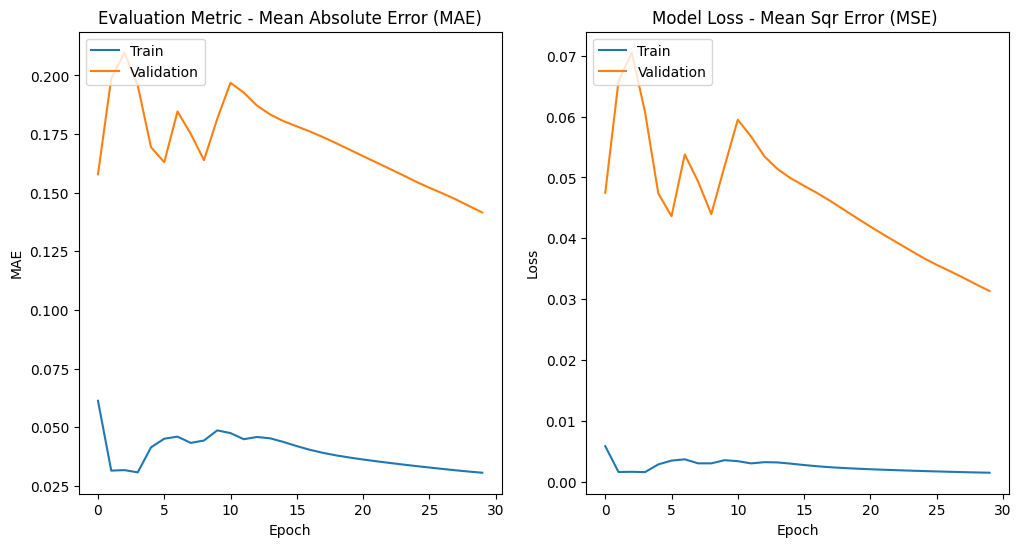

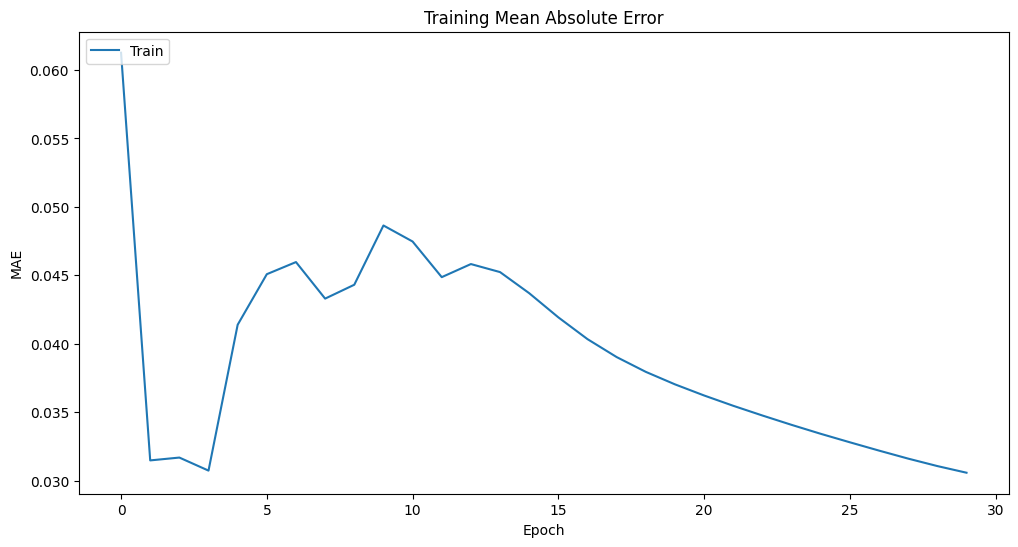

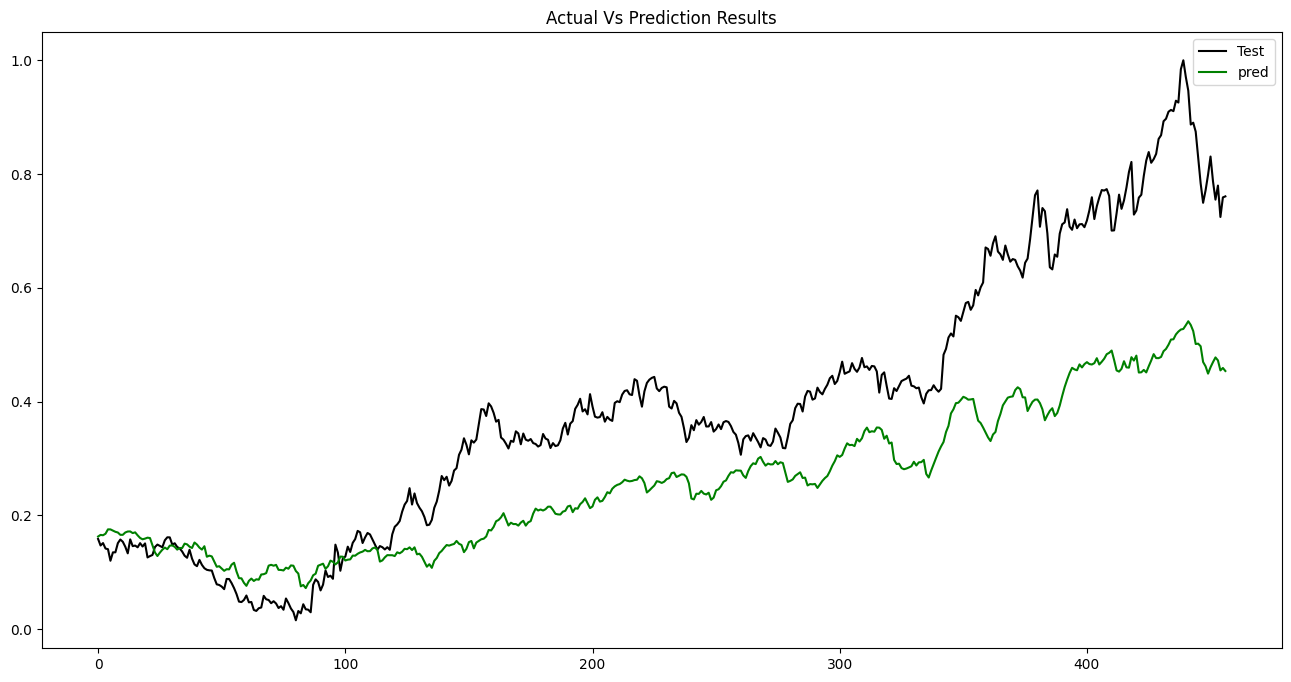

############################################################################
  Model Setup:
                    Name: XOM_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.15223042736368436
             mean_sqr_err =0.03517261682931016
        root_mean_sqr_err =0.18754363979967478
           pred_diff_mean =0.7544052737980165
      pred_diff_bias_mean =0.2455947262019834
    pred_correctness_mean =0.49452954048140046



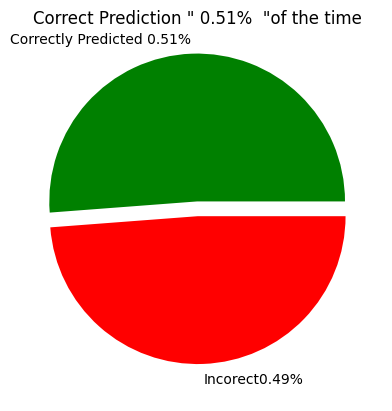

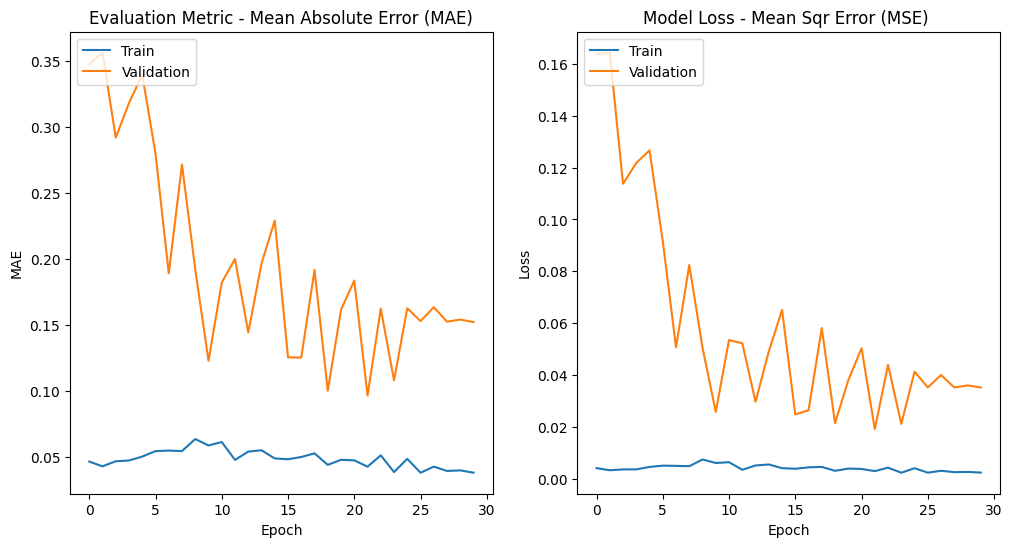

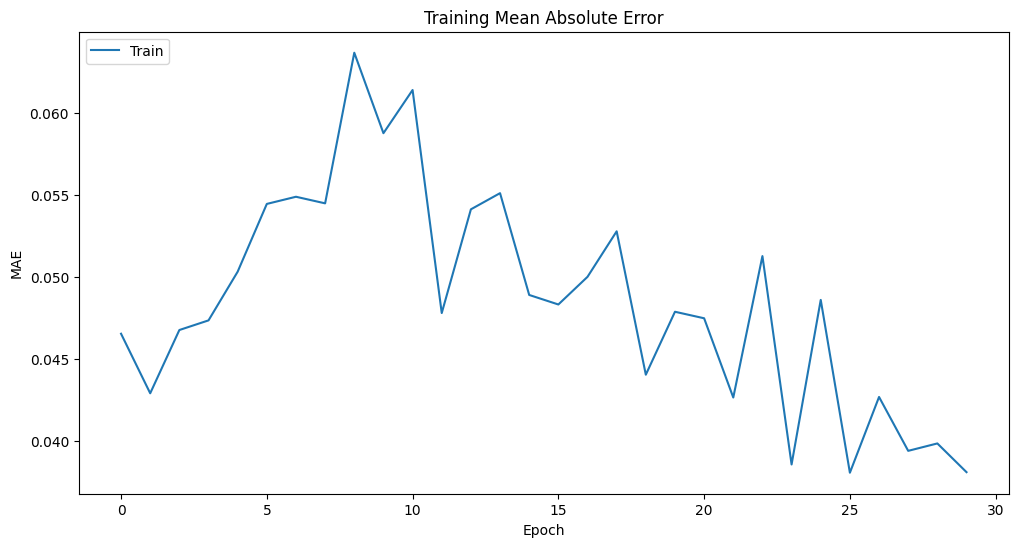

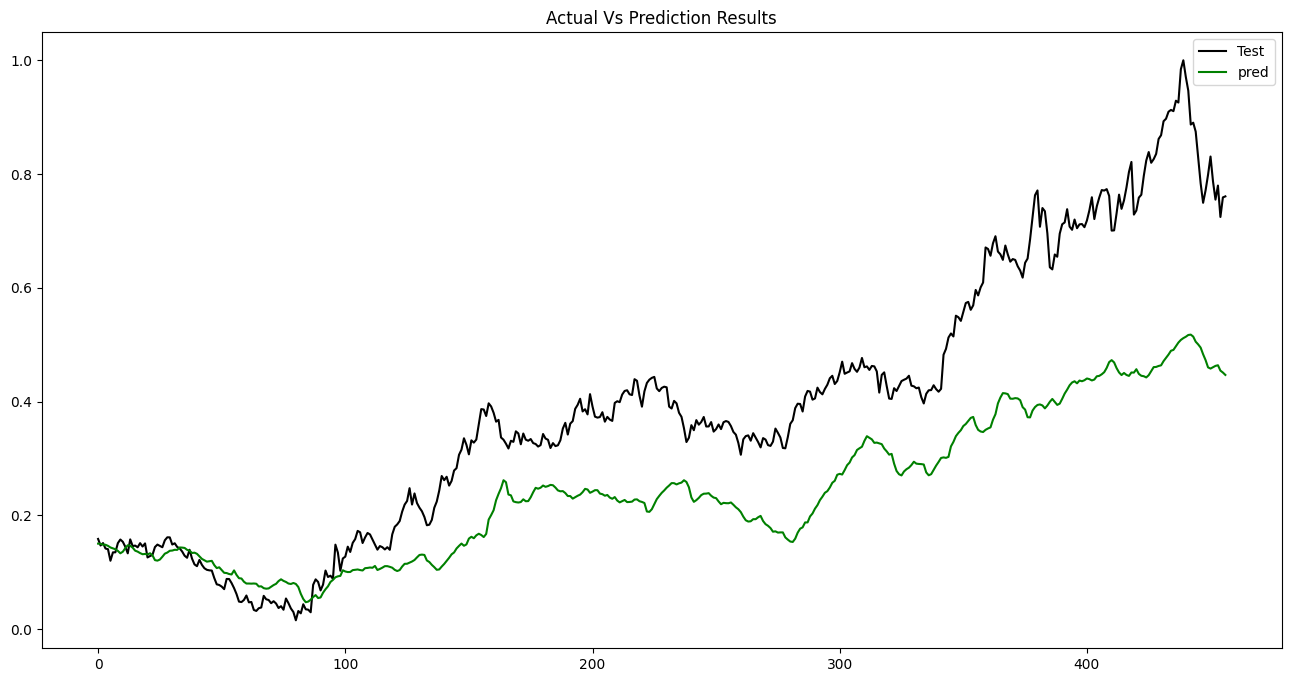

############################################################################
  Model Setup:
                    Name: XOM_F10_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.17431960256302656
             mean_sqr_err =0.04597051811453016
        root_mean_sqr_err =0.21440736487940465
           pred_diff_mean =0.7241788272054597
      pred_diff_bias_mean =0.2758211727945403
    pred_correctness_mean =0.4814004376367615



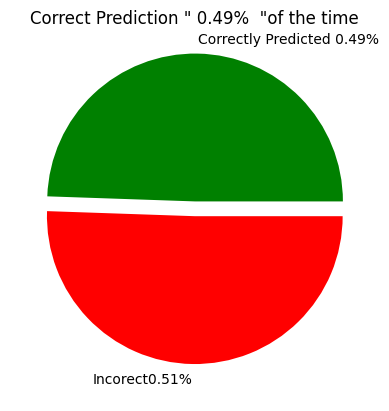

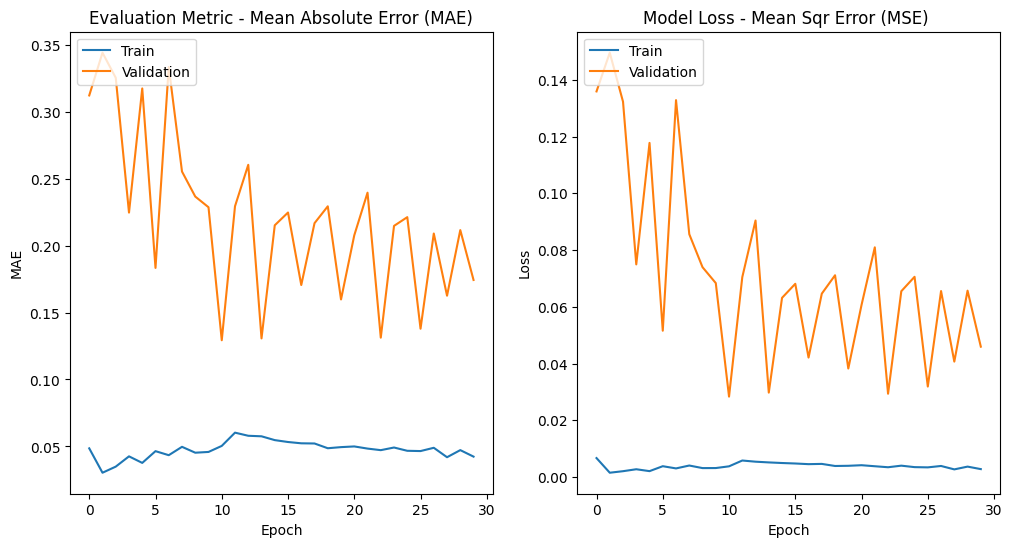

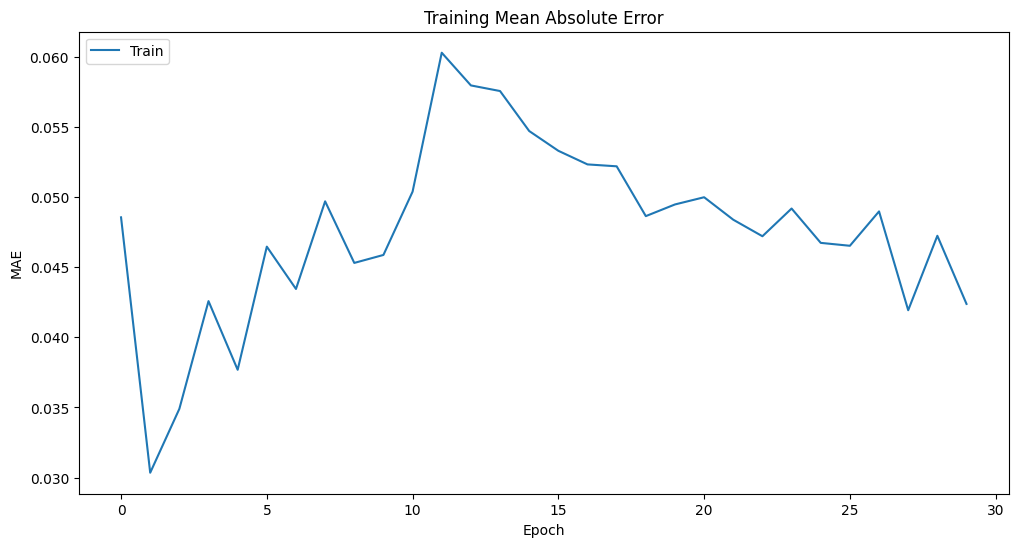

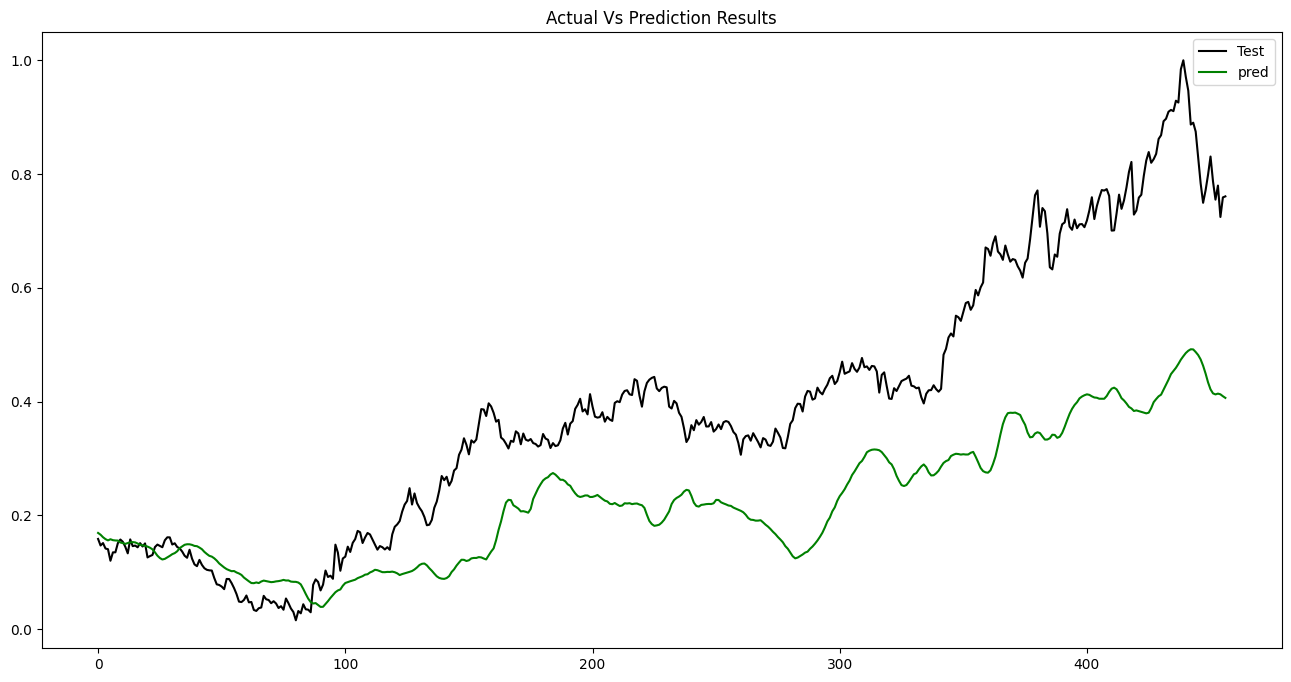

############################################################################
  Model Setup:
                    Name: XOM_F10_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.18562065915031362
             mean_sqr_err =0.049319698544076716
        root_mean_sqr_err =0.22208038757188064
           pred_diff_mean =0.7405122342121474
      pred_diff_bias_mean =0.25948776578785254
    pred_correctness_mean =0.47702407002188185



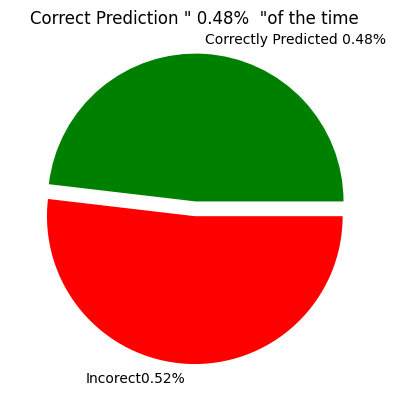

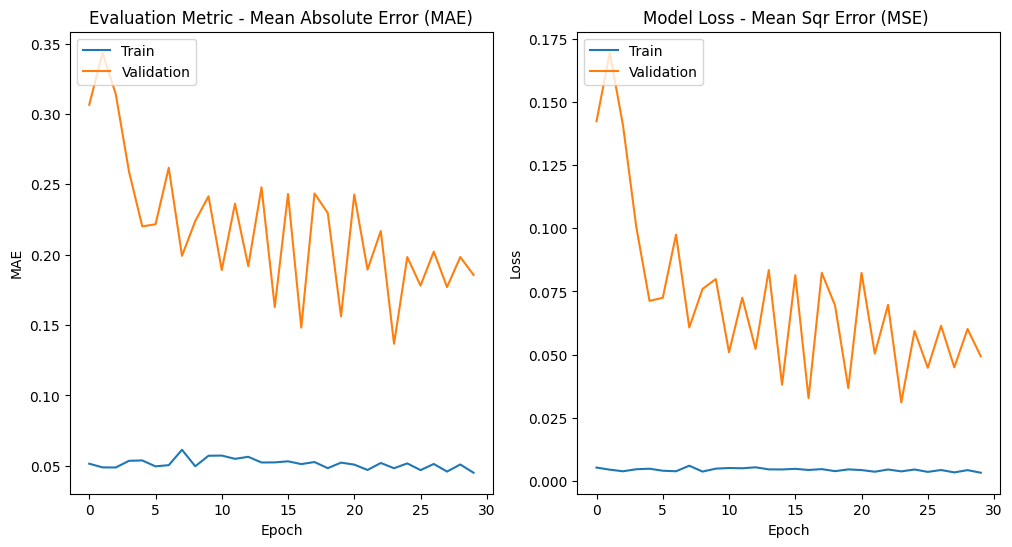

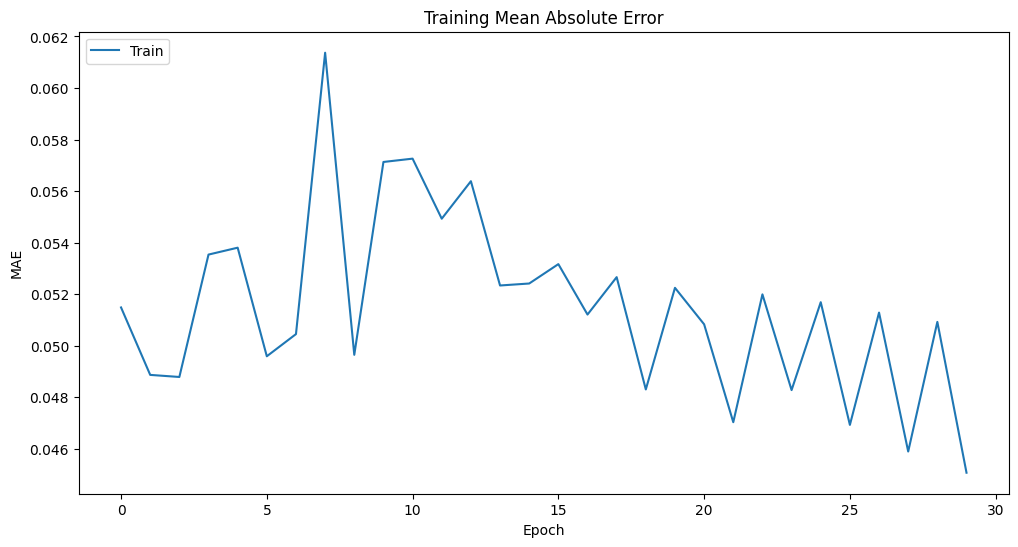

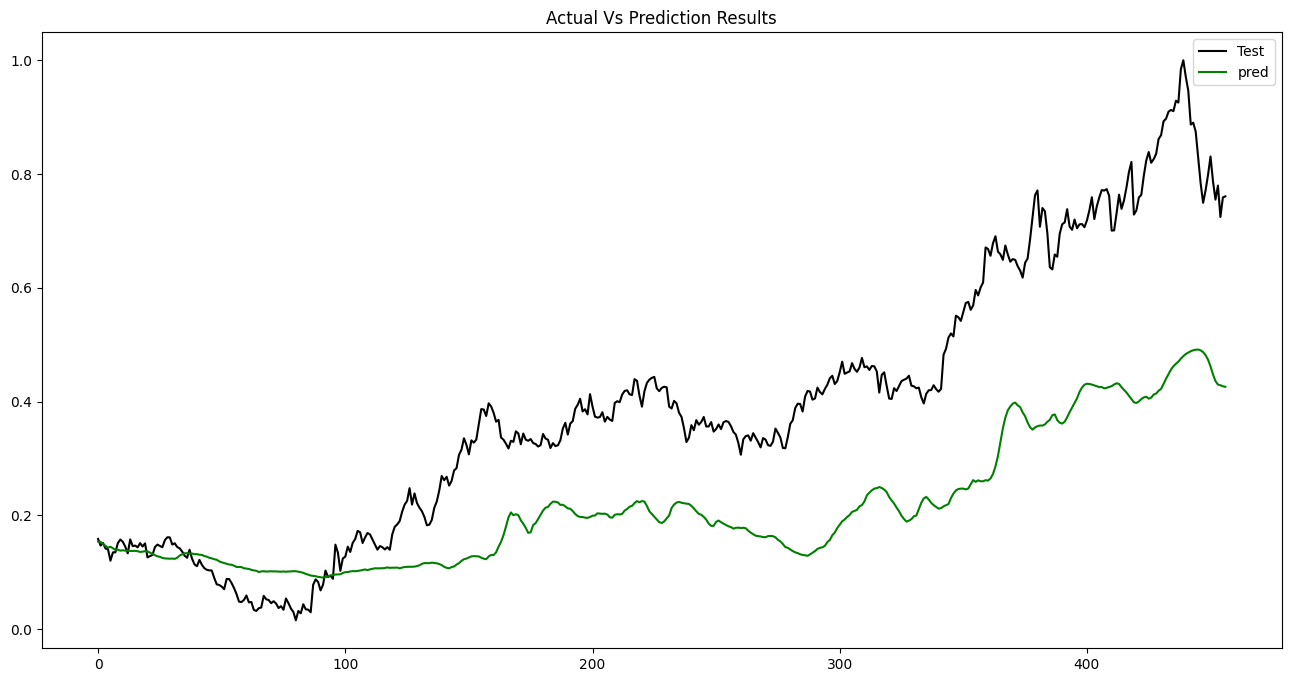

############################################################################
  Model Setup:
                    Name: XOM_F10_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.19385455018113665
             mean_sqr_err =0.05422786507789728
        root_mean_sqr_err =0.23286877222568353
           pred_diff_mean =0.7902717628969866
      pred_diff_bias_mean =0.20972823710301344
    pred_correctness_mean =0.4660831509846827



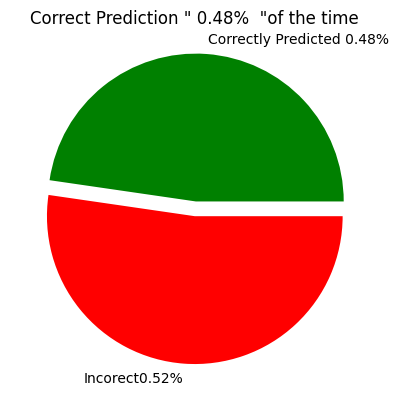

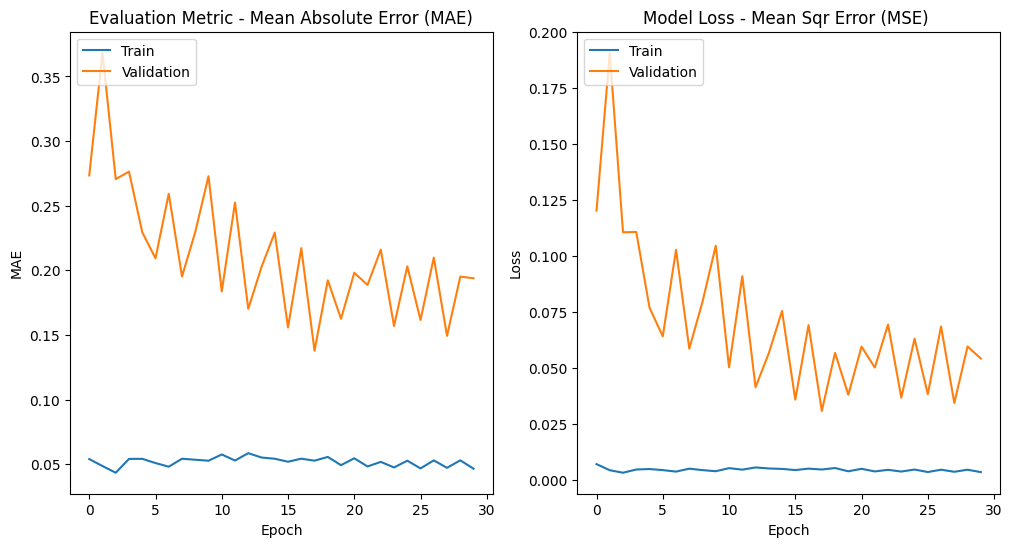

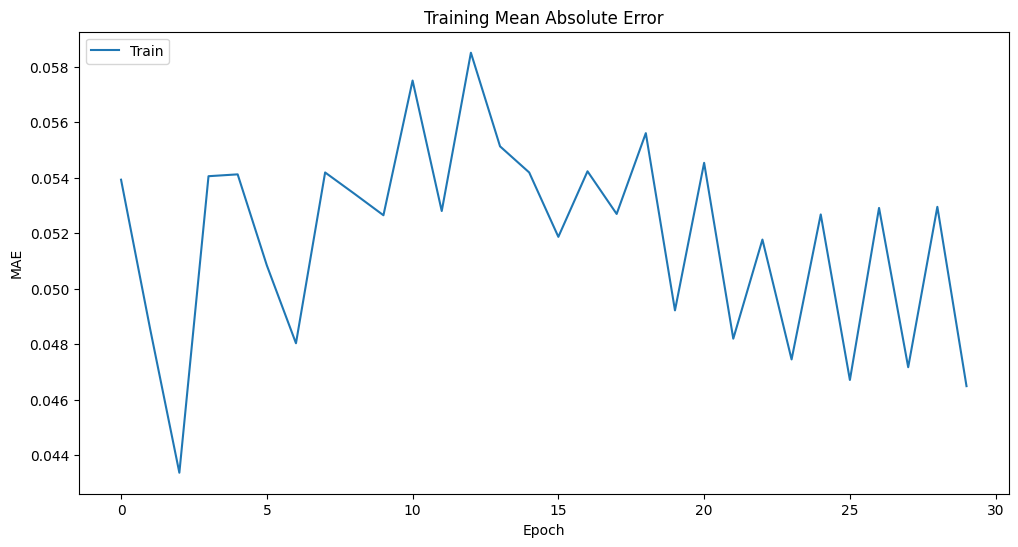

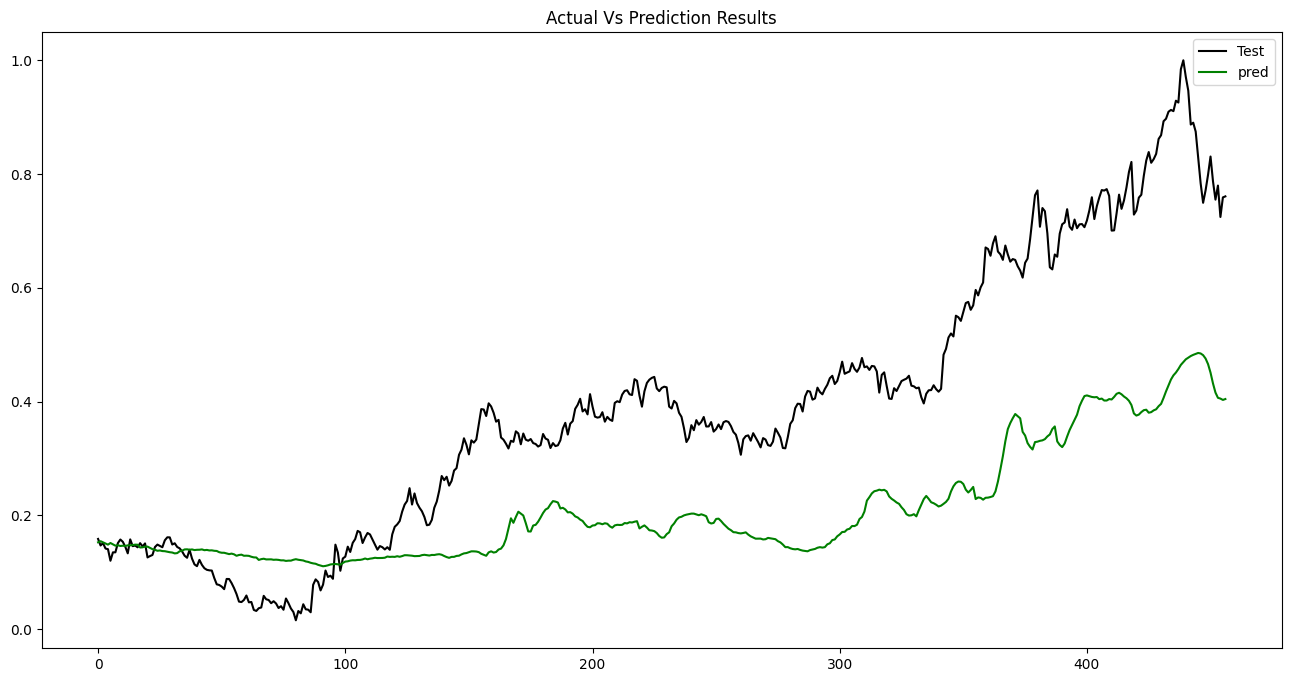

############################################################################
  Model Setup:
                    Name: XOM_F10_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.20859342051123597
             mean_sqr_err =0.06298423206161981
        root_mean_sqr_err =0.2509665955094817
           pred_diff_mean =0.7429642422297049
      pred_diff_bias_mean =0.2570357577702951
    pred_correctness_mean =0.47045951859956237



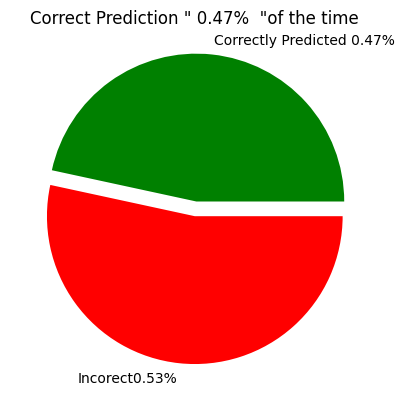

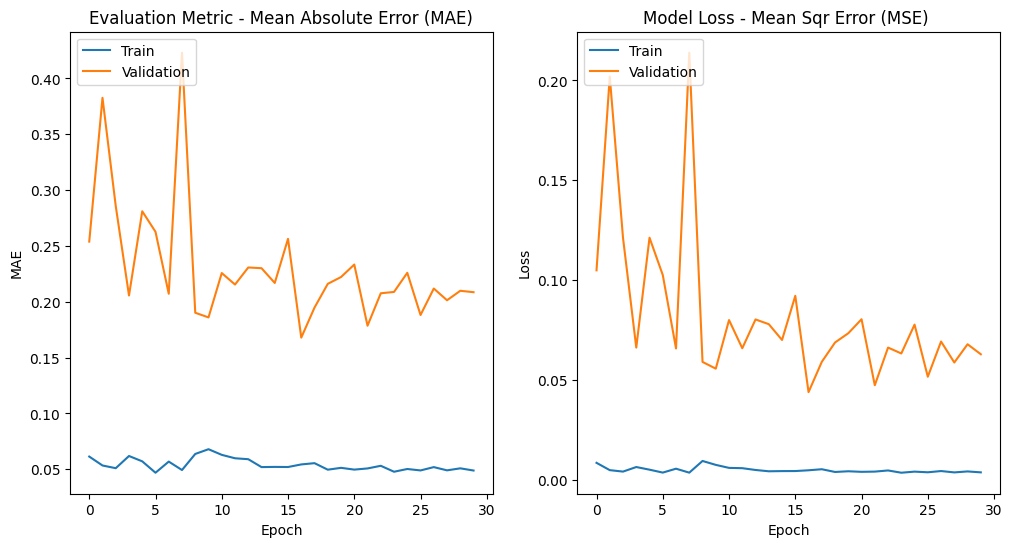

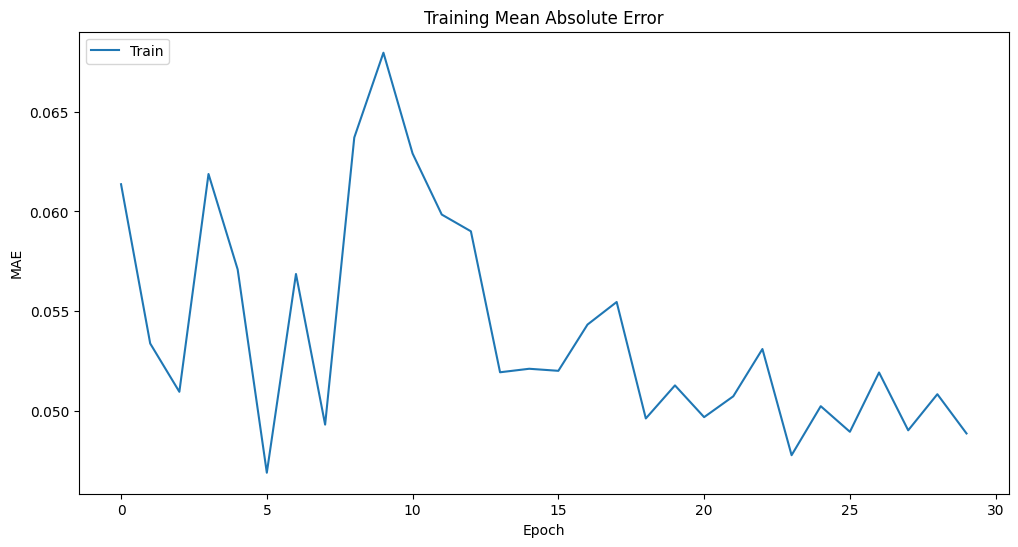

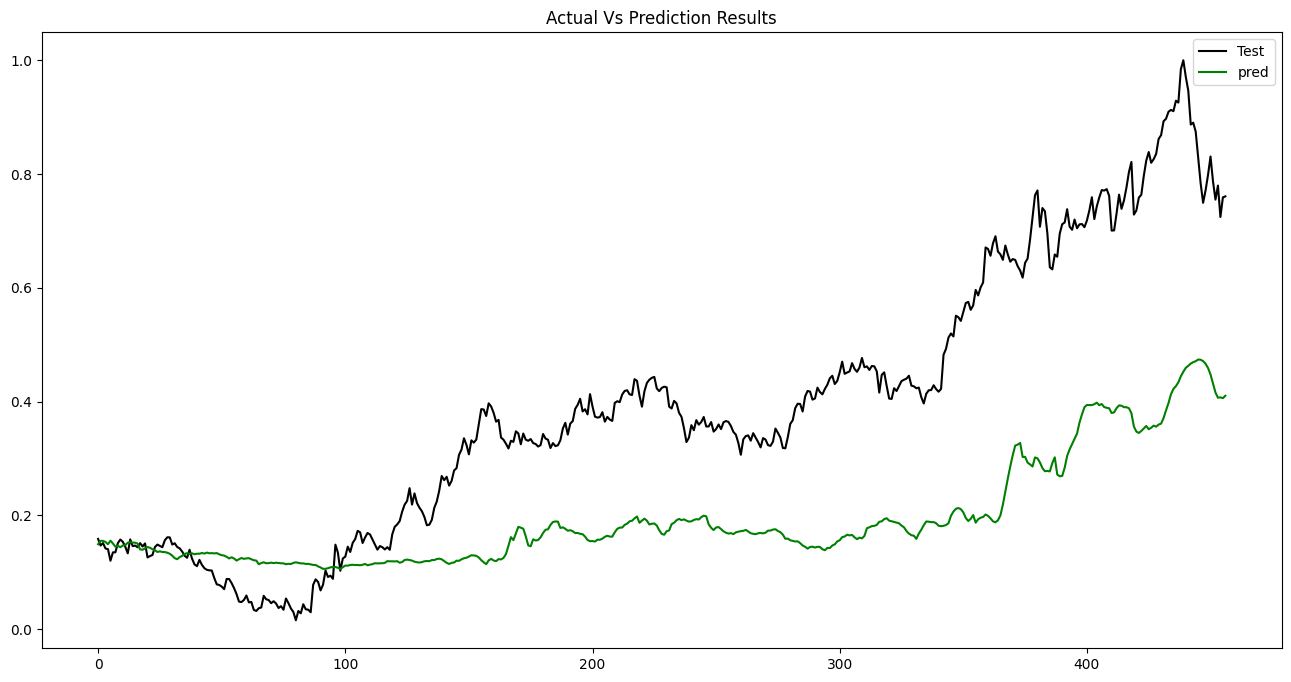

############################################################################
  Model Setup:
                    Name: XOM_F25_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.13176372139729614
             mean_sqr_err =0.027387832870485167
        root_mean_sqr_err =0.16549269733279826
           pred_diff_mean =0.7589762718318962
      pred_diff_bias_mean =0.24102372816810372
    pred_correctness_mean =0.5550660792951542



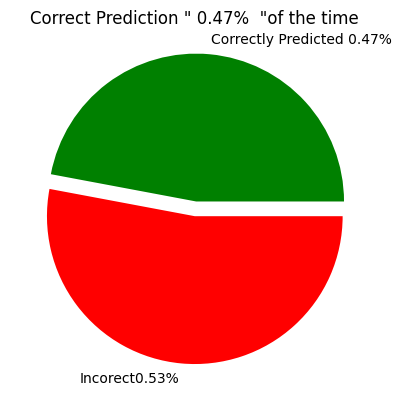

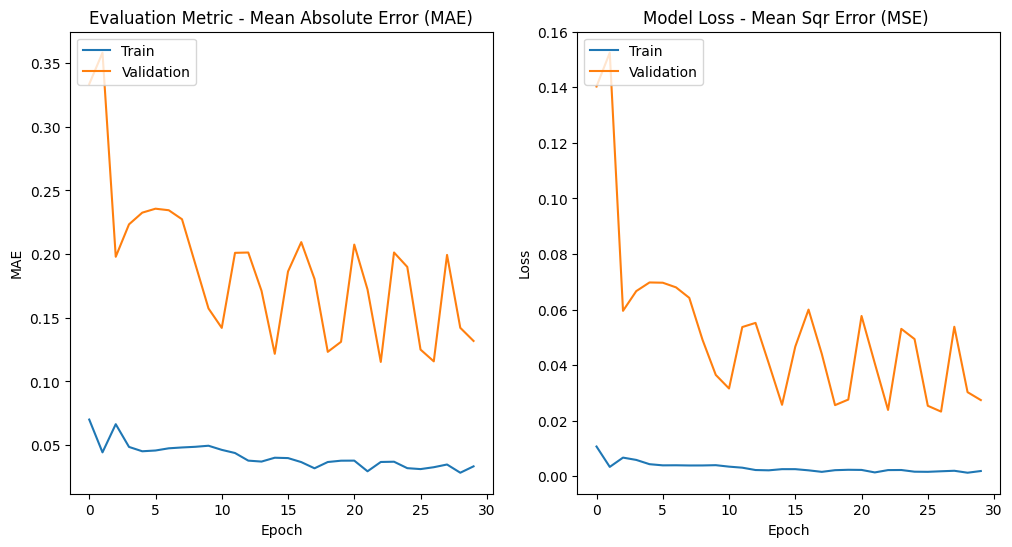

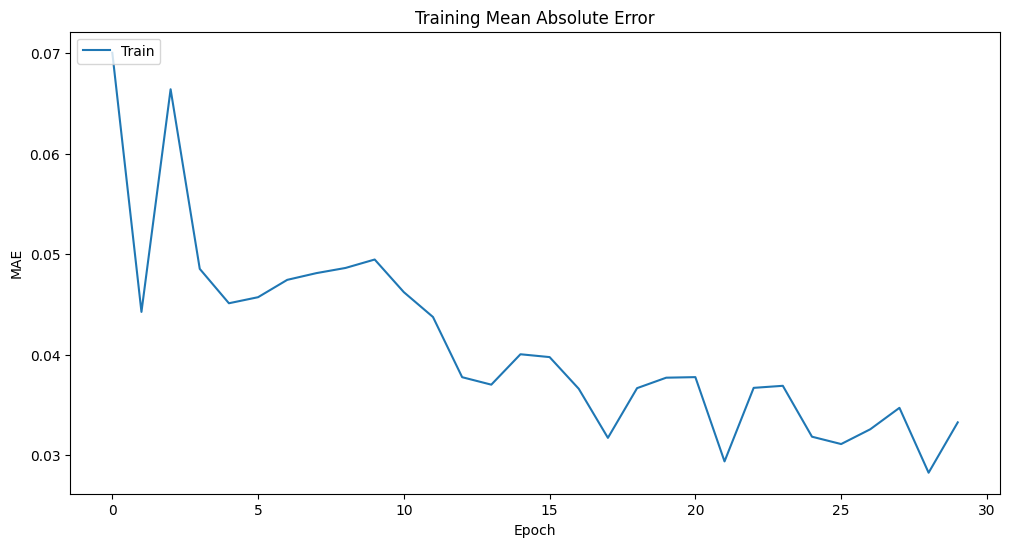

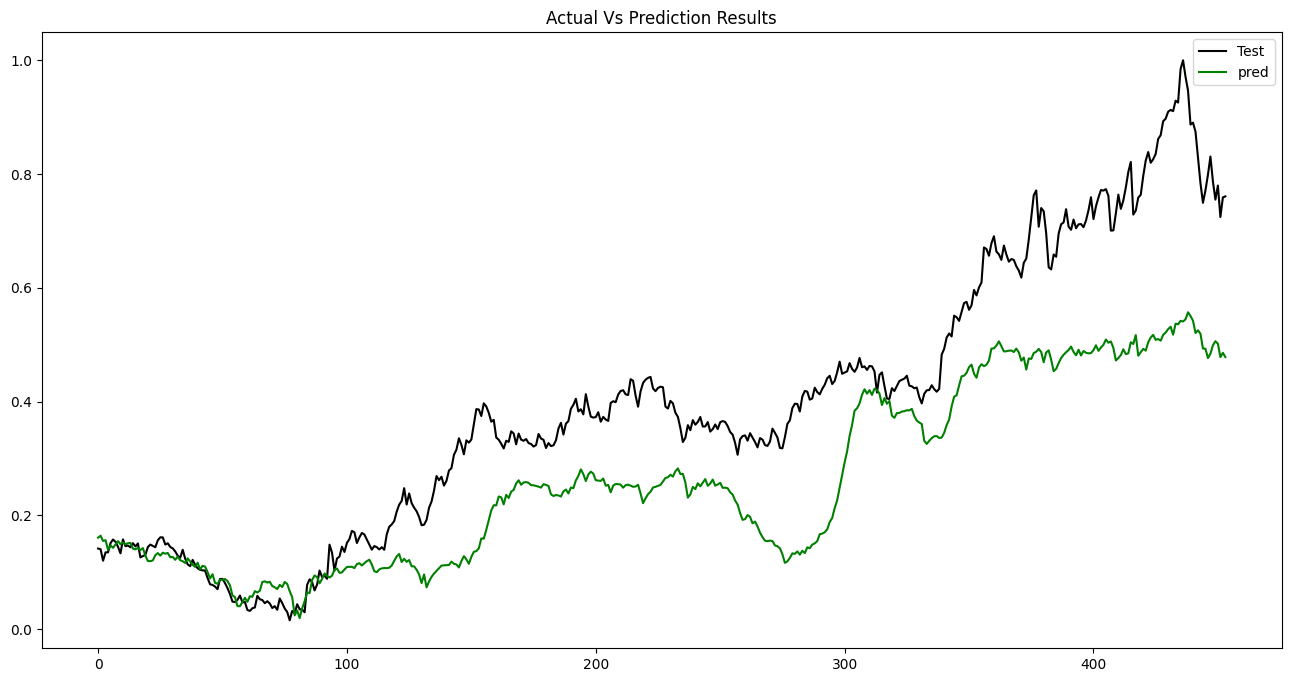

############################################################################
  Model Setup:
                    Name: XOM_F25_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.1358072604144355
             mean_sqr_err =0.02955960176558644
        root_mean_sqr_err =0.17192906027075947
           pred_diff_mean =0.8206820697227499
      pred_diff_bias_mean =0.17931793027725001
    pred_correctness_mean =0.5308370044052864



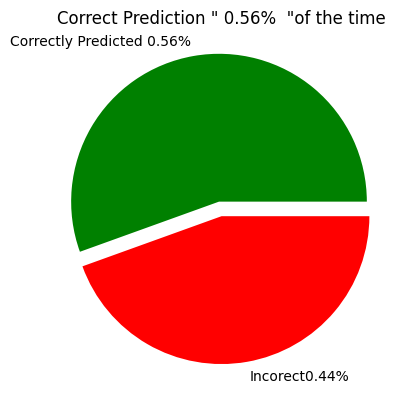

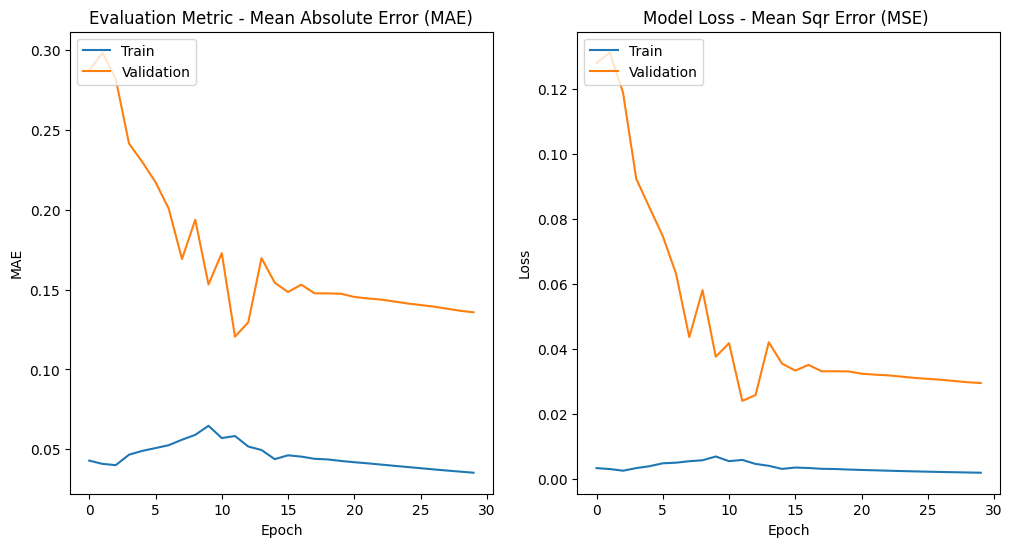

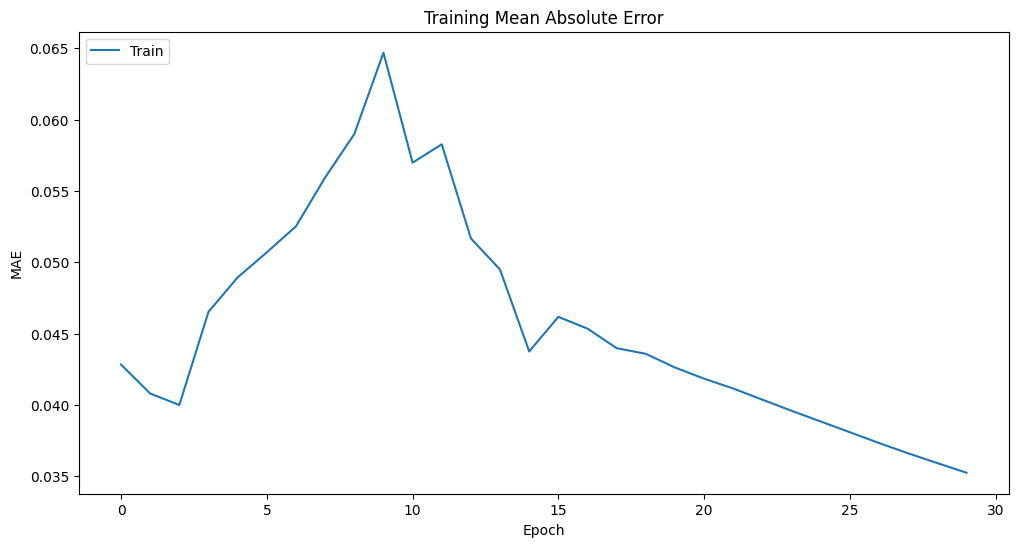

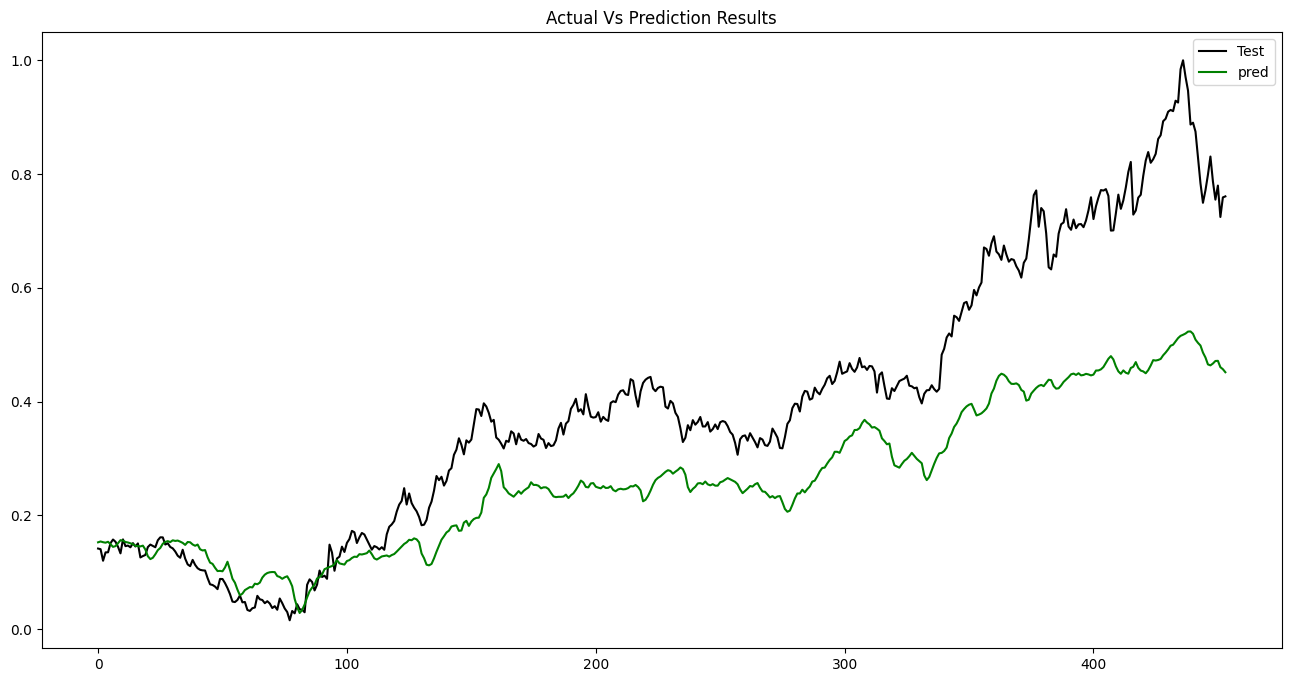

############################################################################
  Model Setup:
                    Name: XOM_F25_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.17376504570836604
             mean_sqr_err =0.04423709230963778
        root_mean_sqr_err =0.2103261569791969
           pred_diff_mean =0.8295803058683752
      pred_diff_bias_mean =0.1704196941316248
    pred_correctness_mean =0.44933920704845814



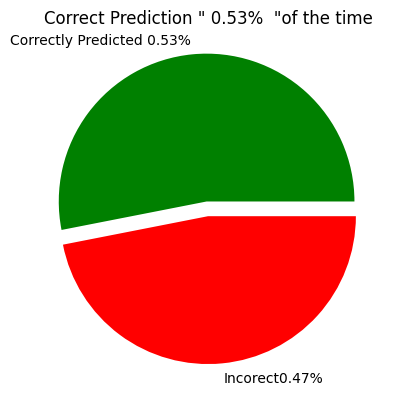

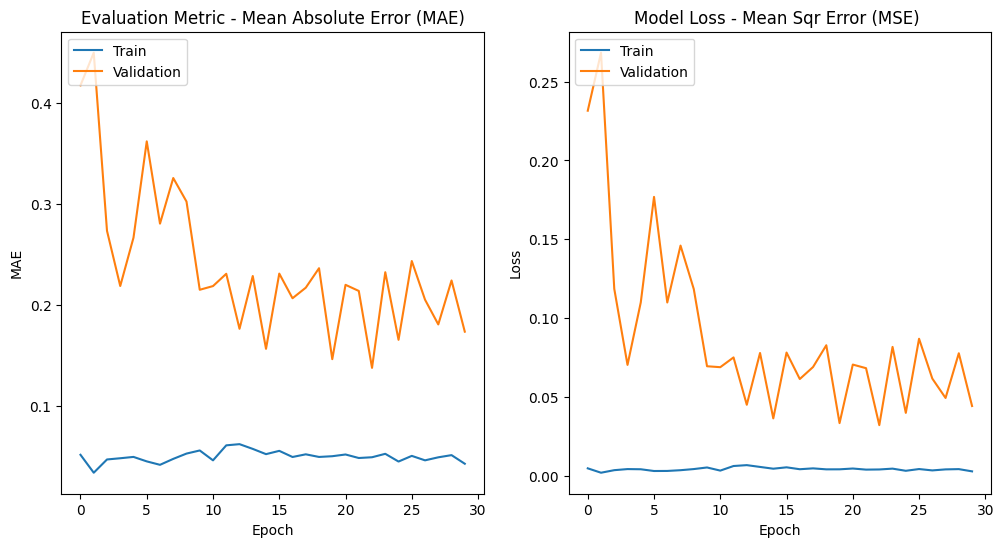

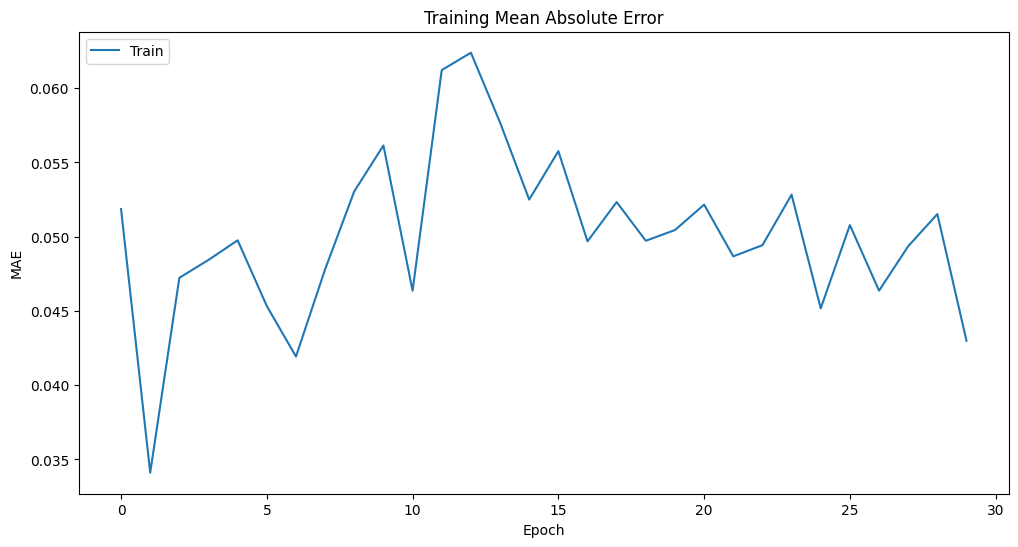

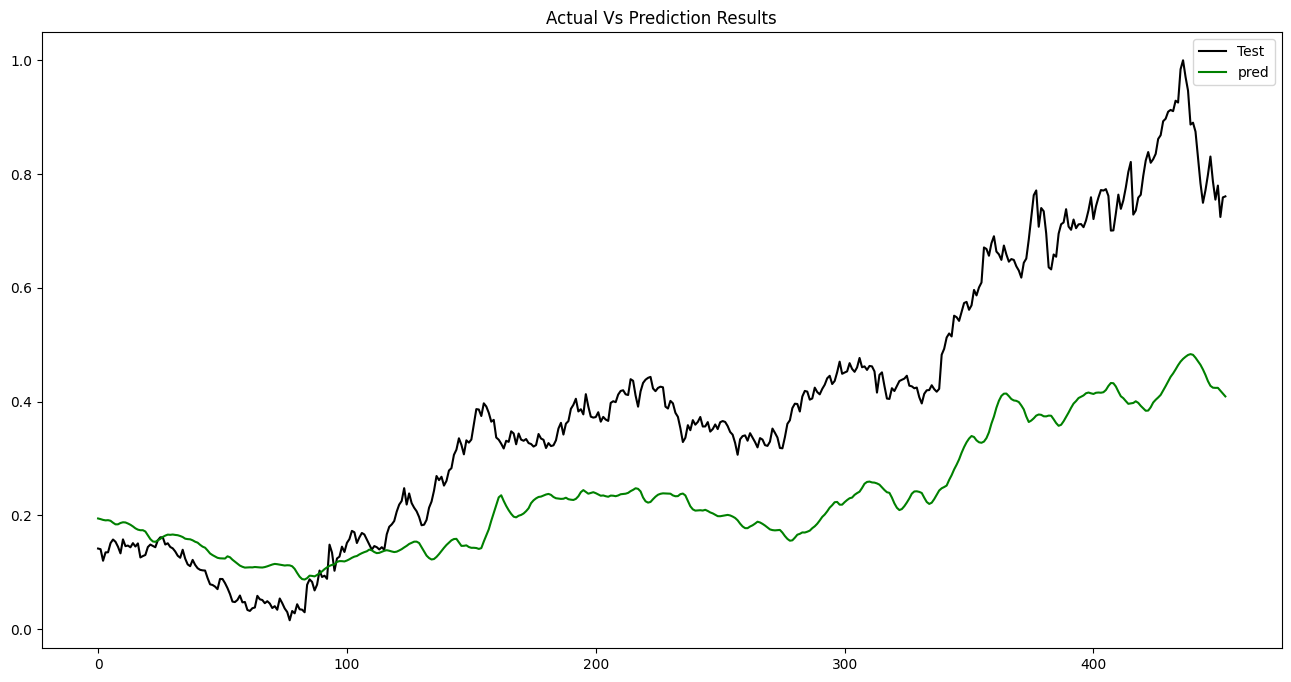

############################################################################
  Model Setup:
                    Name: XOM_F25_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.2842313400771311
             mean_sqr_err =0.11225098761117018
        root_mean_sqr_err =0.335038785234143
           pred_diff_mean =0.6601160507224219
      pred_diff_bias_mean =0.3398839492775781
    pred_correctness_mean =0.42731277533039647



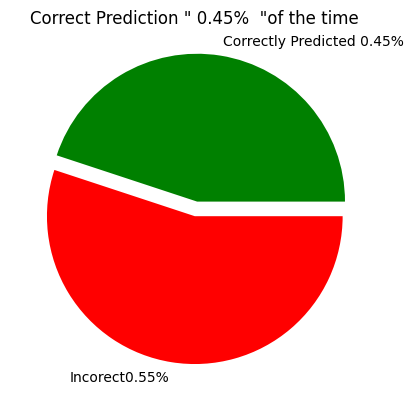

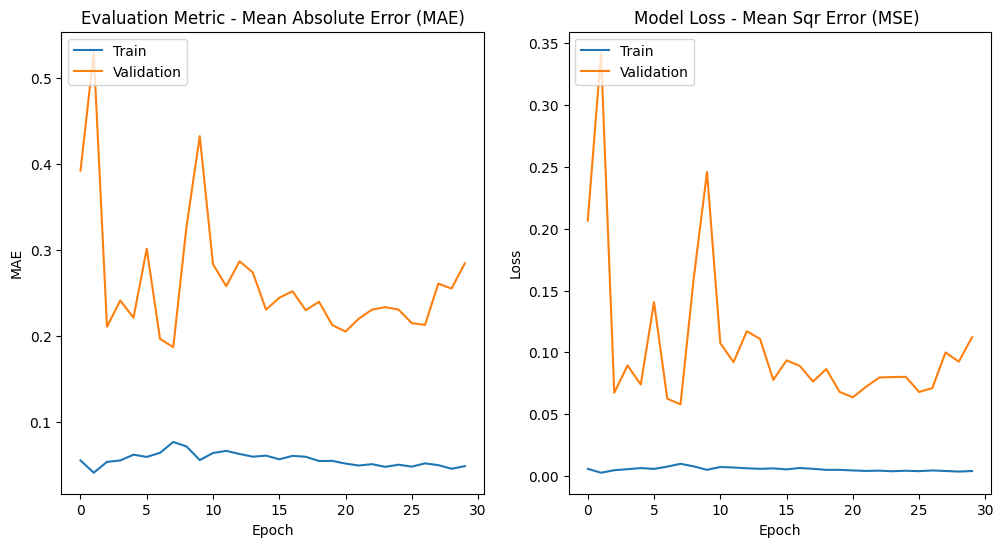

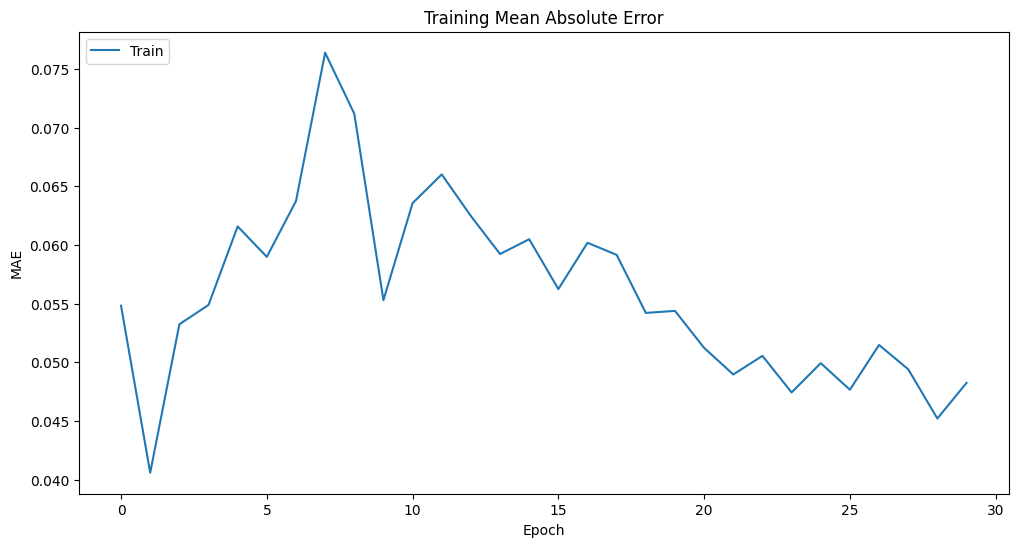

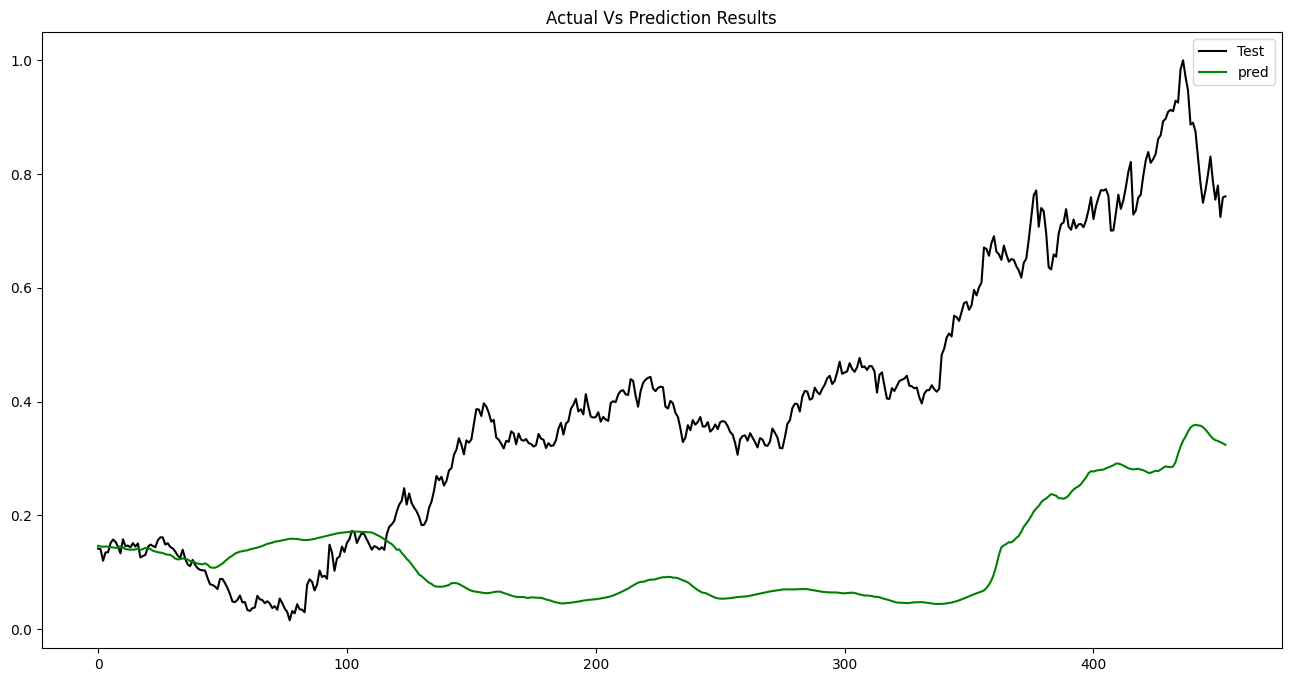

############################################################################
  Model Setup:
                    Name: XOM_F25_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.20470614741222626
             mean_sqr_err =0.06619815689208156
        root_mean_sqr_err =0.25729002485926566
           pred_diff_mean =1.0278012131027972
      pred_diff_bias_mean =-0.027801213102797193
    pred_correctness_mean =0.394273127753304



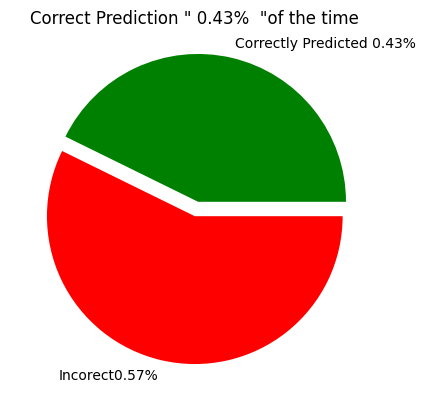

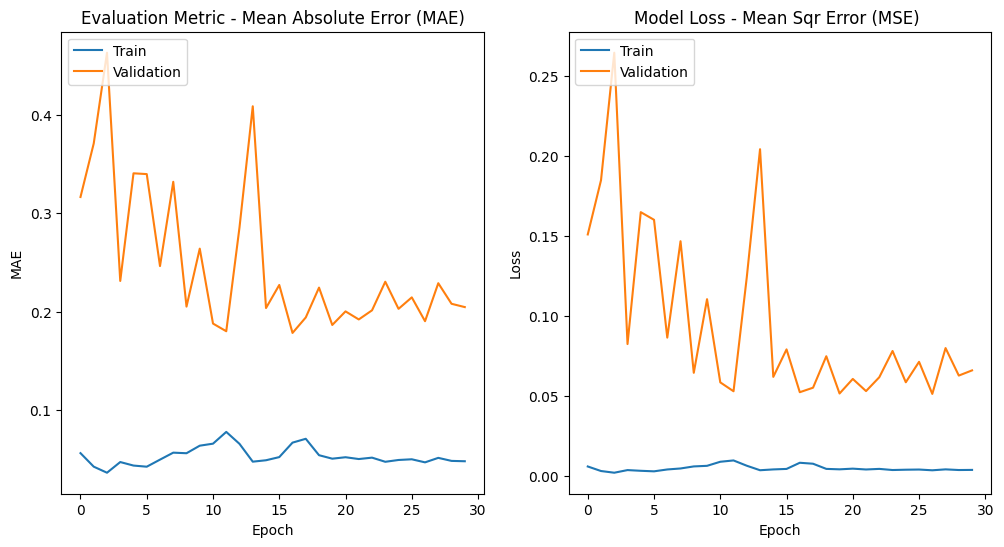

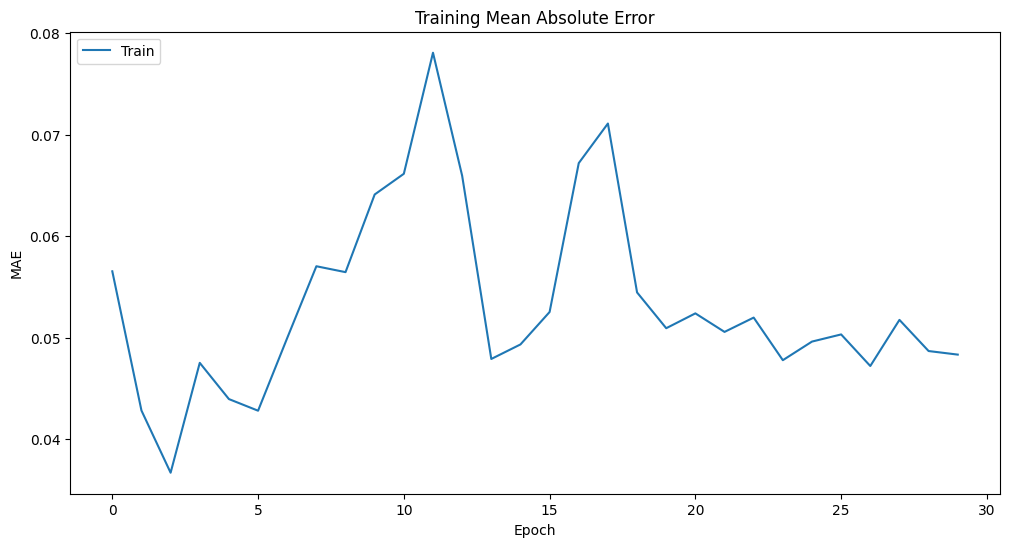

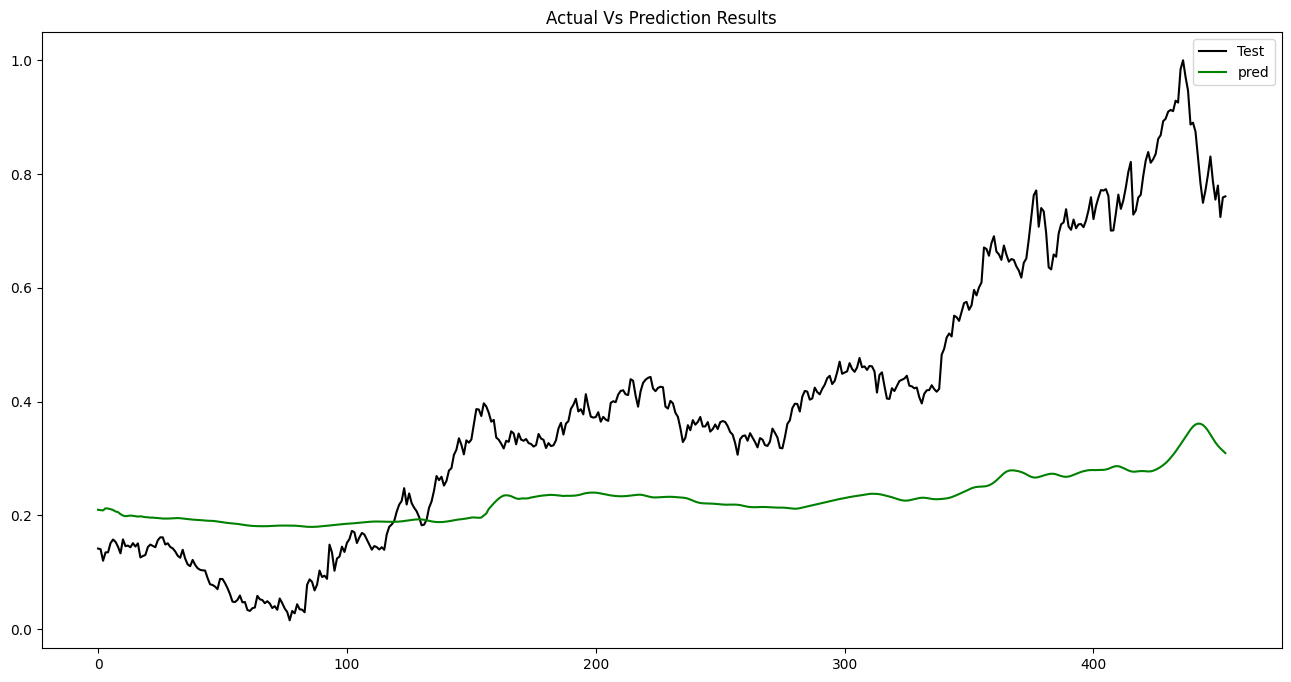

############################################################################
  Model Setup:
                    Name: XOM_F25_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.2522846341529657
             mean_sqr_err =0.08276770868223012
        root_mean_sqr_err =0.28769377588371653
           pred_diff_mean =0.7370726952804021
      pred_diff_bias_mean =0.2629273047195981
    pred_correctness_mean =0.3590308370044053



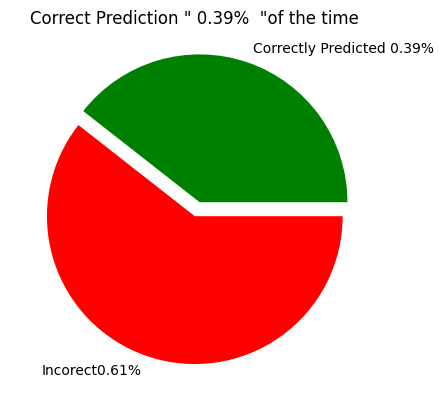

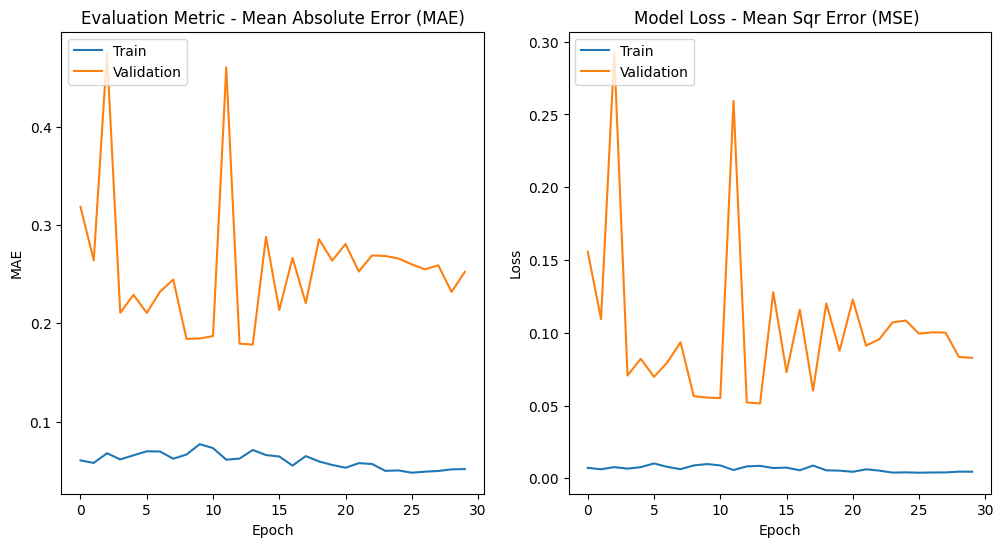

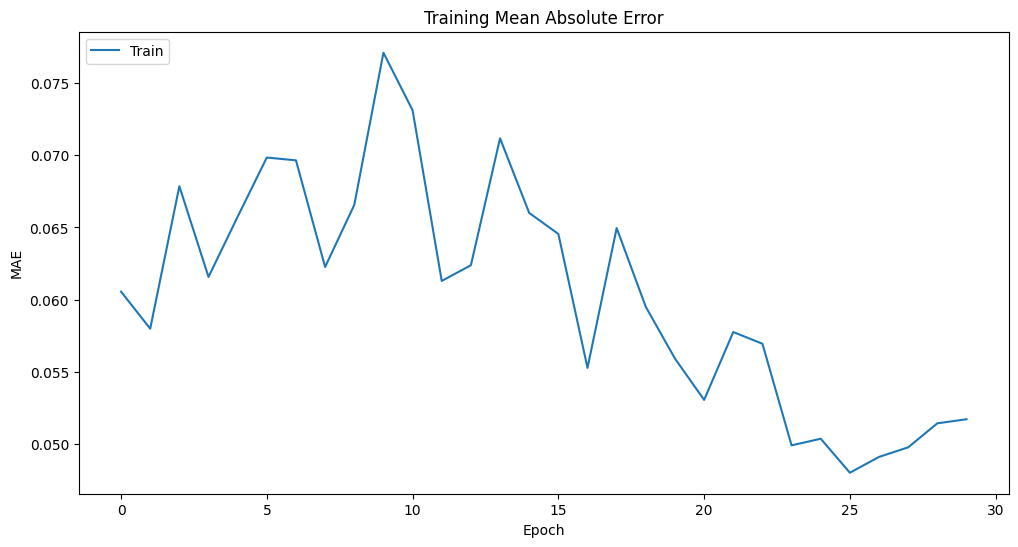

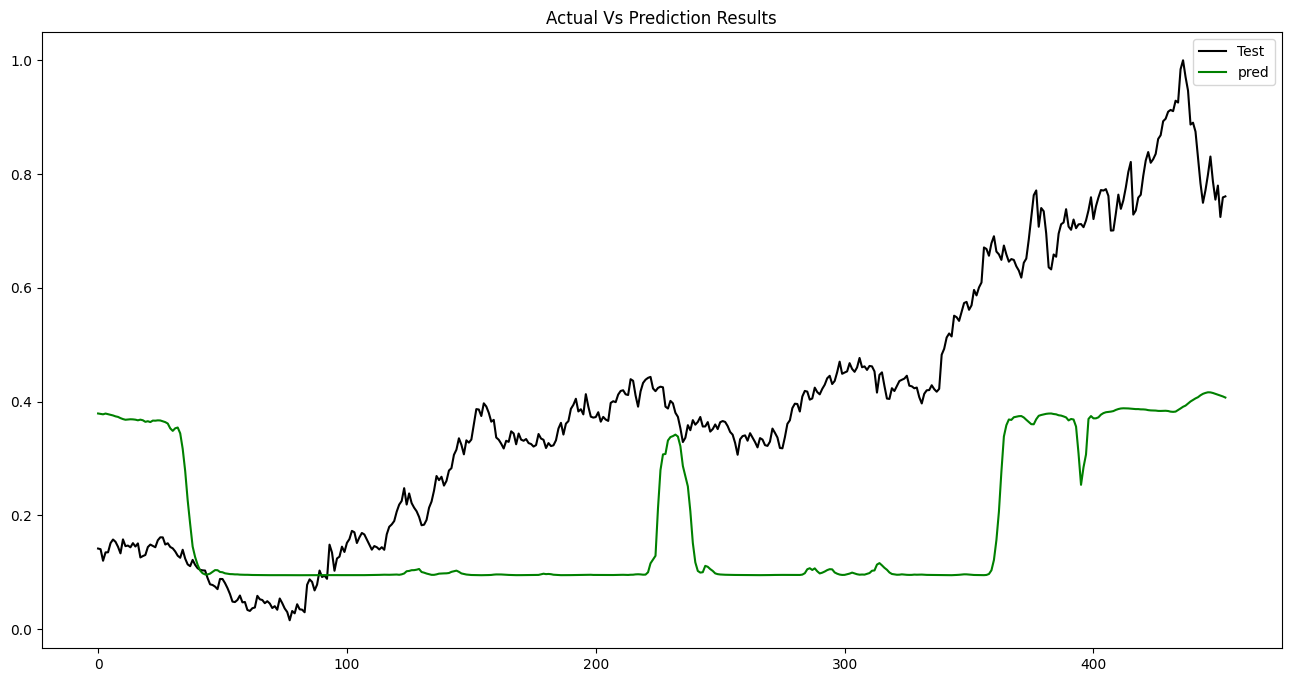

############################################################################
  Model Setup:
                    Name: XOM_F50_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.1960025693135622
             mean_sqr_err =0.04981345649190113
        root_mean_sqr_err =0.22318928399880925
           pred_diff_mean =0.47769128877514716
      pred_diff_bias_mean =0.5223087112248529
    pred_correctness_mean =0.4766146993318486



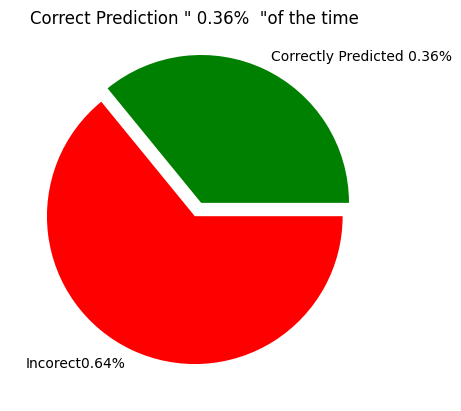

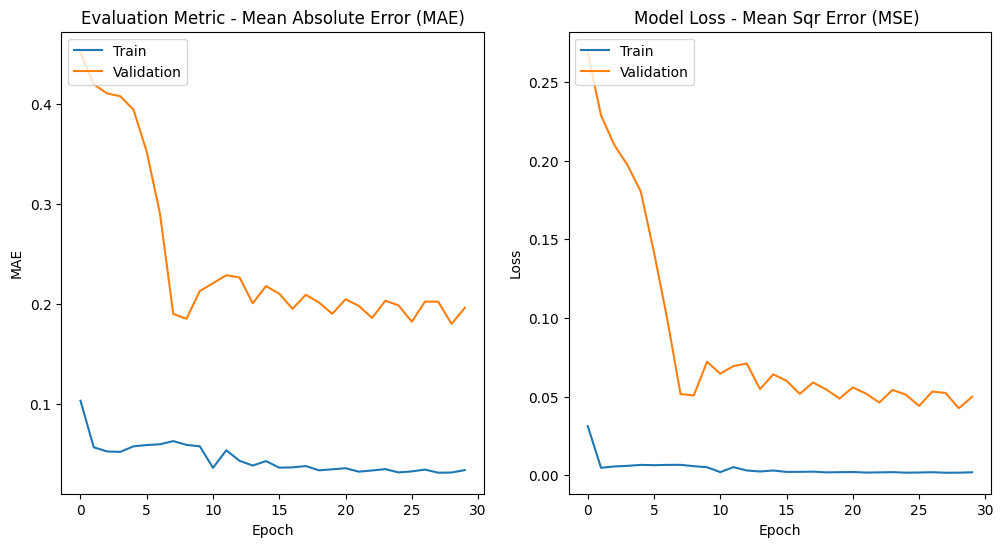

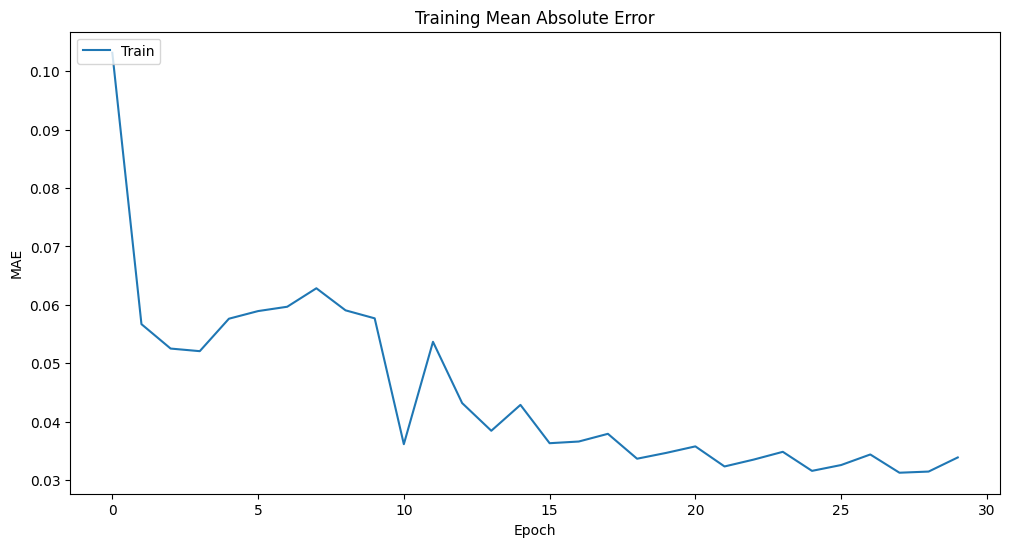

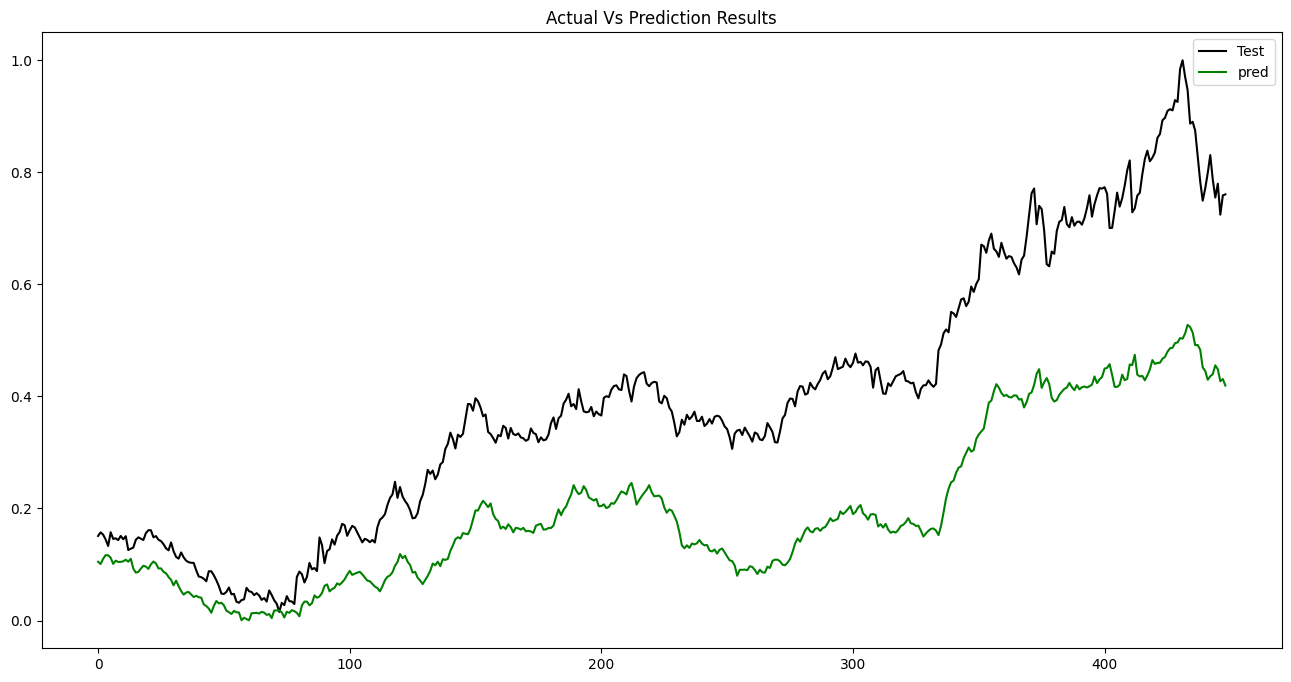

############################################################################
  Model Setup:
                    Name: XOM_F50_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.24914361787456932
             mean_sqr_err =0.09542790228183218
        root_mean_sqr_err =0.30891406941386174
           pred_diff_mean =0.7341734384504953
      pred_diff_bias_mean =0.2658265615495047
    pred_correctness_mean =0.44543429844098



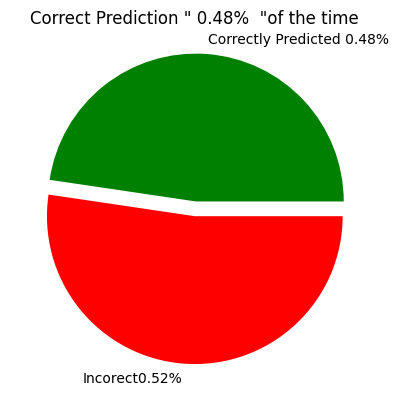

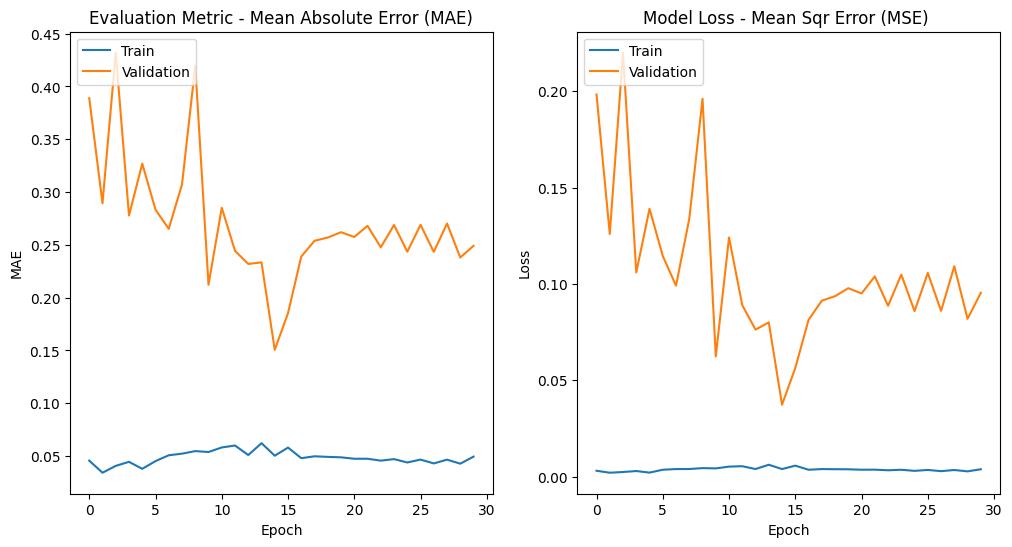

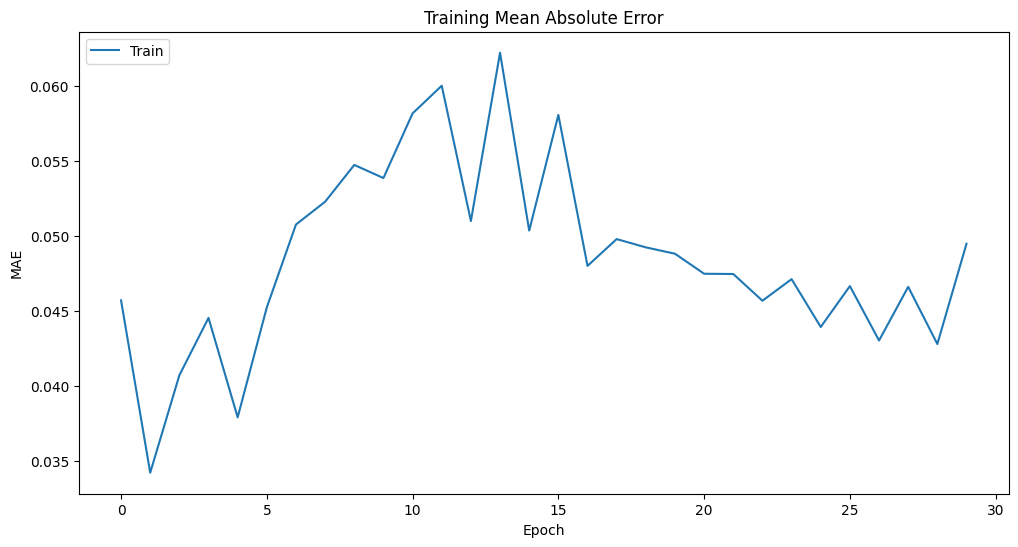

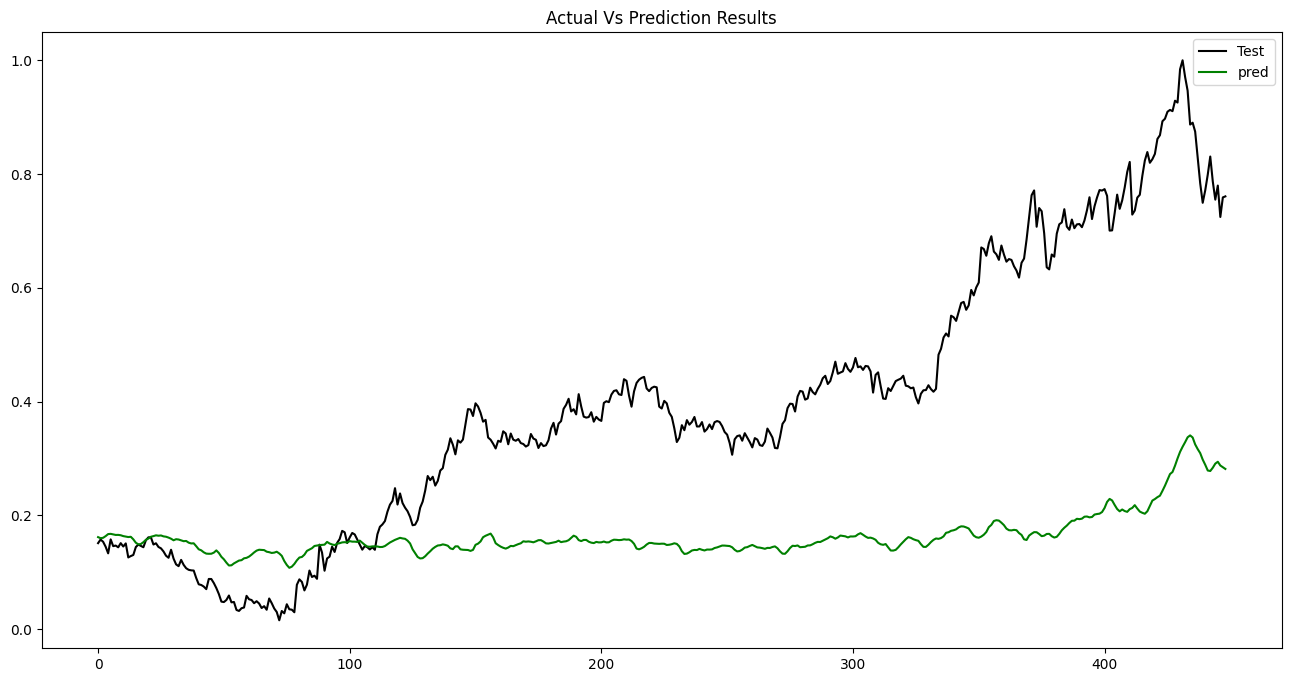

############################################################################
  Model Setup:
                    Name: XOM_F50_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.206501123222855
             mean_sqr_err =0.0640696153706626
        root_mean_sqr_err =0.25311976487556753
           pred_diff_mean =0.8022215106655547
      pred_diff_bias_mean =0.19777848933444528
    pred_correctness_mean =0.43875278396436523



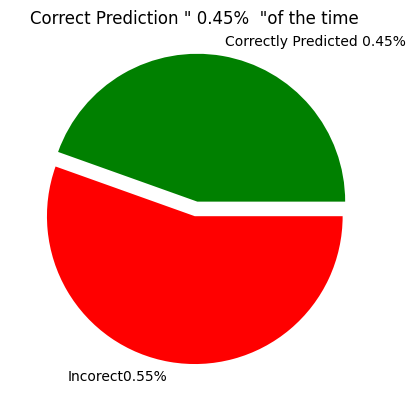

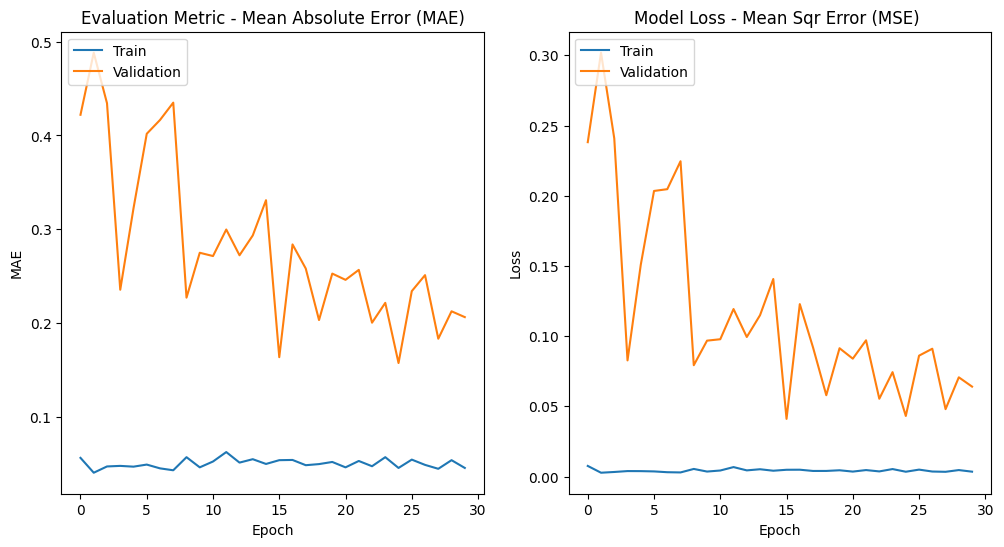

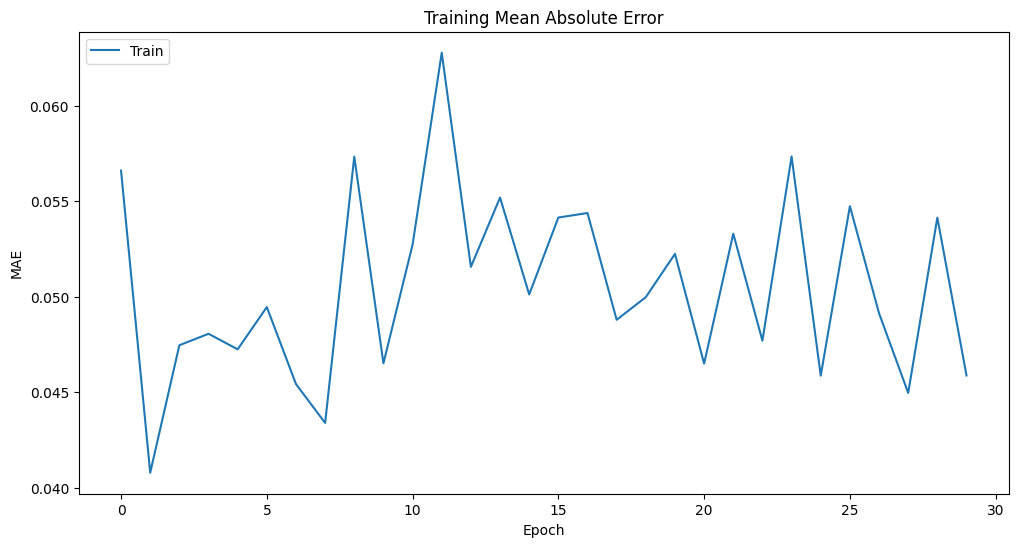

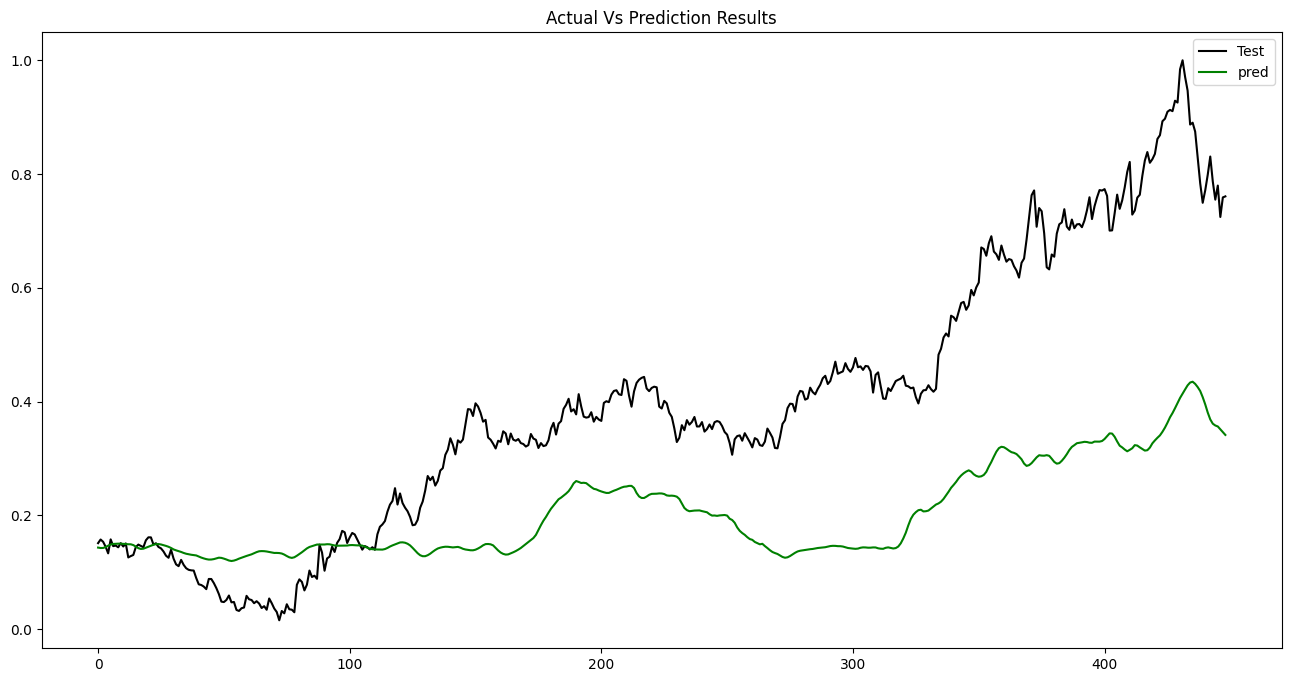

############################################################################
  Model Setup:
                    Name: XOM_F50_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.27281032176822173
             mean_sqr_err =0.11766438284943664
        root_mean_sqr_err =0.34302242324582316
           pred_diff_mean =0.6430360378666617
      pred_diff_bias_mean =0.35696396213333825
    pred_correctness_mean =0.43429844097995546



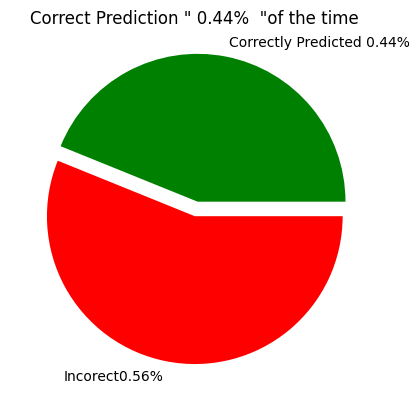

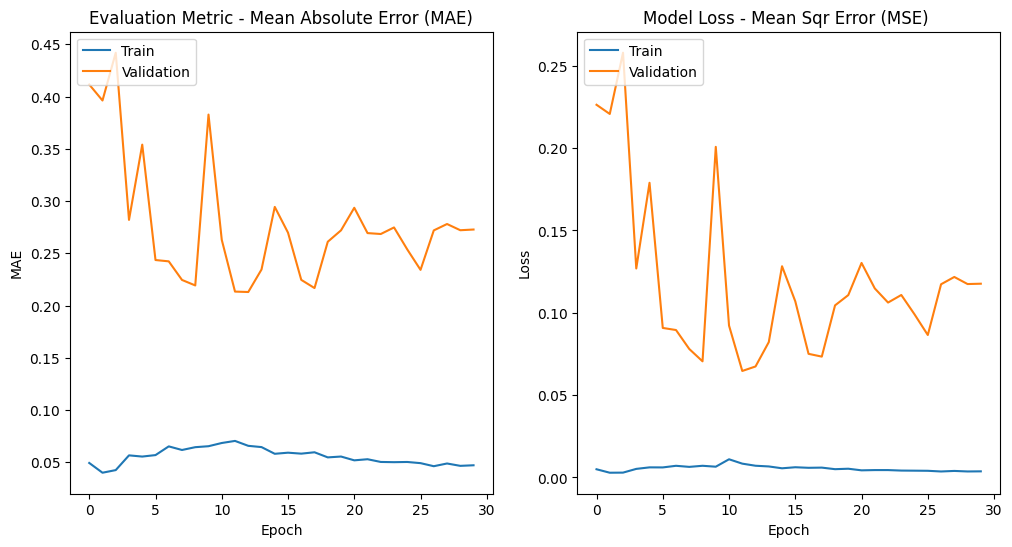

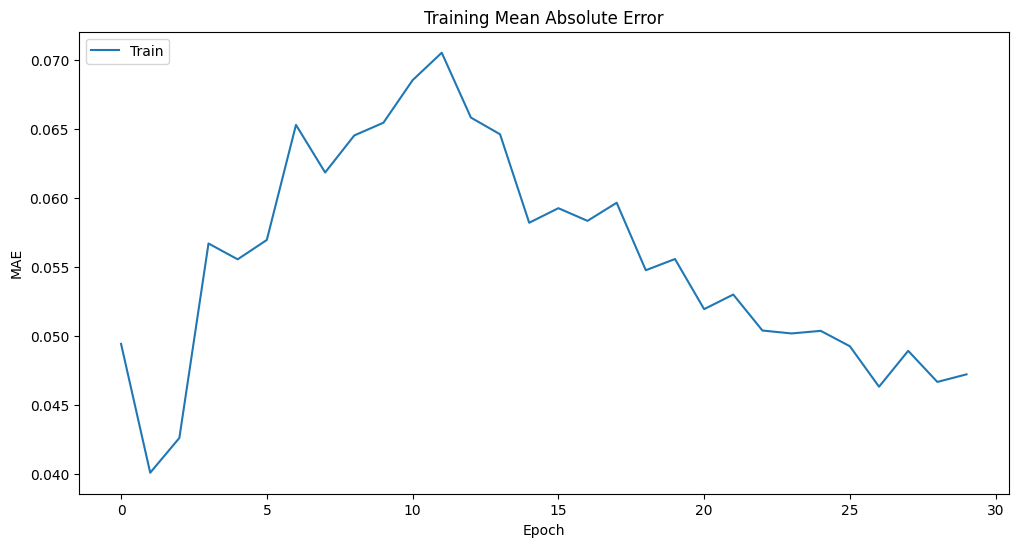

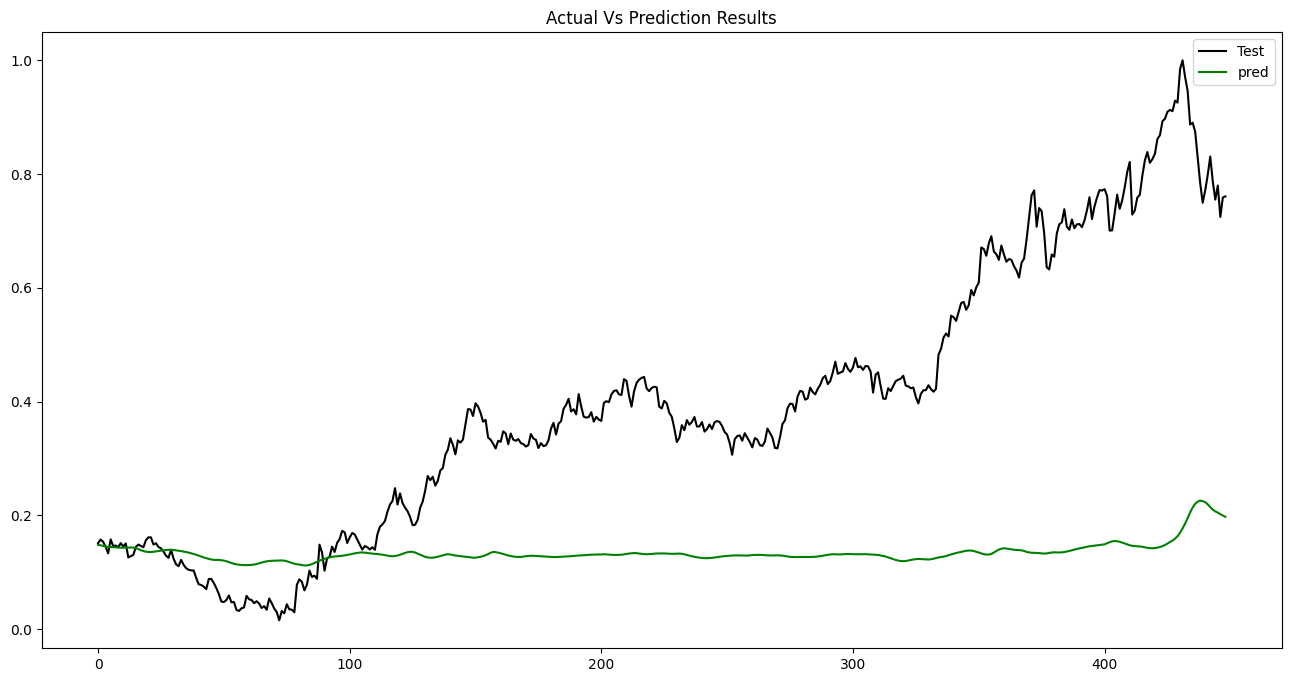

############################################################################
  Model Setup:
                    Name: XOM_F50_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.18937863960942836
             mean_sqr_err =0.0564235954399037
        root_mean_sqr_err =0.23753651390871194
           pred_diff_mean =2.128033012588226
      pred_diff_bias_mean =-1.1280330125882256
    pred_correctness_mean =0.5233853006681515



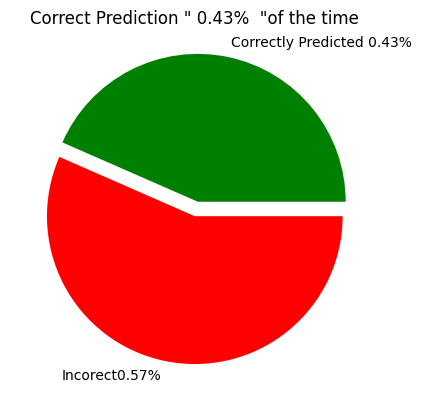

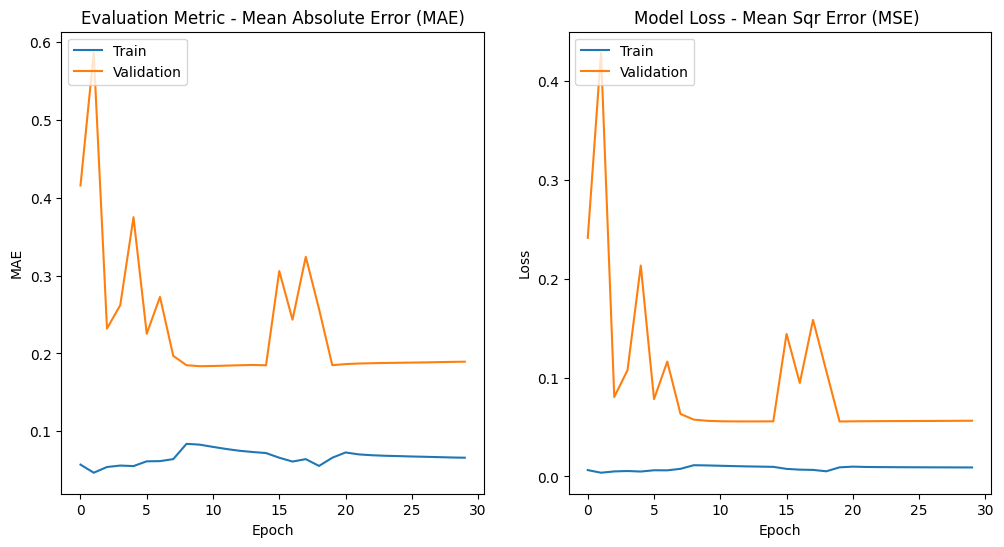

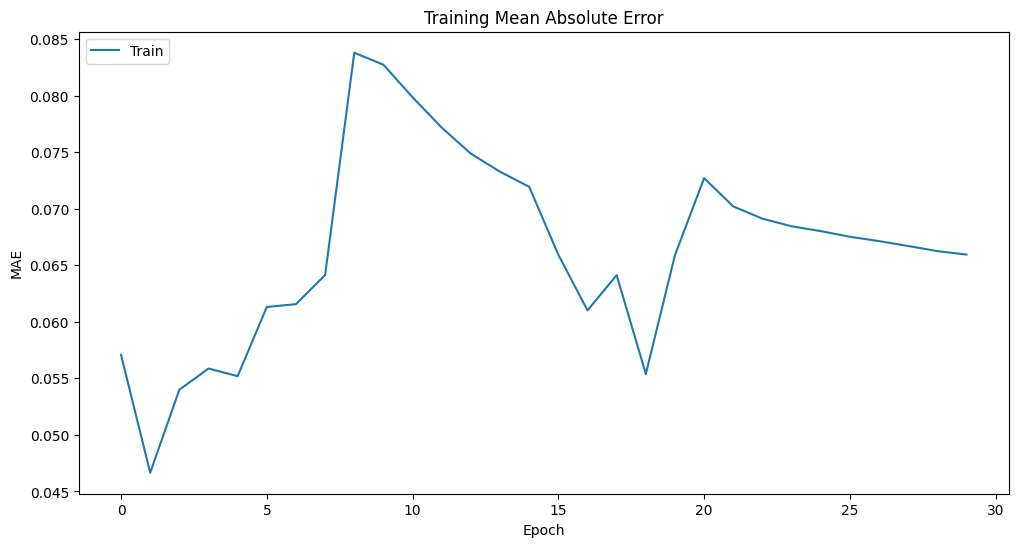

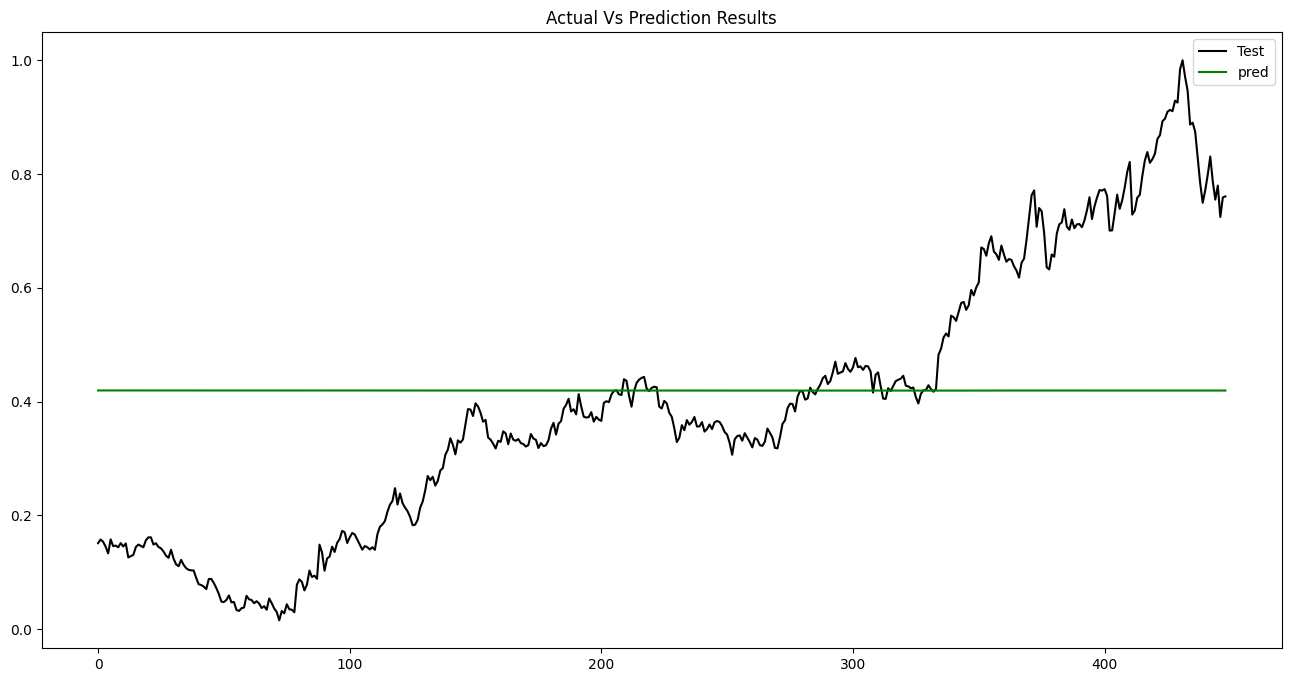

############################################################################
  Model Setup:
                    Name: XOM_F50_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.18958281957629844
             mean_sqr_err =0.05645846849632987
        root_mean_sqr_err =0.23760990824527892
           pred_diff_mean =2.132177544669671
      pred_diff_bias_mean =-1.1321775446696711
    pred_correctness_mean =0.5256124721603563



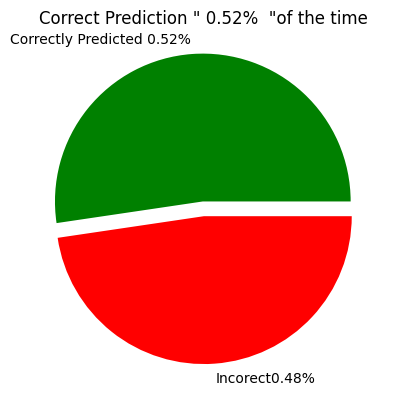

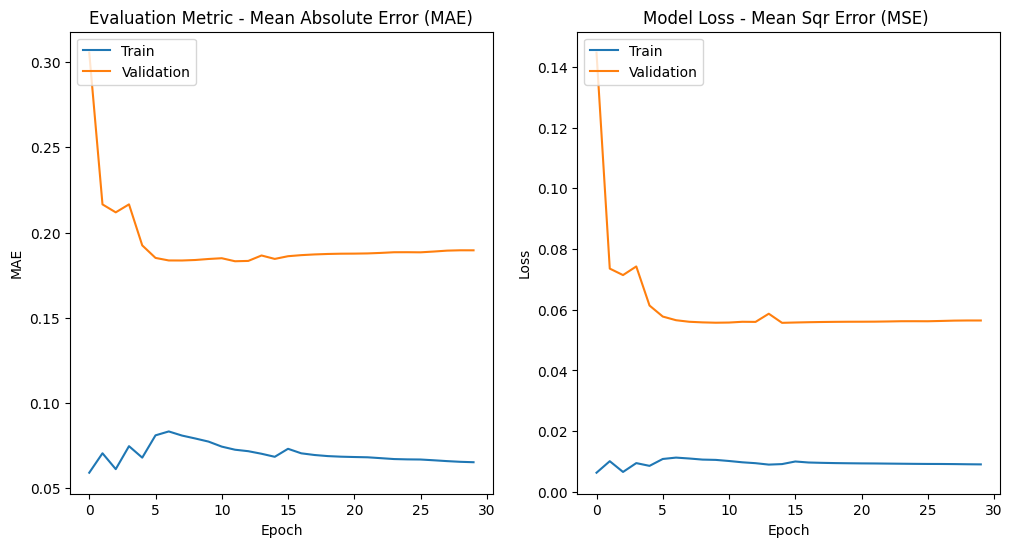

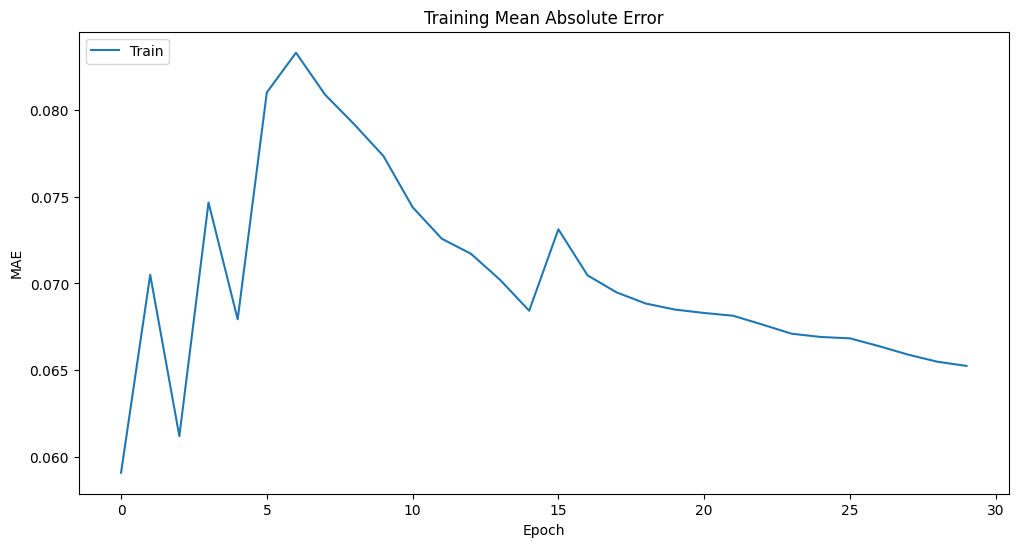

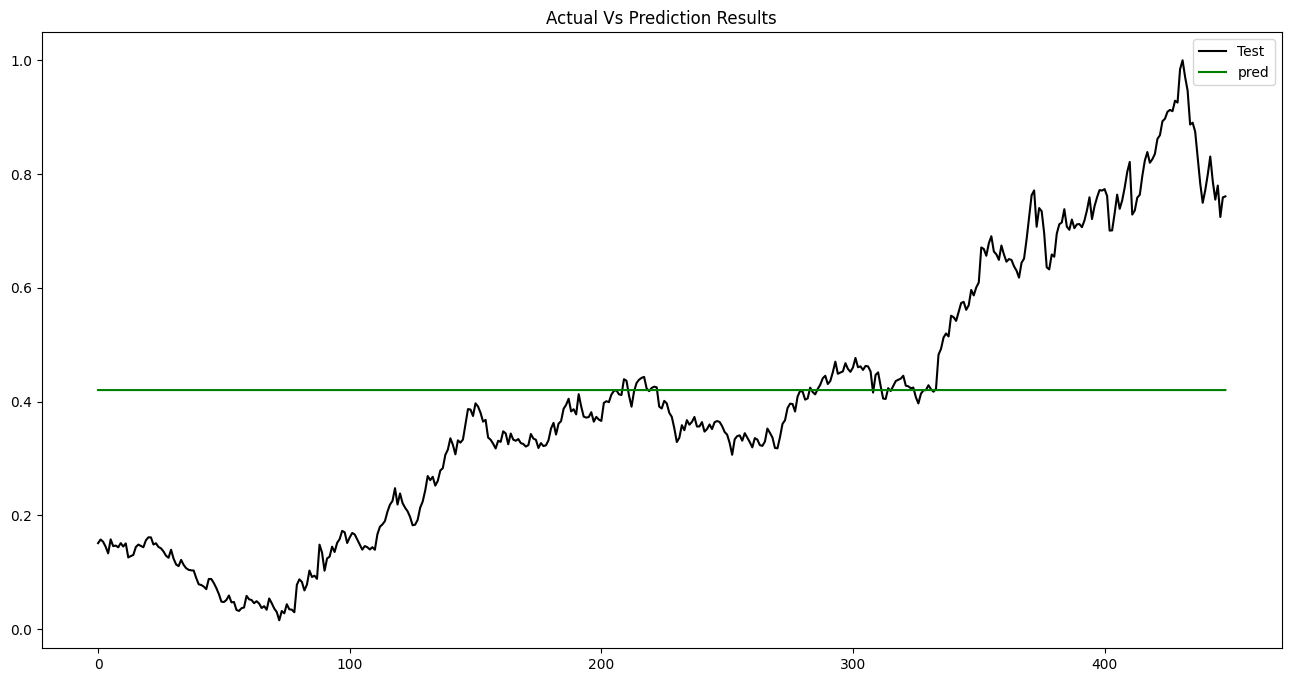

############################################################################
  Model Setup:
                    Name: XOM_F75_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.22505008492379988
             mean_sqr_err =0.06819045403354558
        root_mean_sqr_err =0.2611330198070431
           pred_diff_mean =0.4991268730894733
      pred_diff_bias_mean =0.5008731269105267
    pred_correctness_mean =0.4346846846846847



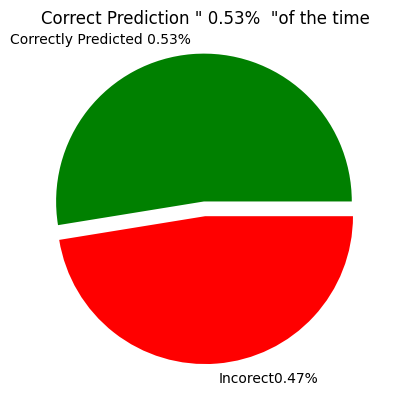

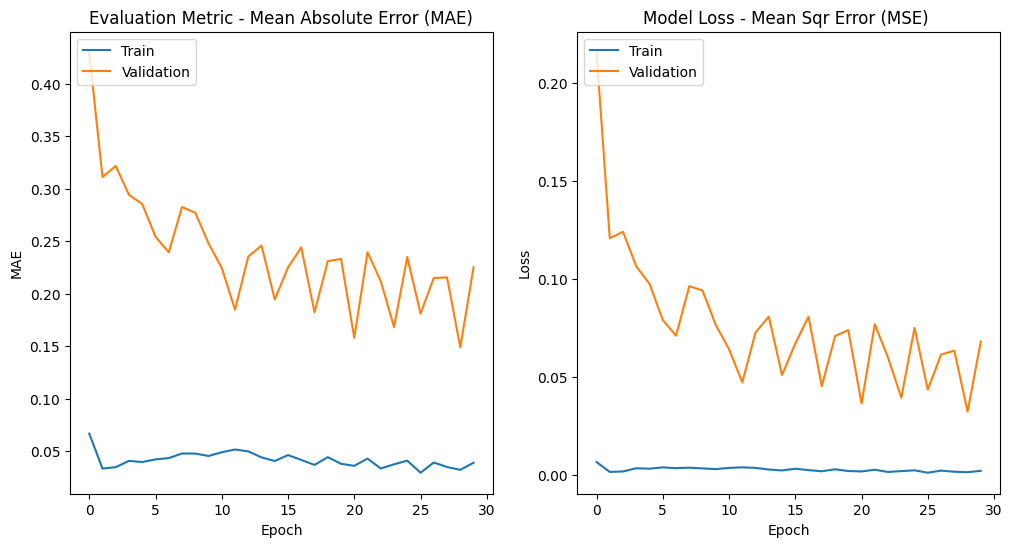

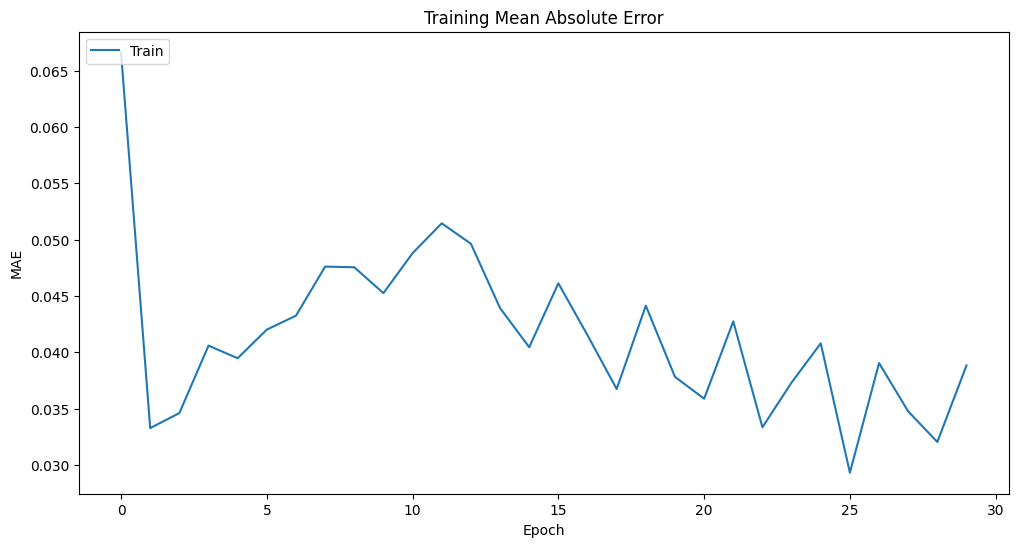

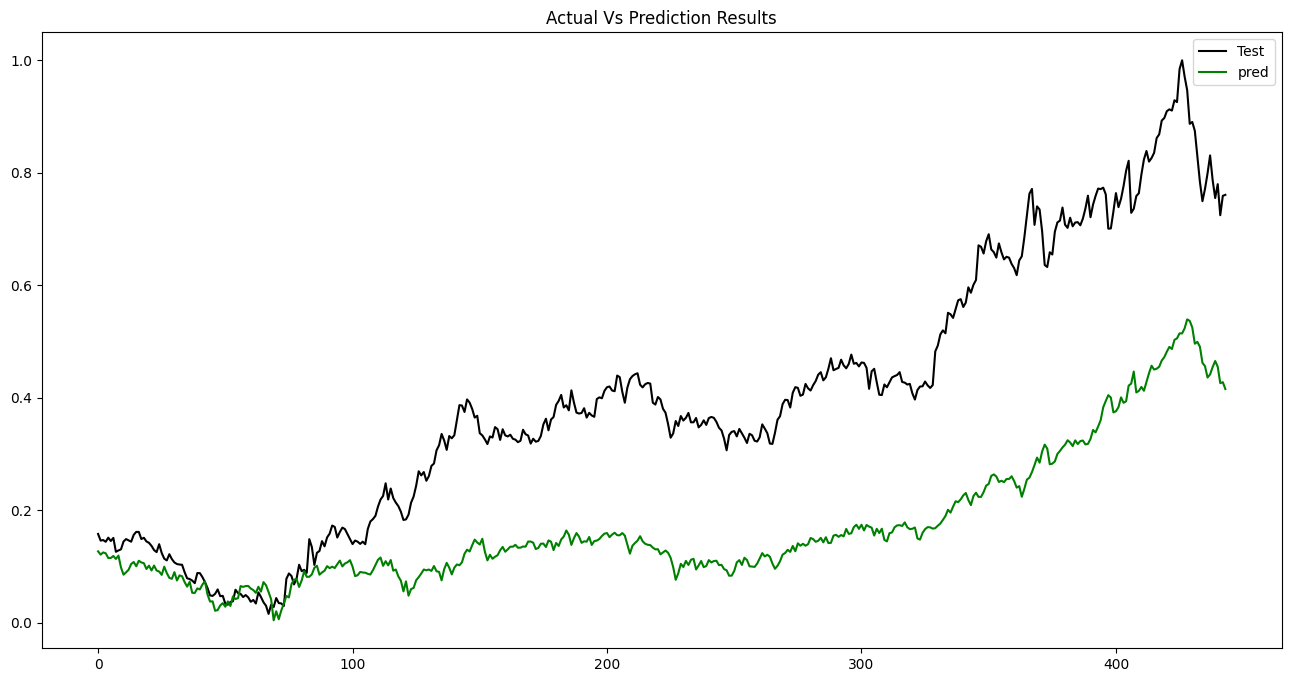

############################################################################
  Model Setup:
                    Name: XOM_F75_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.1881794414171633
             mean_sqr_err =0.051113894835093314
        root_mean_sqr_err =0.2260838225859898
           pred_diff_mean =0.6595745534088645
      pred_diff_bias_mean =0.3404254465911354
    pred_correctness_mean =0.49099099099099097



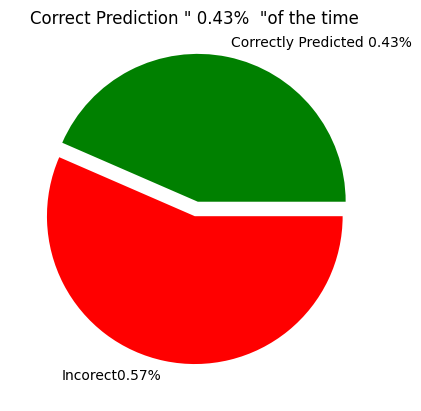

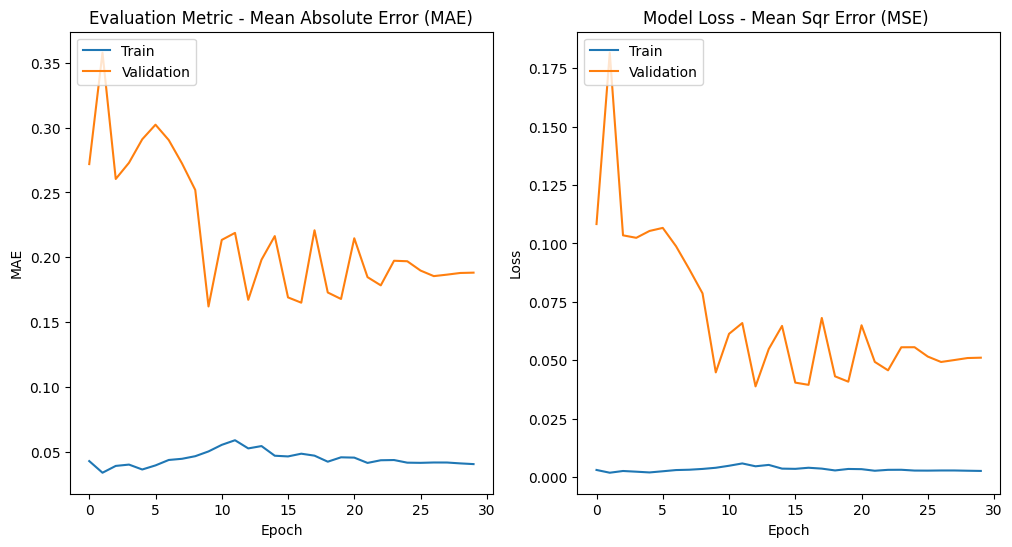

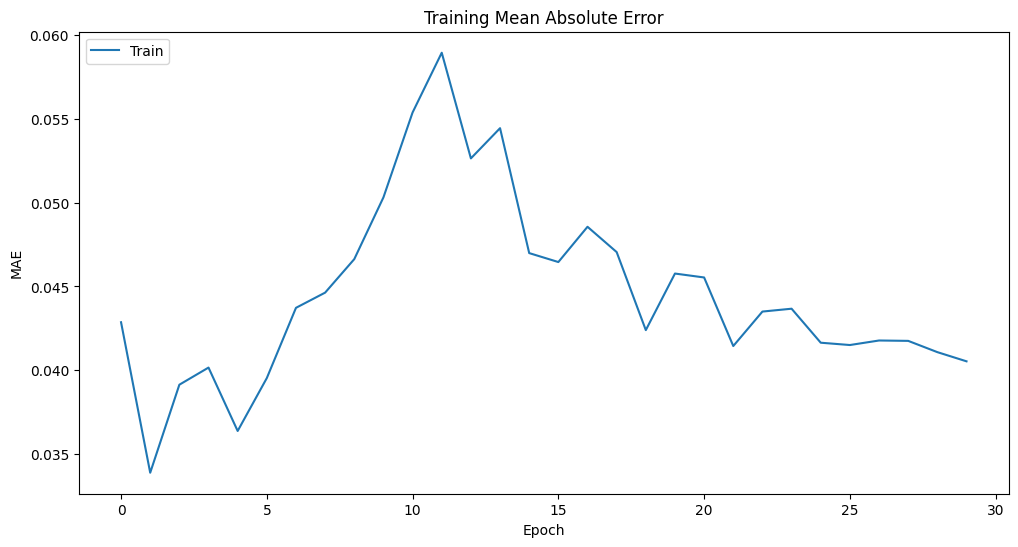

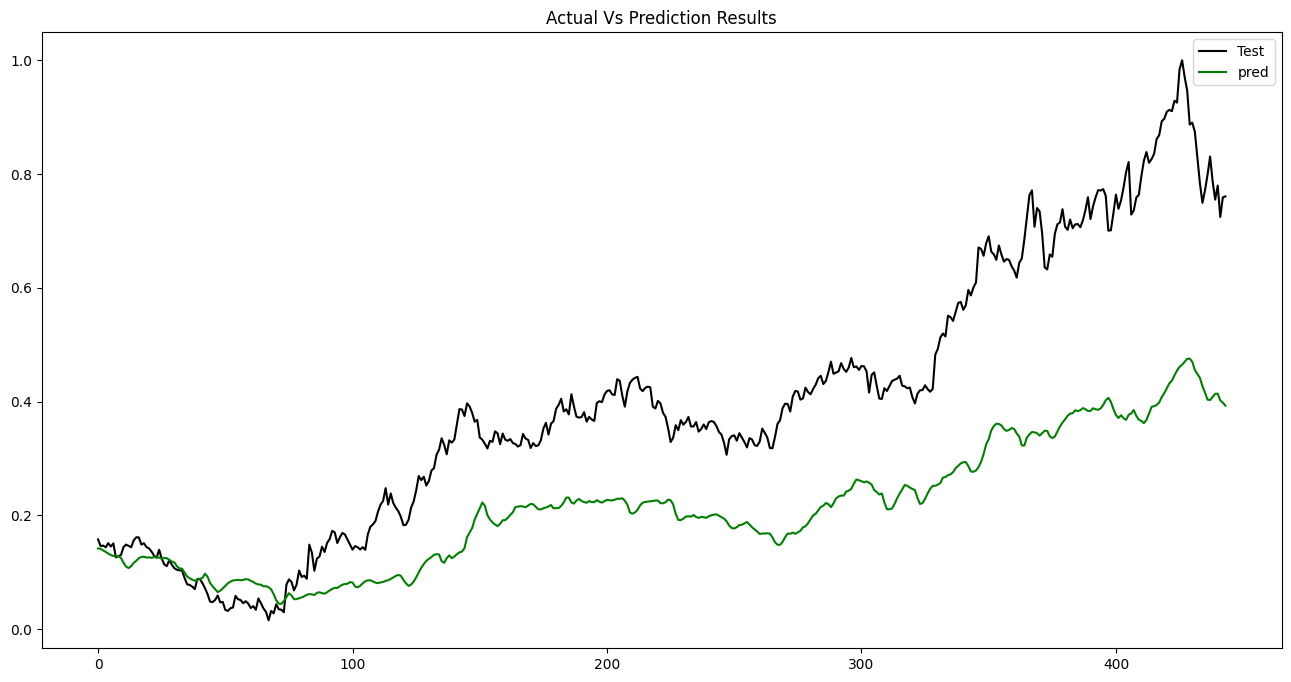

############################################################################
  Model Setup:
                    Name: XOM_F75_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.225460904709545
             mean_sqr_err =0.07263626406986352
        root_mean_sqr_err =0.2695111575980919
           pred_diff_mean =0.7205681883356959
      pred_diff_bias_mean =0.27943181166430403
    pred_correctness_mean =0.481981981981982



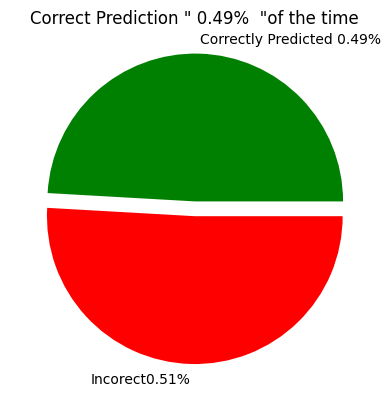

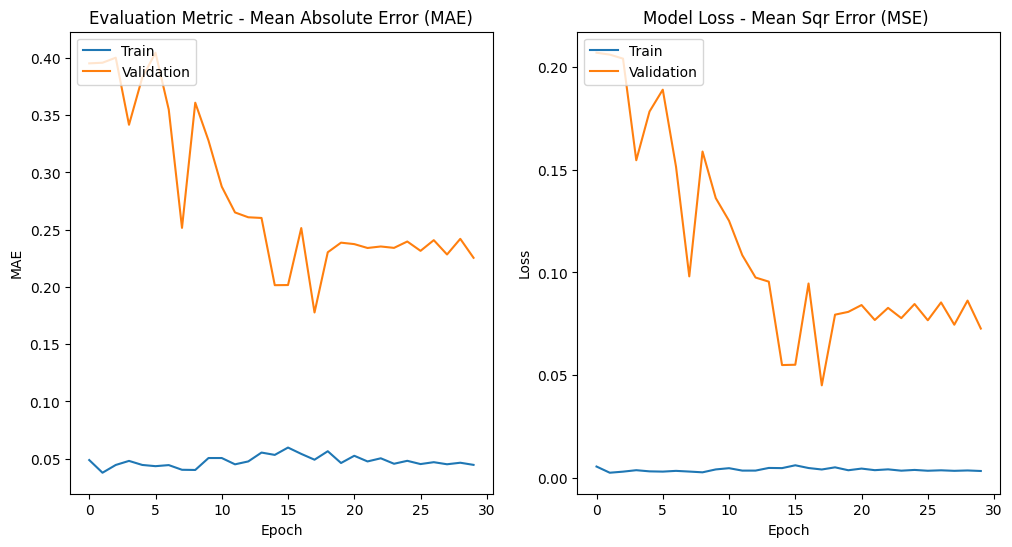

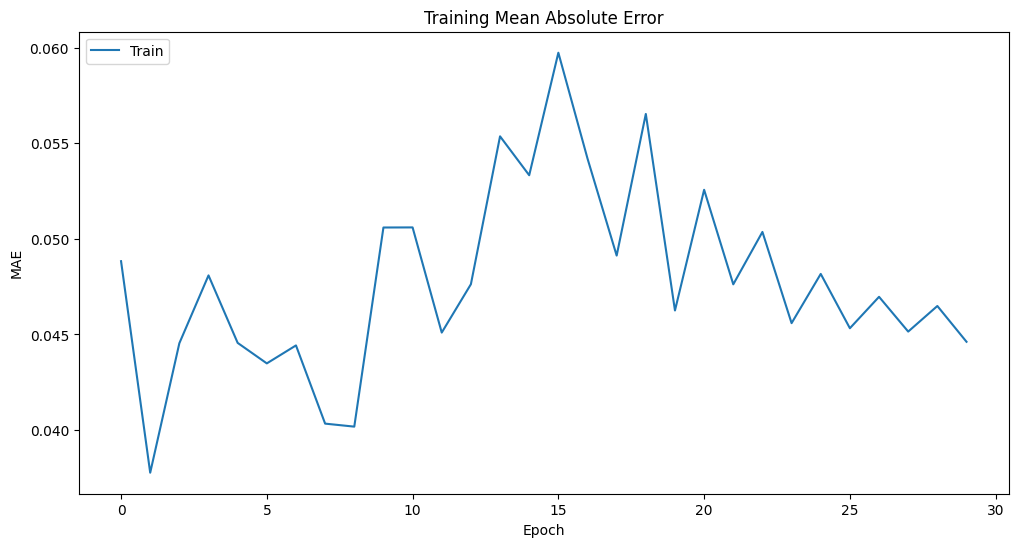

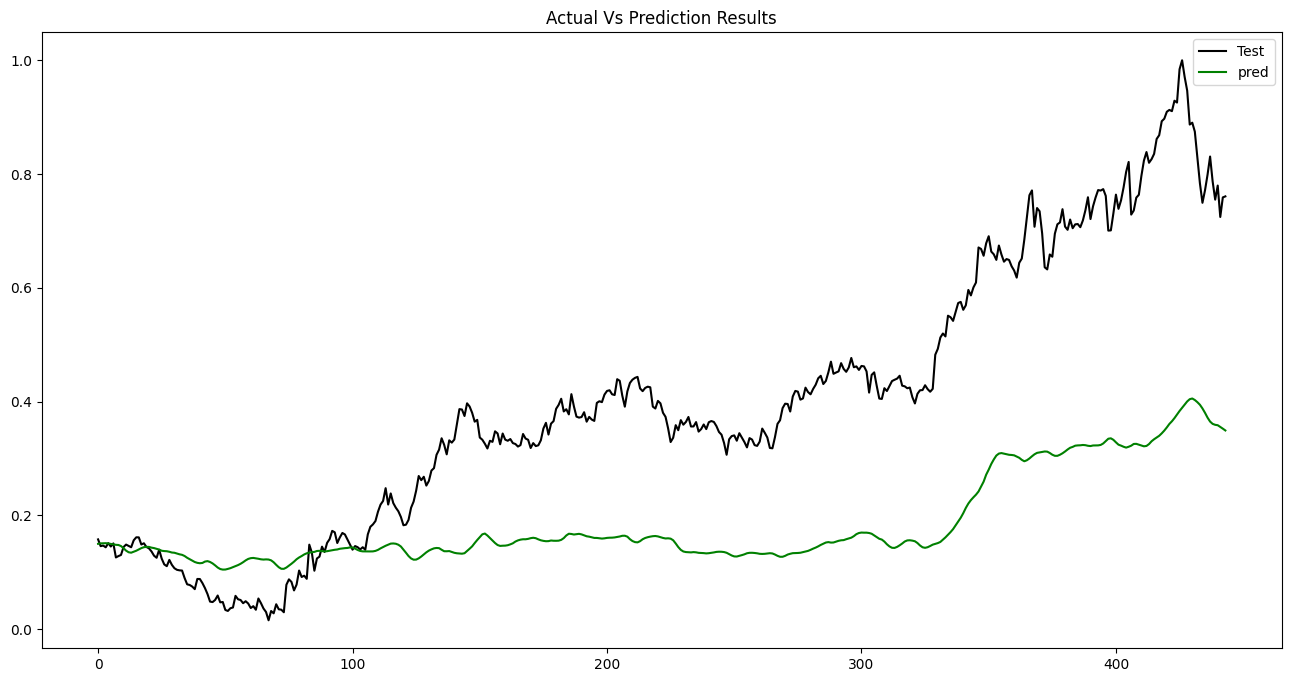

############################################################################
  Model Setup:
                    Name: XOM_F75_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.2499087725474153
             mean_sqr_err =0.09409531848879893
        root_mean_sqr_err =0.3067496022634731
           pred_diff_mean =0.9652405157669215
      pred_diff_bias_mean =0.03475948423307864
    pred_correctness_mean =0.38288288288288286



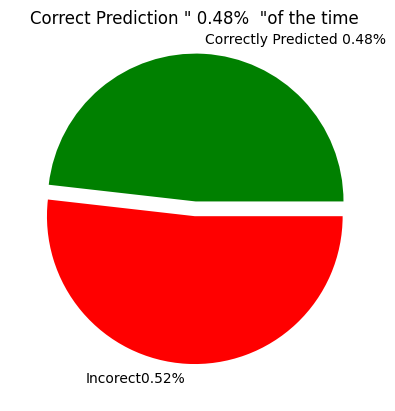

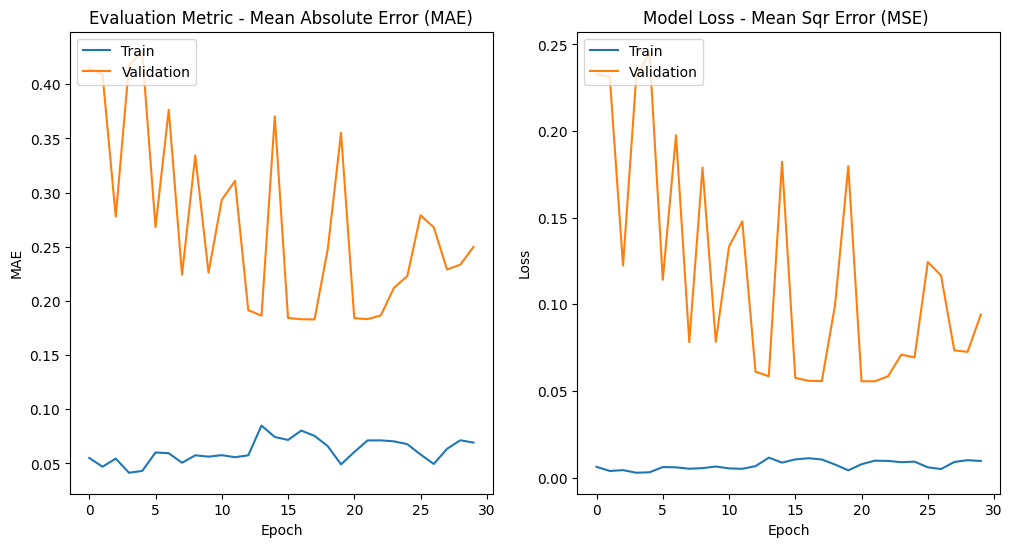

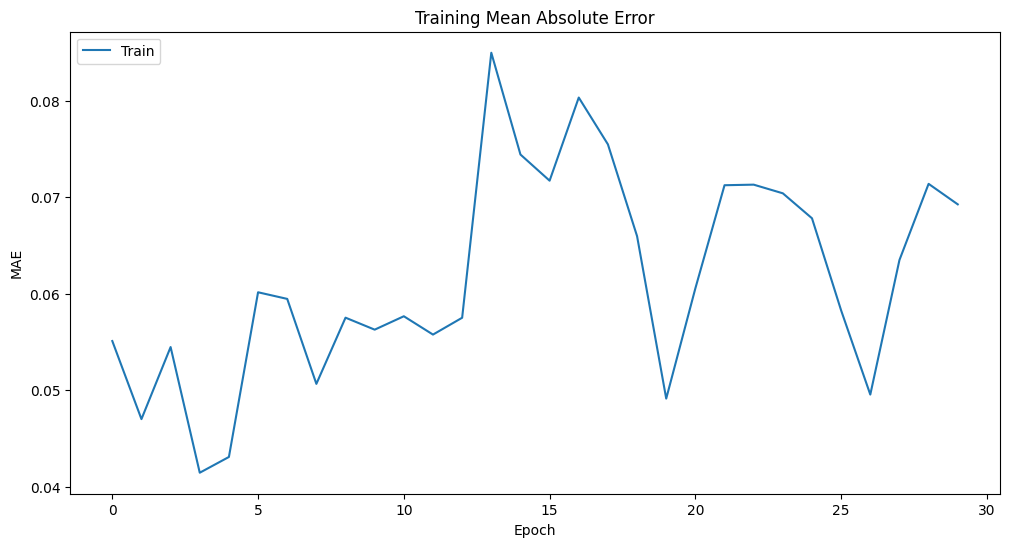

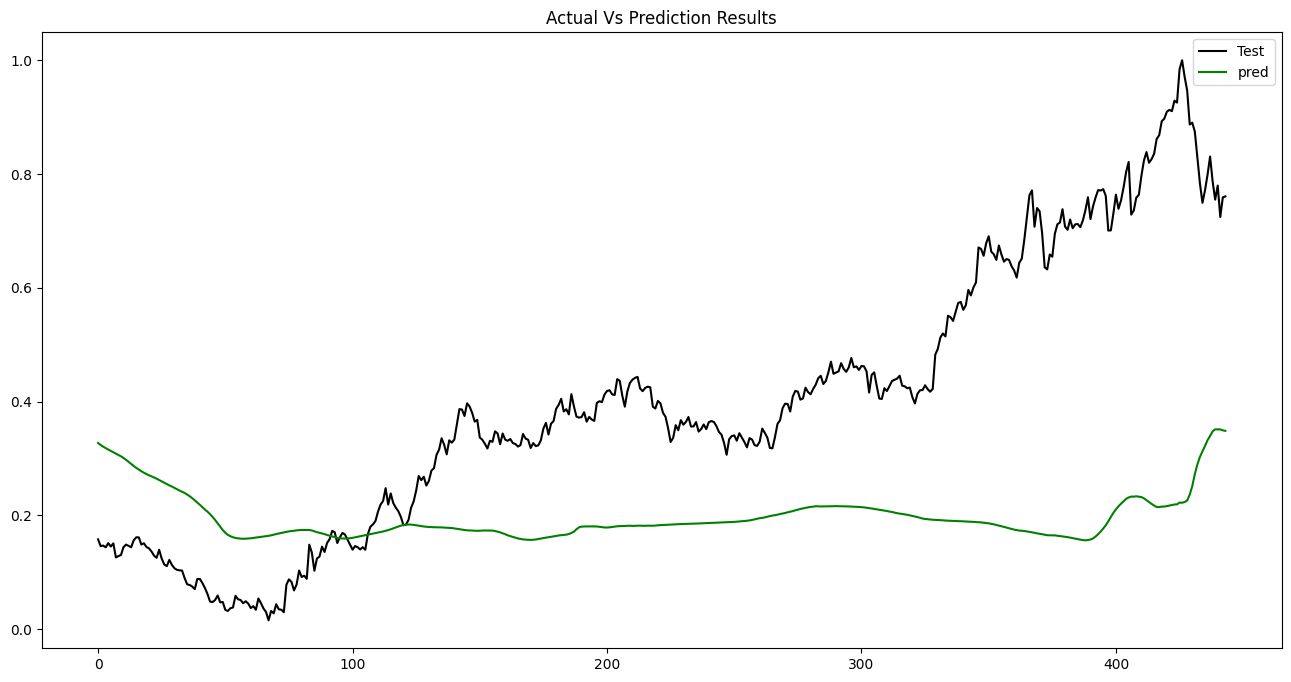

############################################################################
  Model Setup:
                    Name: XOM_F75_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.1983252002715318
             mean_sqr_err =0.06416646116135542
        root_mean_sqr_err =0.25331099692148273
           pred_diff_mean =1.5300777600202098
      pred_diff_bias_mean =-0.53007776002021
    pred_correctness_mean =0.39414414414414417



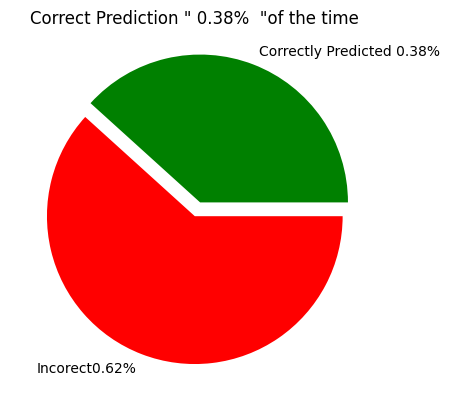

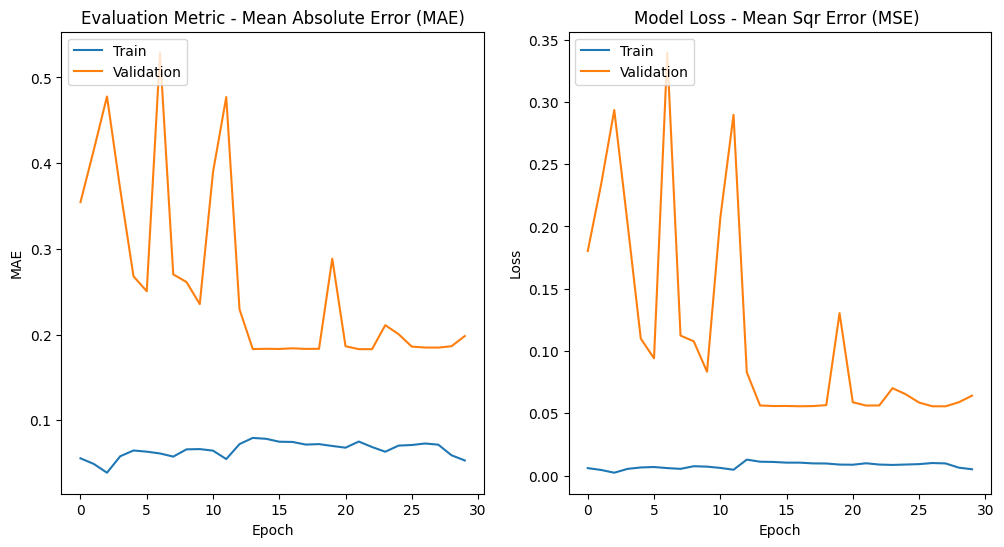

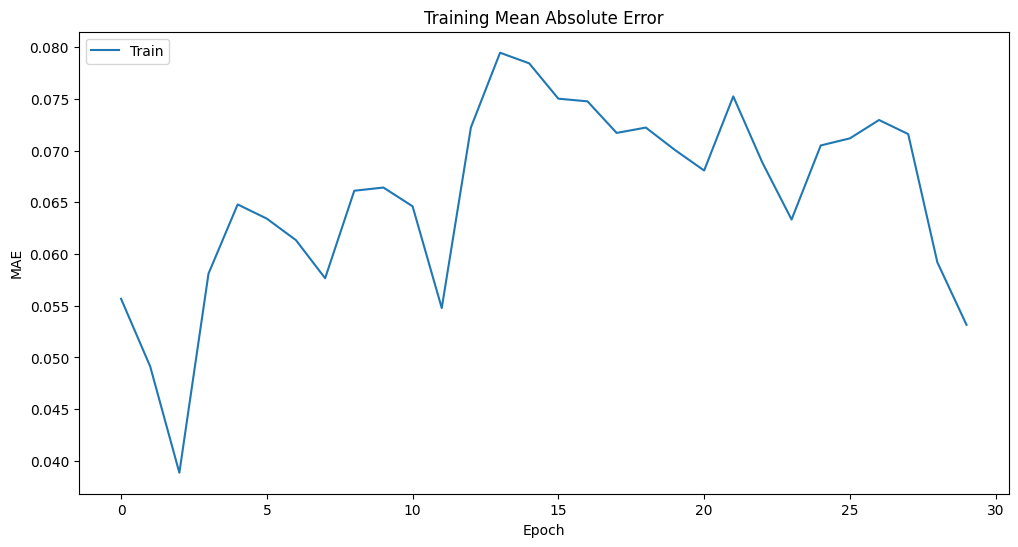

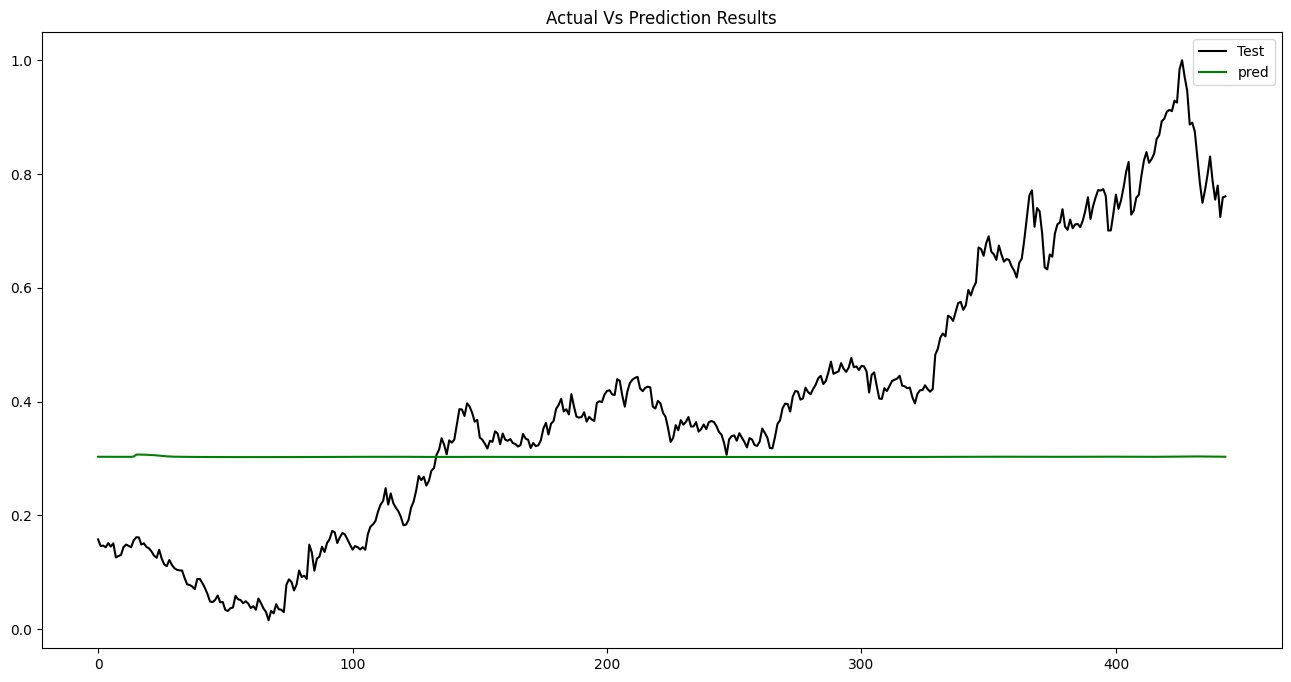

############################################################################
  Model Setup:
                    Name: XOM_F75_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 75
  Result Data:
             mean_abs_err =0.1876087062226245
             mean_sqr_err =0.05605408974481864
        root_mean_sqr_err =0.23675744918548738
           pred_diff_mean =2.101130801302678
      pred_diff_bias_mean =-1.1011308013026784
    pred_correctness_mean =0.5788288288288288



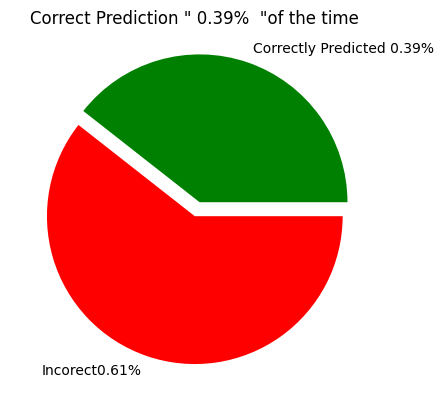

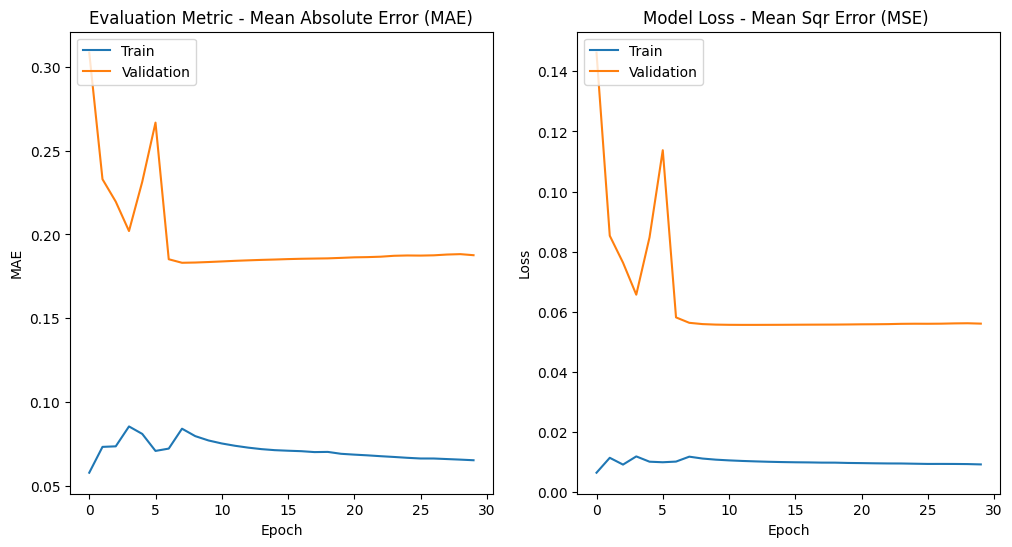

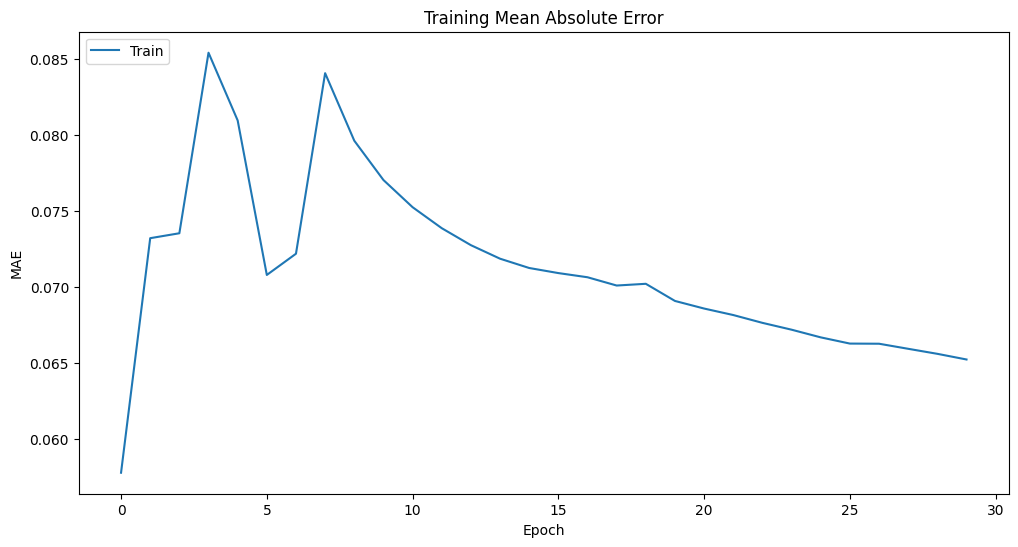

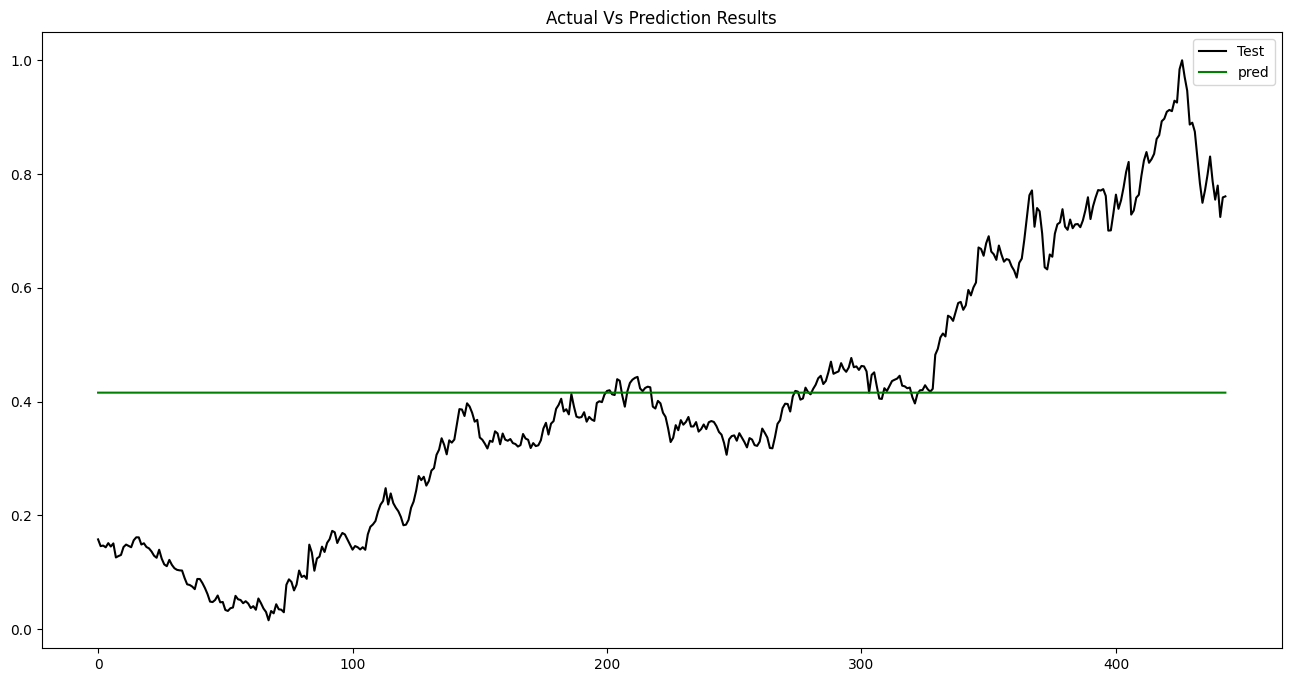

############################################################################
  Model Setup:
                    Name: XOM_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.12313726566151482
             mean_sqr_err =0.02427177417291963
        root_mean_sqr_err =0.15579401199314313
           pred_diff_mean =0.8137283831797896
      pred_diff_bias_mean =0.18627161682021032
    pred_correctness_mean =0.7881548974943052



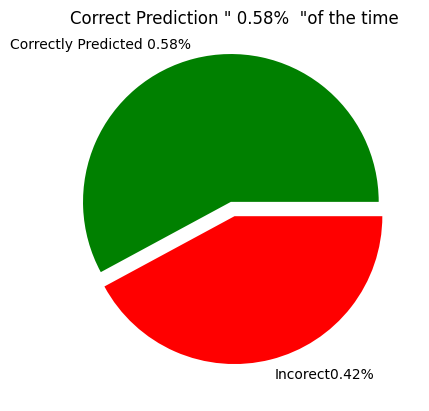

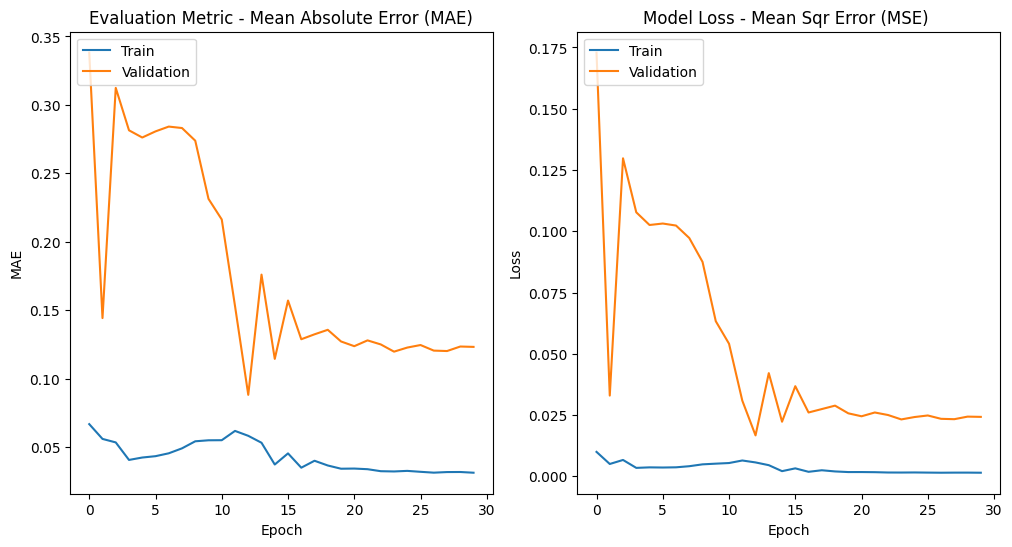

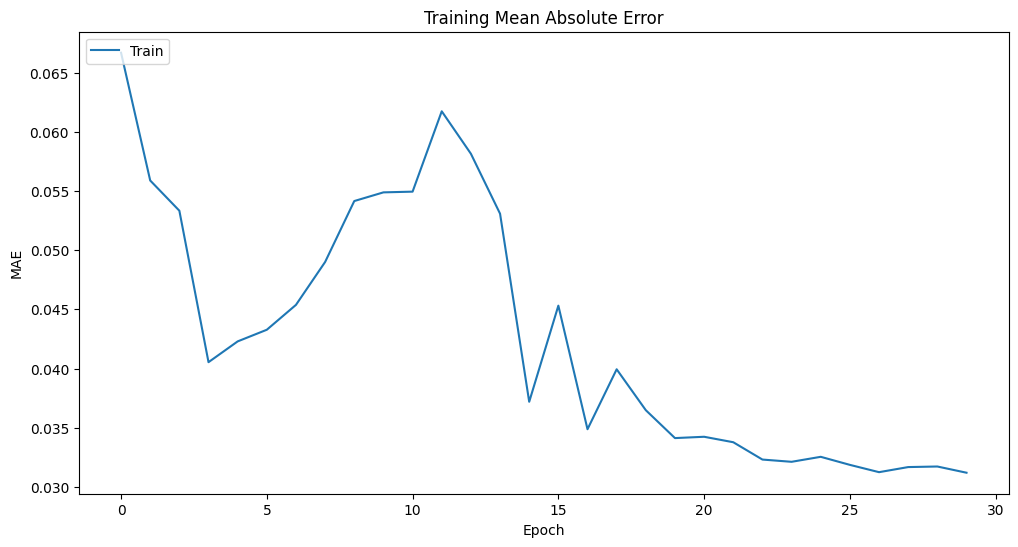

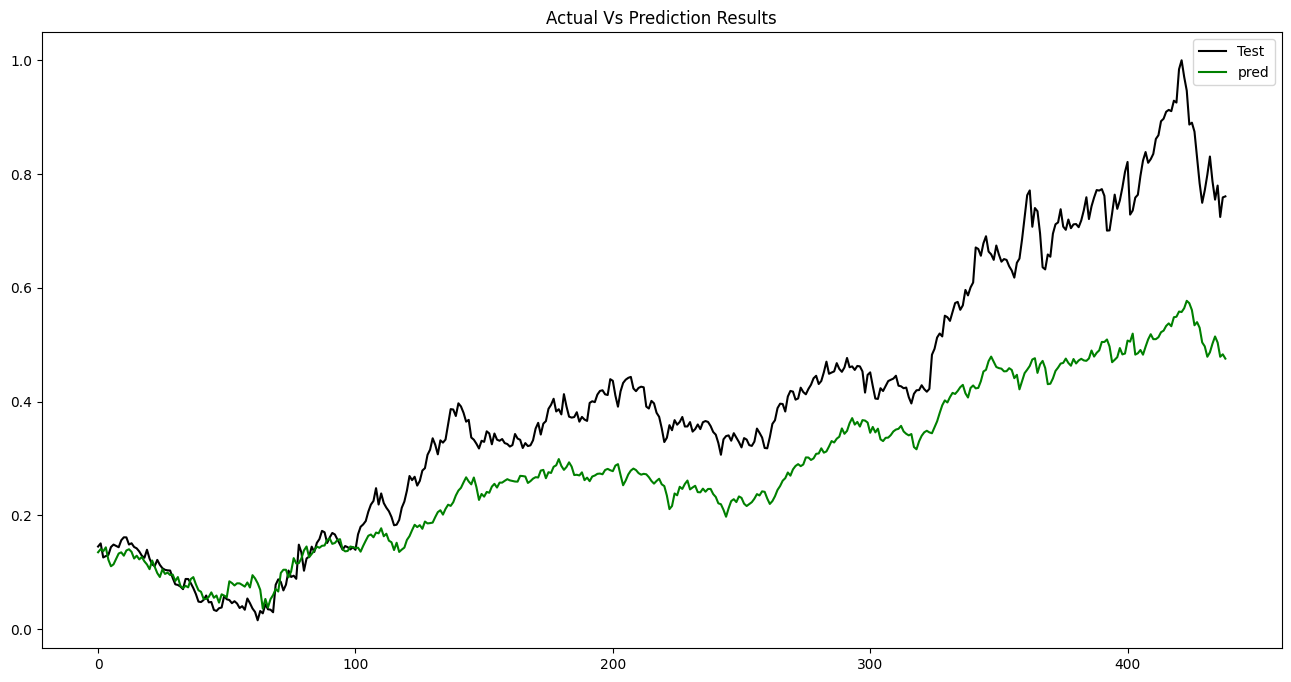

############################################################################
  Model Setup:
                    Name: XOM_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.21548559705628081
             mean_sqr_err =0.06176688658511123
        root_mean_sqr_err =0.24852944812458588
           pred_diff_mean =0.7043221891821623
      pred_diff_bias_mean =0.2956778108178377
    pred_correctness_mean =0.5626423690205011



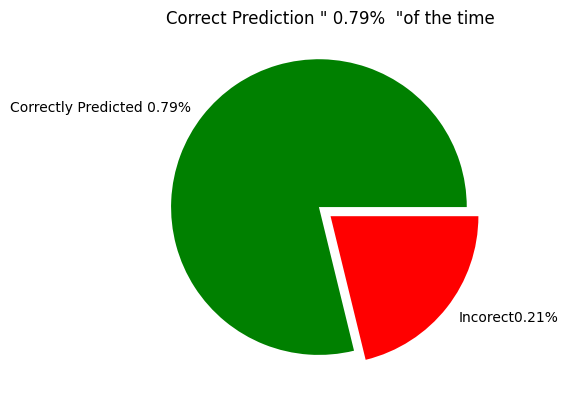

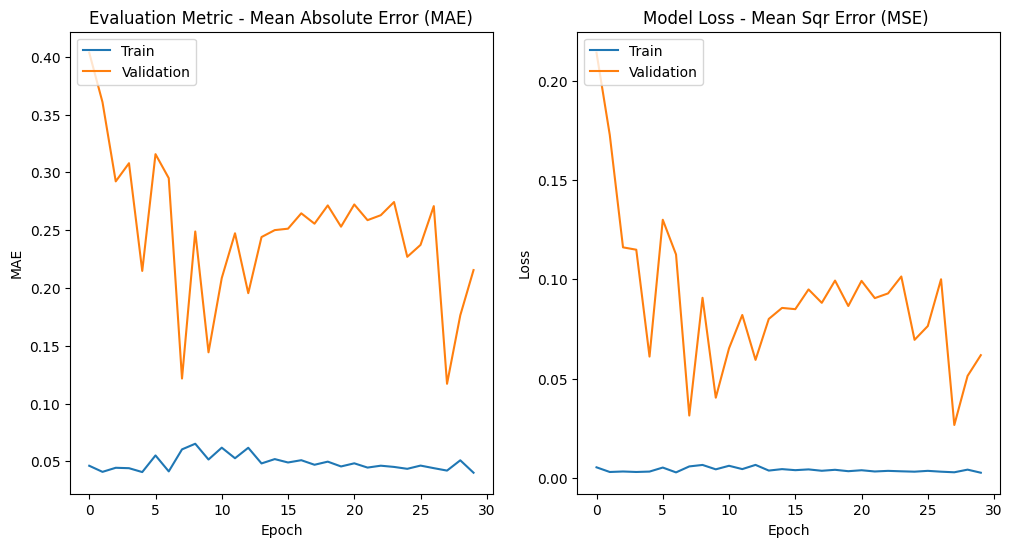

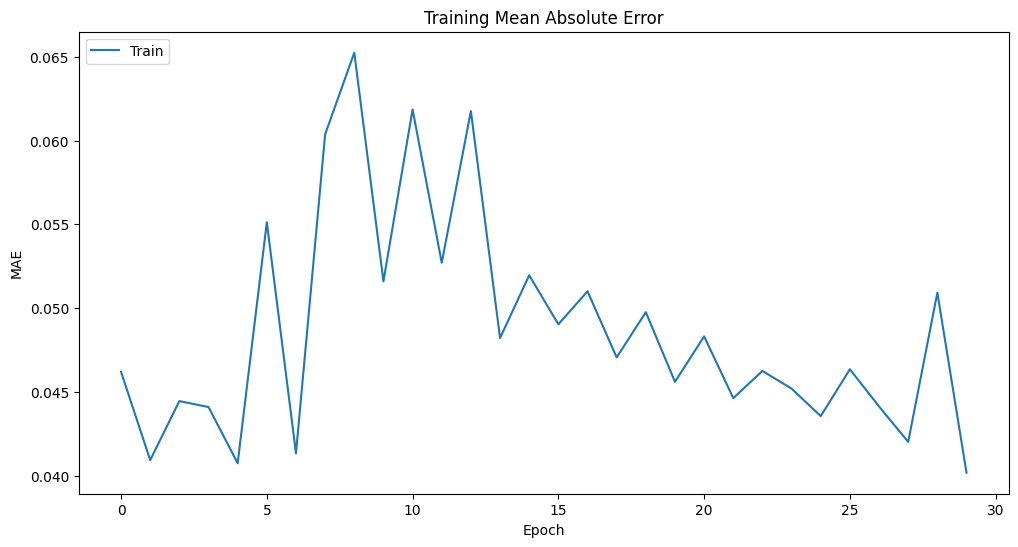

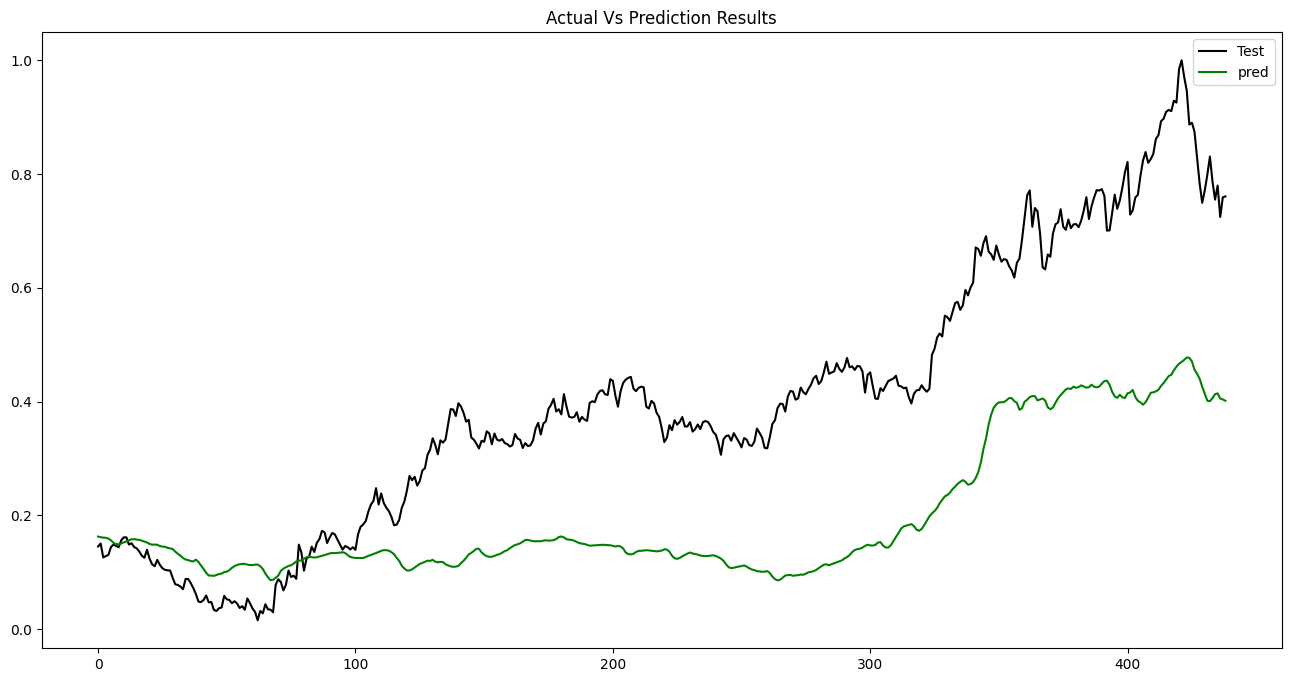

############################################################################
  Model Setup:
                    Name: XOM_F100_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.1995723509492335
             mean_sqr_err =0.05926134338565768
        root_mean_sqr_err =0.24343652845384087
           pred_diff_mean =0.7127566758105914
      pred_diff_bias_mean =0.2872433241894084
    pred_correctness_mean =0.5353075170842825



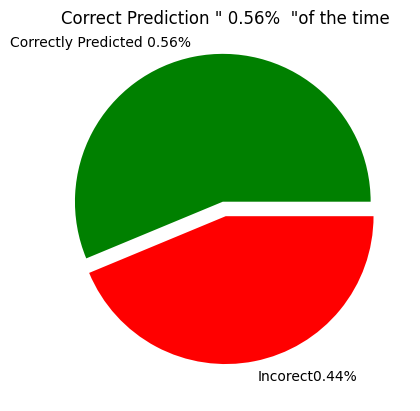

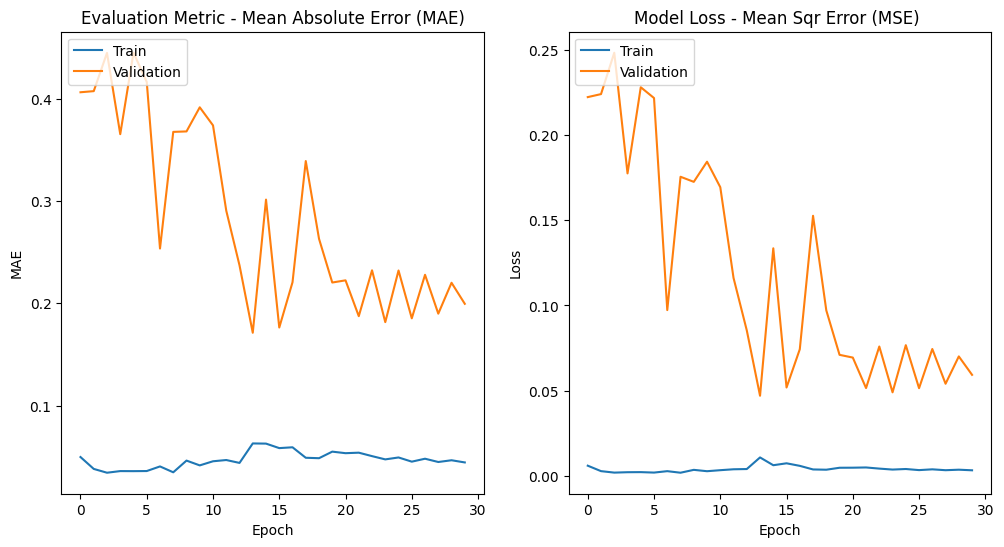

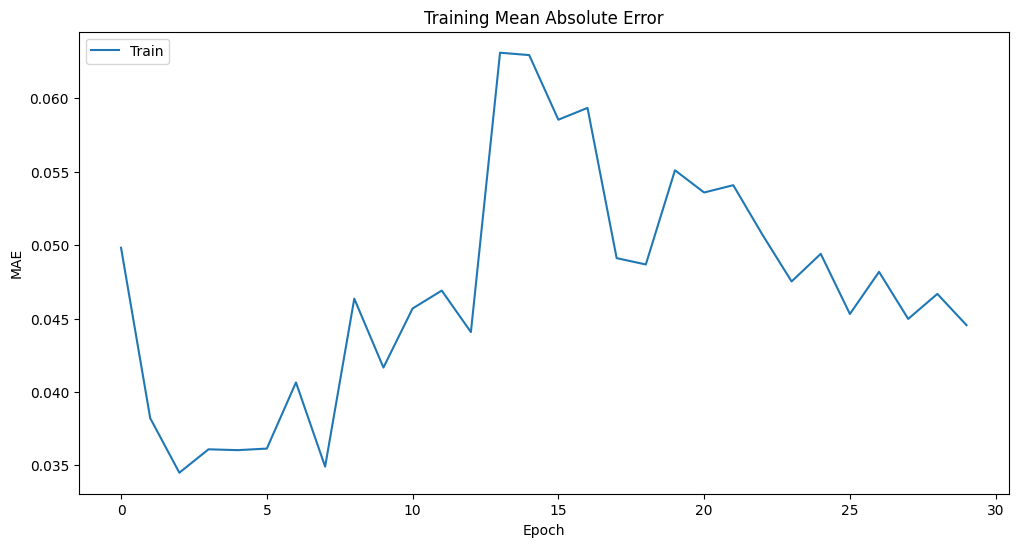

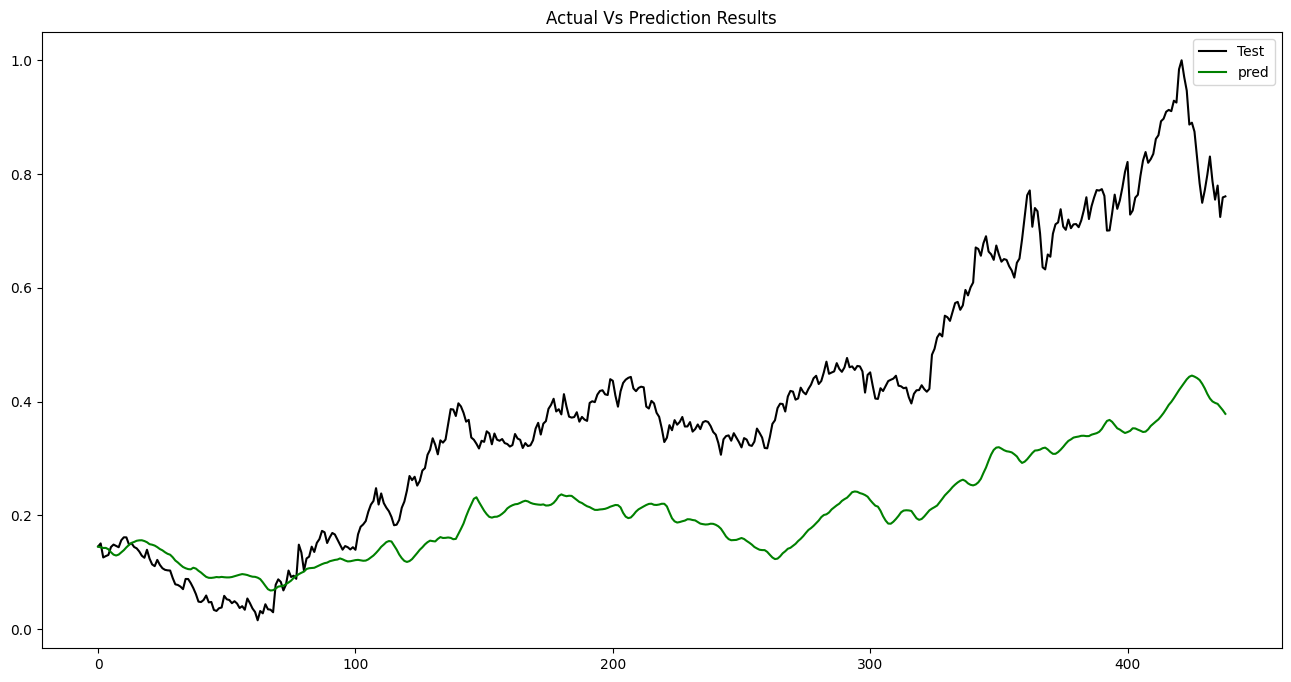

############################################################################
  Model Setup:
                    Name: XOM_F100_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.19157058665332807
             mean_sqr_err =0.05649372838655692
        root_mean_sqr_err =0.2376840936759482
           pred_diff_mean =0.890840868343154
      pred_diff_bias_mean =0.10915913165684596
    pred_correctness_mean =0.5330296127562643



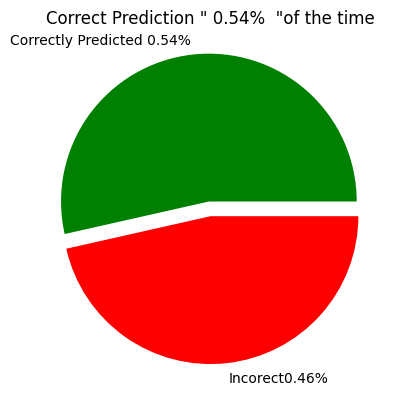

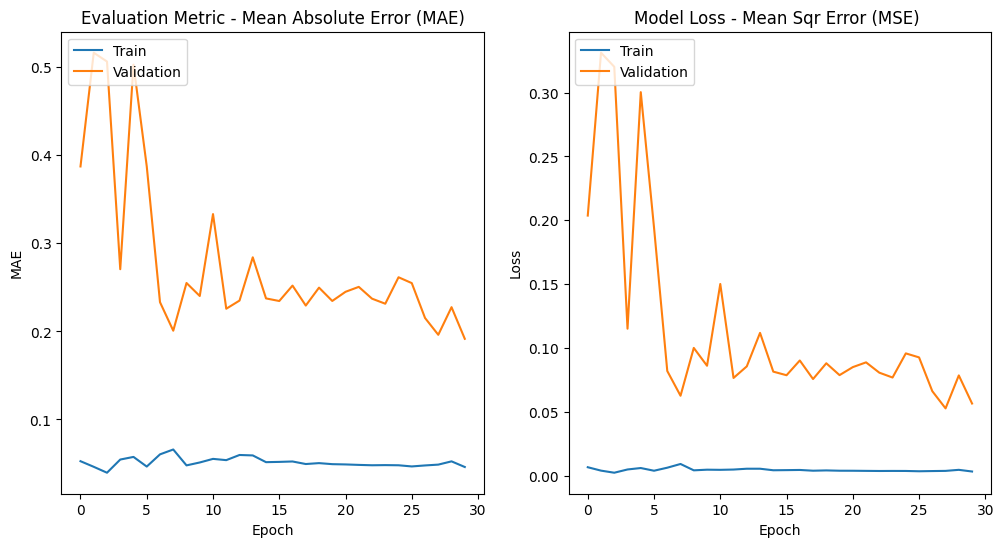

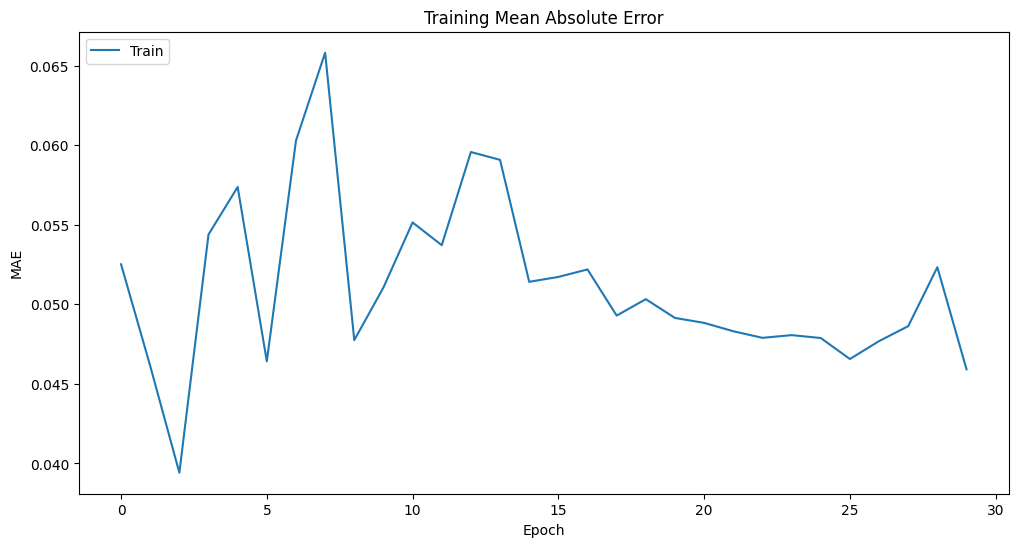

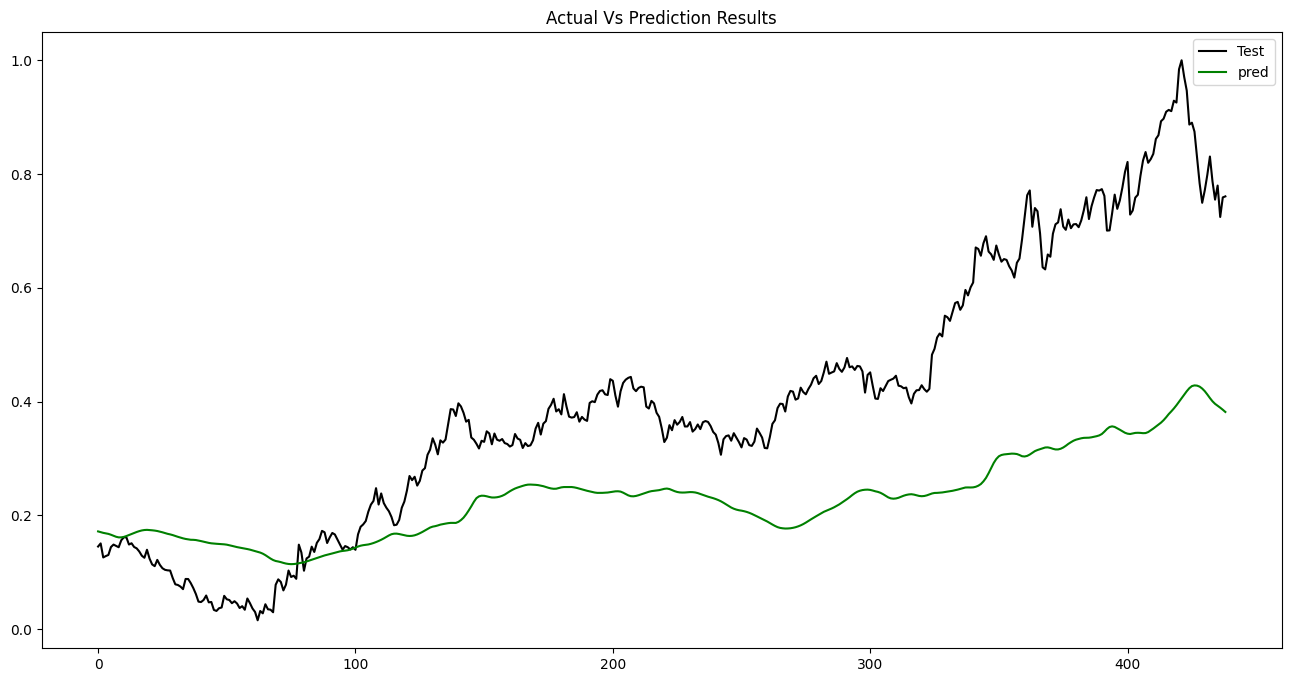

############################################################################
  Model Setup:
                    Name: XOM_F100_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.2368800135517864
             mean_sqr_err =0.08373609449137762
        root_mean_sqr_err =0.28937189651273604
           pred_diff_mean =0.9213623255650628
      pred_diff_bias_mean =0.07863767443493733
    pred_correctness_mean =0.48291571753986334



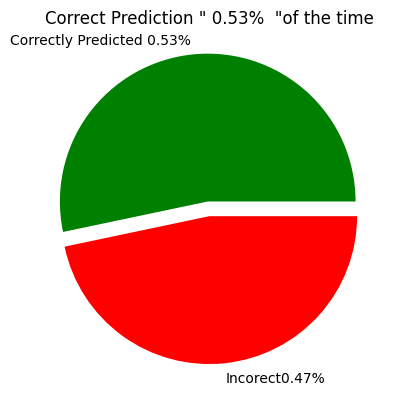

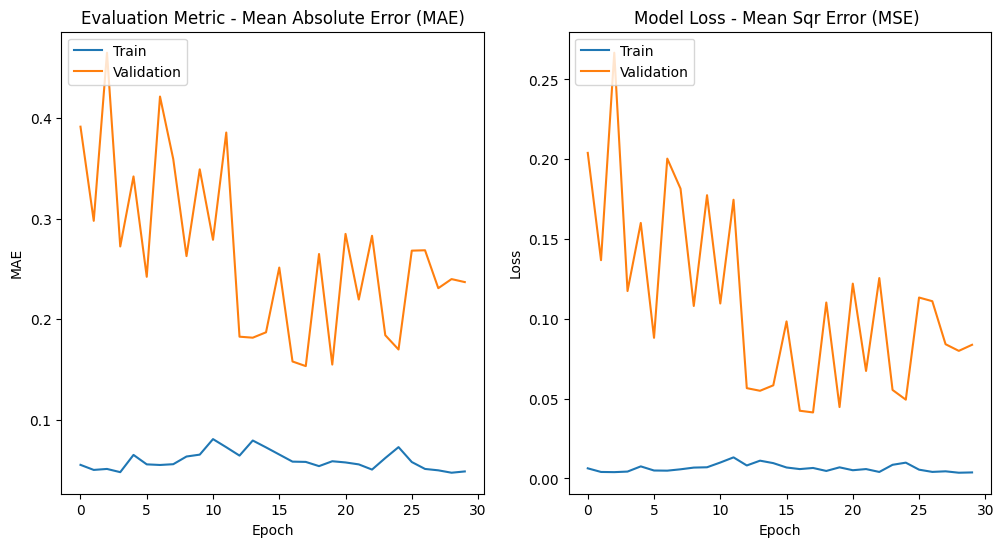

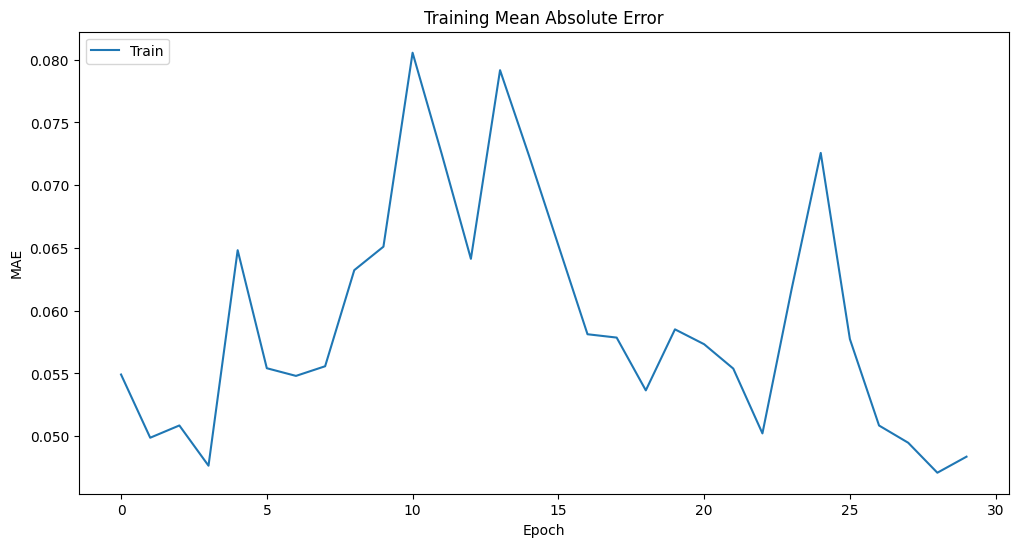

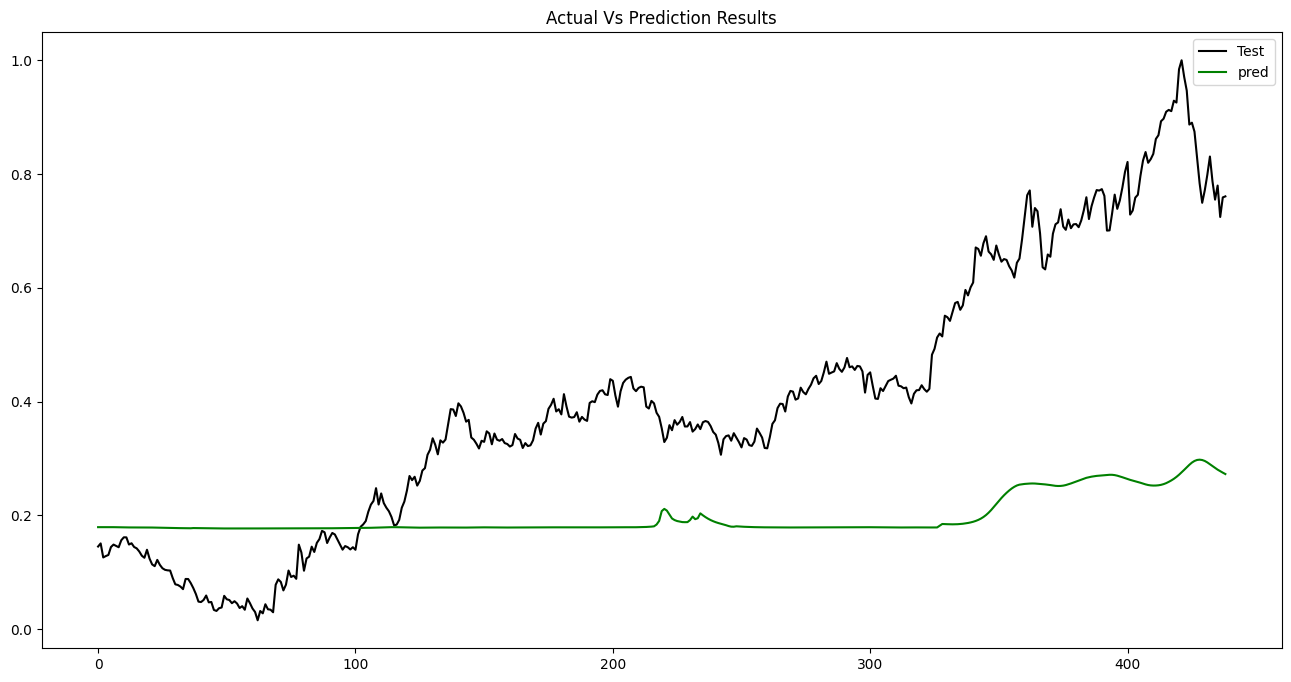

############################################################################
  Model Setup:
                    Name: XOM_F100_L6
             LSTM_Layers: 6
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: XOM
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.1863988614087971
             mean_sqr_err =0.055829796951566
        root_mean_sqr_err =0.2362832980800082
           pred_diff_mean =2.0853853553818644
      pred_diff_bias_mean =-1.0853853553818644
    pred_correctness_mean =0.6378132118451025



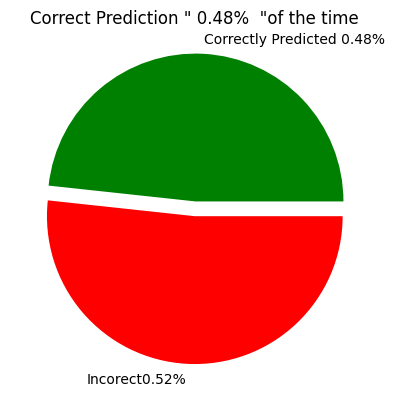

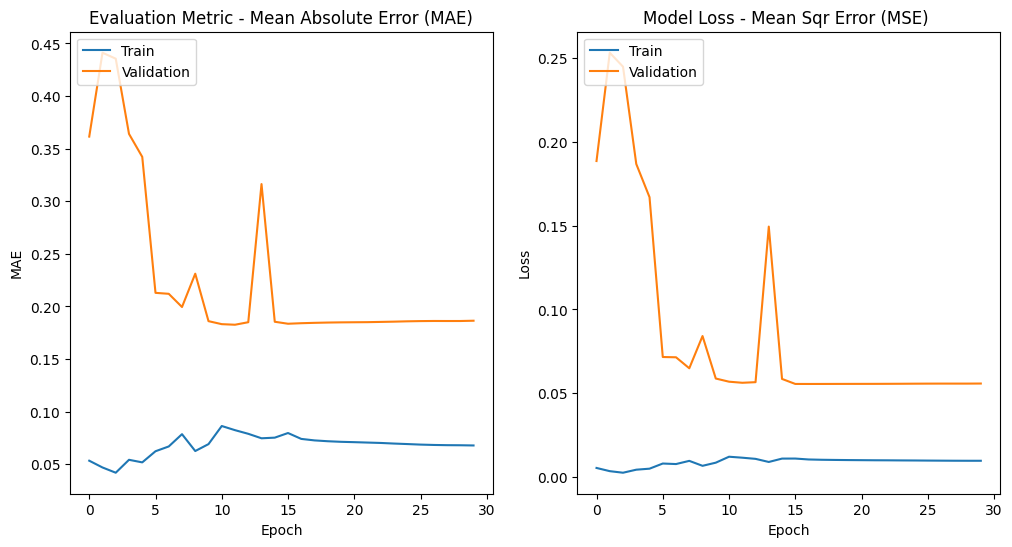

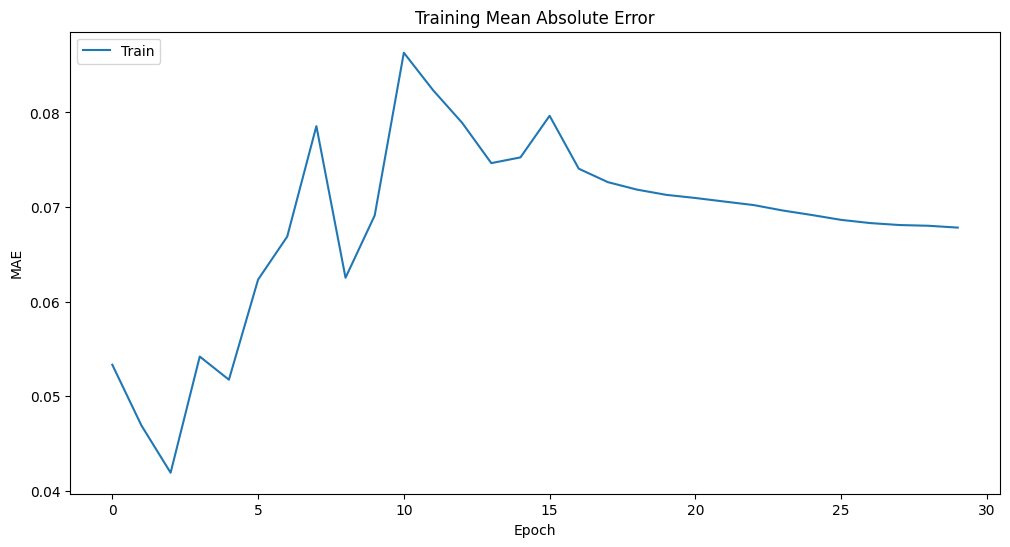

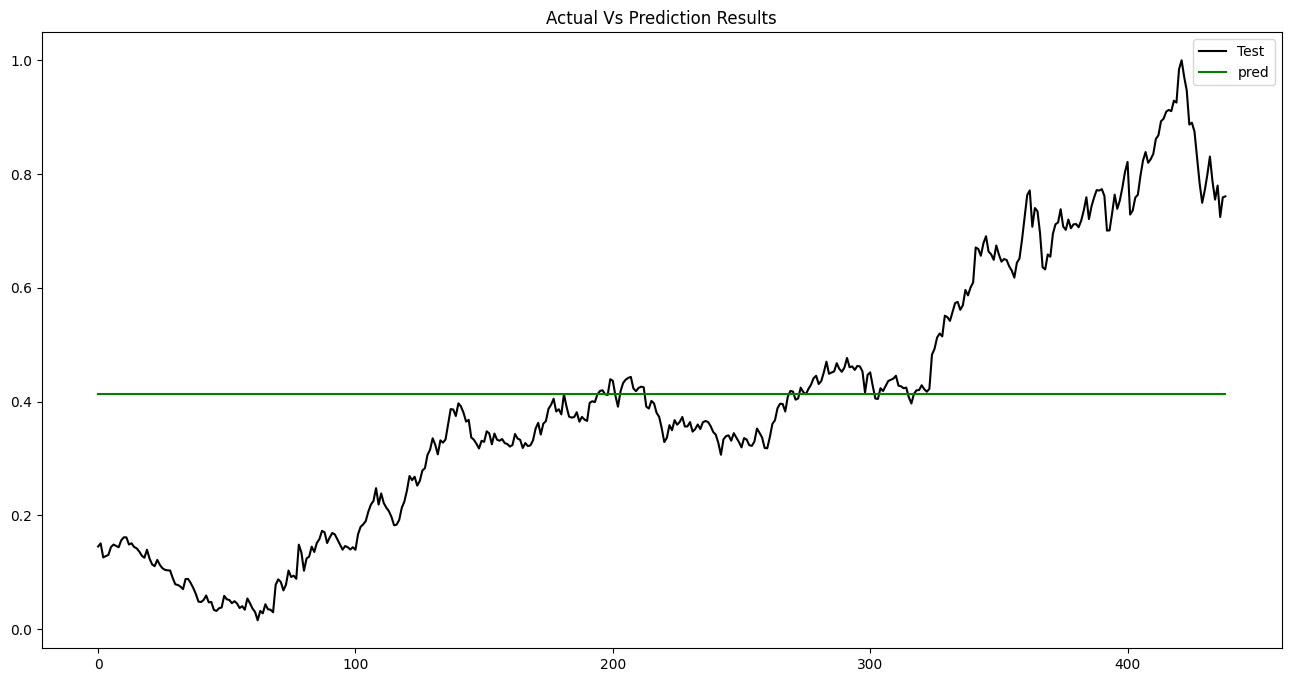

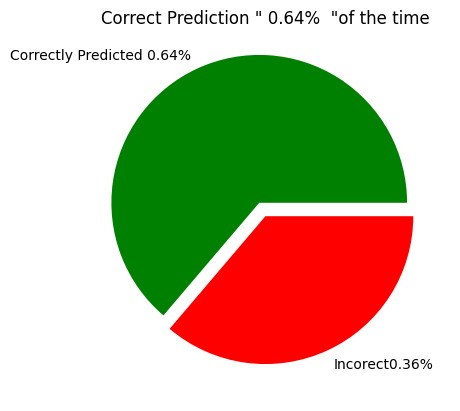

In [32]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [33]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive